# Relax native structures and then examine inter-atomic distance distributions

## Import `Python` modules

In [1]:
# Import modules
import os
import subprocess
import glob
import shutil
import sys
import Bio.Alphabet
import pandas
import numpy as np
import scipy.stats
import random
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette = 'colorblind')

sys.path.append('scripts/')
import design_utils

# Initiate directories
resultsdir = 'results/'

## Compute inter-atomic distances for each group of native structures

Copy over PDBs not used in optE for a validation set

In [2]:
# Make a list of directories with PDBs (there are
# some directories to ignore)
pdb_dir = '/home/dimaio/projects/xtal_hires'
sub_dirs = [
    d for d in glob.glob(f'{pdb_dir}/*/')
    if len(d.split('/')[-2]) == 4
]

# Make a list of all high-res PDBs, including ones
# used in training
all_pdbs = []
for d in sub_dirs:
    pdb_i = glob.glob(os.path.join(d, '*_clean_0001.pdb'))
    assert len(pdb_i) <= 1, pdb_i
    all_pdbs += pdb_i
print(f"Found a total of {len(all_pdbs)} high-res PDBs")

# Make a list of PDBs used in training
training_pdb_dir = '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/'
training_pdbs = glob.glob(os.path.join(training_pdb_dir, '*.pdb'))
print(f"Found {len(training_pdbs)} that were used in training")

# Then, make a list of PDBs not used in training
training_pdb_basenames = set([
    os.path.basename(pdb) for pdb in training_pdbs
])
all_pdb_basenames = set([
    os.path.basename(pdb) for pdb in all_pdbs
])

validation_pdbs = list(all_pdb_basenames.difference(training_pdb_basenames))
validation_pdbs = [
    pdb for pdb in all_pdbs
    if os.path.basename(pdb) in validation_pdbs
]
print(f"Leaving {len(validation_pdbs)} for use in testing")

# If haven't done so, copy validation set to new directory
validation_dir = 'data/beta_nov16_natives_validation/'
if not os.path.isdir(validation_dir):
    os.makedirs(validation_dir)
    for pdb in validation_pdbs:
        new_pdb = os.path.join(
            validation_dir,
            os.path.basename(pdb)
        )
        shutil.copy(pdb, new_pdb)
n_pdbs = len(glob.glob(os.path.join(validation_dir, '*.pdb')))
assert n_pdbs == len(validation_pdbs)

Found a total of 132 high-res PDBs
Found 78 that were used in training
Leaving 54 for use in testing


Copy over PDBs of AF2 backbones from Basile and Lukas.

In [3]:
# pdb_dir = '/home/lmilles/0proteins/__orders/2021_1024_af2hall_GG06/'
# pdbs_af2 = glob.glob(os.path.join(pdb_dir, '*.pdb'))
# basenames_af2 = [os.path.basename(pdb)[:-4] for pdb in pdbs_af2]
# names_af2 = [os.path.basename(pdb)[:6] for pdb in pdbs_af2]
# print(len(pdbs_af2), len(names_af2), len(set(names_af2)))

In [4]:
# pdb_dir = '/home/lmilles/0proteins/__orders/2021_1205_GG09_af2h_mpnn/'
# pdbs_mpnn = glob.glob(os.path.join(pdb_dir, '*.pdb'))
# names_mpnn = [os.path.basename(pdb)[:6] for pdb in pdbs_mpnn]
# print(len(pdbs_mpnn), len(names_mpnn), len(set(names_mpnn)))

In [5]:
# matches_dict = {}
# for pdb_af2 in pdbs_af2:
#     basename_af2 = os.path.basename(pdb_af2)[:-4]
#     if basename_af2[0] != 'C':
#         continue
#     matches = []
#     for pdb in pdbs_mpnn:
#         if basename_af2 in pdb:
#             matches.append(pdb)
#     if len(matches) == 0:
#         continue
#     elif len(matches) >= 1:
#         matches_dict[pdb_af2] = matches
#     else:
#         continue
#         raise ValueError(len(matches))
# len(matches_dict)

In [6]:
# # Make a directory with AF2 backbones
# output_dir = 'data/lmbw_af2_des/'
# if not os.path.isdir(output_dir):
#     os.makedirs(output_dir)
# i = 0
# for pdb in matches_dict.keys():
#     i += 1
#     if not os.path.isfile(os.path.join(output_dir, os.path.basename(pdb))):
#         shutil.copy(pdb, output_dir)
# print(output_dir, i)
        
# # Make a directory with MPNN designs from the above backbones
# output_dir = 'data/lmbw_af2_mpnn_des/'
# if not os.path.isdir(output_dir):
#     os.makedirs(output_dir)
# i = 0
# for pdbs in matches_dict.values():
#     for pdb in pdbs:
#         i += 1
#         if not os.path.isfile(os.path.join(output_dir, os.path.basename(pdb))):
#             shutil.copy(pdb, output_dir)
# print(output_dir, i)

Define directories with input PDBs

In [7]:
native_pdb_dirs = {
    'beta_nov16_natives' : \
        '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/',
    'beta_nov16_natives_validation' : \
        'data/beta_nov16_natives_validation/',
    'original_ppi_natives' : \
        '/home/dimaio/optE2/dualoptE/decoys/rotrecov/interface/',
    'seq_recov_natives' : \
        '/home/dimaio/optE2/dualoptE/decoys/seqrecov_rosetta/',
    #'monomers_and_ppi_natives' : \
    #    'data/xtal_monomers_and_ppi/'
    'dpi_natives' : \
        '/home/haddox/2019/optE_eval_dist/data/dpi_natives/', # /home/dimaio/optE2/dualoptE/decoys/protein_dna/xtal_relax/
    'xtals_of_designs' : \
        '/home/haddox/2020/compare_xtal_design_pairs/data/xtals_of_designs_mod/',
    
    # 'mpnn_beta_nov16_natives' :
    #     '/home/haddox/2021/dl_design/results/mpnn/beta_nov16_natives/threaded_designs/',
    # 'mpnn_af2_beta_nov16_natives' :
    #     '/home/haddox/2021/dl_design/results/mpnn/beta_nov16_natives/mpnn_native_redesigns_af2_all_models/best_af2_models/',
    # 'rf_v00.0_beta_nov16_natives' :
    #     '/home/davidcj/projects/BFF/autofold/experiments/design/for_hugh/rf_v00.0/outputs/trf_relax/',
    # 'rf_v00.1_beta_nov16_natives' :
    #     '/home/davidcj/projects/BFF/autofold/experiments/design/for_hugh/rf_v00.1/outputs/trf_relax/',
    
    # 'lmbw_af2_des' :
    #     'data/lmbw_af2_des/',
    # 'lmbw_af2_mpnn_des' :
    #     'data/lmbw_af2_mpnn_des/',
}

Make a new `alljobs` file with commands to relax all PDBs from the `monomers_and_ppi_natives` group of PDBs from above.

In [8]:
# if False:
#     # Make a list of `run_relax` commands for the new `alljobs` file
#     pdbs = glob.glob('data/xtal_monomers_and_ppi/*.pdb')
#     new_cmds = []
#     for pdb in pdbs:
#         pdb_basename = os.path.basename(pdb).replace('.pdb', '')
#         cmd = f'./run_relax.sh {pdb_basename}\n'
#         new_cmds.append(cmd)

#     # Add new commands to the file, removing the old `run_relax` commands
#     alljobs_f = '/home/haddox/2019/optE_HH_run18C_LJ/alljobs'
#     new_alljobs_f = 'results/monomers_and_ppi_natives/alljobs'
#     with open(alljobs_f) as f:
#         lines = f.readlines()
#     if not os.path.isfile(new_alljobs_f):
#         with open(new_alljobs_f, 'w') as f:

#             # Write the new `run_relax` commands first
#             for cmd in new_cmds:
#                 f.write(cmd)

#             # Then write all of the old commands, except for the
#             # ones involving `run_relax`
#             for line in lines:
#                 if 'run_relax' in line:
#                     continue
#                 else:
#                     f.write(line)

Compute reference files with inter-atomic distances for each of the above groups natives.

In [9]:
# For each group of PDBs, make two reference files, one
# with all atoms in the analysis, and the other with only
# the subset typically used in dualoptE (i.e., everything
# but hydrogens)
use_new_atom_typing = True
for analyze_all_atoms in [True, False]:
    for group in native_pdb_dirs:

        # Make a list of all input PDBs
        pdbs = glob.glob(os.path.join(
            native_pdb_dirs[group],
            '*.pdb'
        ))

        # Define an output directory in which to store the results
        output_dir = os.path.join(
            resultsdir,
            group
        )

        # Compute the distribution of inter-atomic distances in
        # the above PDBs
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        output_file = os.path.join(
            output_dir,
            f'distr.REF'
        )
        if use_new_atom_typing:
            output_file = output_file.replace(
                '.REF', '_new_atom_typing.REF'
            )
        if analyze_all_atoms:
            output_file = output_file.replace(
                '.REF', '_all_atoms.REF'
            )
        cmd = ' '.join([
            'python',
            'scripts/distdstr_0.3.py',
            ' '.join(pdbs),
            f'--output_dir {output_dir}',
            '--gen',
            f'--ref {output_file}'
        ])
        if group == 'dpi_natives':
            cmd += ' --min_seq_sep 1'
        cmd = 'source activate optE\n' \
            + cmd
        sbatch_file = os.path.join(
            output_dir,
            f'distdstr_ref.sbatch'
        )
        if use_new_atom_typing:
            cmd += ' --use_new_atom_typing'
            sbatch_file = sbatch_file.replace(
                '.sbatch', '_new_atom_typing.sbatch'
            )
        if analyze_all_atoms:
            cmd += ' --analyze_all_atoms'
            sbatch_file = sbatch_file.replace(
                '.sbatch', '_all_atoms.sbatch'
            )
        if not os.path.isfile(sbatch_file):
            print(sbatch_file)
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='short',
                memory='4g'
            )
            # ! sbatch {sbatch_file}

Get counts for the number of atom types in each reference distribution

In [10]:
n_dict = {
    key : []
    for key in ['ref_proteins', 'atoms', 'n', 'all_atoms']
}
for all_atoms in [True, False]:
    for ref_proteins in native_pdb_dirs:
        ref_f = os.path.join(
            resultsdir,
            ref_proteins,
            'distr_new_atom_typing.REF'
        )
        if ref_proteins == 'dpi_natives':
            ref_f = ref_f.replace(
                '_new_atom_typing.REF',
                '.REF'
            )
        if all_atoms:
            ref_f = ref_f.replace('.REF', '_all_atoms.REF')
        with open(ref_f) as f:
            lines = f.readlines()
            for line in lines:
                (atom_i, atom_j, n) = line.strip().split()[:3]
                atom_pair = ':'.join(sorted([atom_i, atom_j]))
                n_dict['ref_proteins'].append(ref_proteins)
                n_dict['atoms'].append(atom_pair)
                n_dict['n'].append(int(n))
                n_dict['all_atoms'].append(all_atoms)

n_df = pandas.DataFrame(n_dict)

## Make new flags files

In [11]:
# flags_f = '../optE_eval/data/HH_run19A_flags_266_dd_elec_5j'
# new_atomic_charges = {
#     '0.95' : '1.05',
# }
# with open(flags_f) as f:
#     lines = f.readlines()
# new_flags_f = '../optE_eval/data/HH_run19A_flags_266_dd_elec_5k'
# if not os.path.isfile(new_flags_f):
#     with open(new_flags_f, 'w') as f:
#         for line in lines:
#             if '-chemical:set_atomic_charge fa_standard:' in line:
#                 for (old_val, new_val) in new_atomic_charges.items():
#                     if old_val in line:
#                         #print(line)
#                         line = line.replace(old_val, new_val)
#                         #print(line)
#                 new_line = line
#             else:
#                 new_line = line
#             f.write(new_line)

## Relax input PDBs with a given score function

Define energy functions

In [12]:
# Define paths to weights and flags files for each
# energy function
e_functions_dict = {
    'talaris2013' : (
        '../optE_eval/data/talaris2013_cart.wts',
        '../optE_eval/data/talaris2013_flags'
    ),
    'talaris2014' : (
        '../optE_eval/data/talaris2014_cart.wts',
        '../optE_eval/data/talaris2014_flags'
    ),
    'ref2015' : (
        '../optE_eval/data/ref2015_cart.wts',
        '../optE_eval/data/ref2015_flags'
    ),
    
    'beta_nov16' : (
        '../optE_eval/data/beta_nov16.wts',
        '../optE_eval/data/flags_beta16'
    ),
    'beta16.nostab-refit' : (
        '../optE_eval/data/beta16.nostab-refit_cart.wts',
        '../optE_eval/data/flags_beta16'
    ),
    
    'beta16_dd_sol_1a' : (
        '../optE_eval/data/beta16.nostab-refit_dd_elec_sol_cart.wts',
        '../optE_eval/data/flags_beta16_dd_sol_1a'
    ),
    'beta16_dd_sol_1b' : (
        '../optE_eval/data/beta16.nostab-refit_dd_elec_sol_cart.wts',
        '../optE_eval/data/flags_beta16_dd_sol_1b'
    ),
    
    'beta16_newdna' : (
        '../optE_eval/data/beta16.nostab-refit_cart.wts',
        '../optE_eval/data/flags_beta16'
    ),
    'opt46A' : (
        '../optE_eval/data/beta16_opt46A.523.wts',
        '../optE_eval/data/flags_opt46A.523'
    ),
    'opt46A_dd_elec' : (
        '../optE_eval/data/beta16_opt46A.523_dd_elec.wts',
        '../optE_eval/data/flags_opt46A.523_dd_elec'
    ),
    'opt47_step1' : (
        '../optE_eval/data/opt47_step1.wts',
        '../optE_eval/data/opt47_flags_1'
    ),
    'opt47_step1_mod1' : (
        '../optE_eval/data/opt47_step1.wts',
        '../optE_eval/data/opt47_flags_1_mod1'
    ),
    
    'HH_run19A_step266' : (
        '../optE_eval/data/HH_run19A_weights_266.wts',
        '../optE_eval/data/HH_run19A_flags_266'
    ),
    
    'HH_run19A_step266_dd_sol_2a' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_sol.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_sol_2a'
    ),
    'HH_run19A_step266_dd_sol_2b' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_sol.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_sol_2b'
    ),
    'HH_run19A_step266_dd_sol_2c' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_sol.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_sol_2c'
    ),
    'HH_run19A_step266_dd_sol_2e' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_sol.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_sol_2e'
    ),
    'HH_run19A_step266_dd_sol_2f' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_sol.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_sol_2f'
    ),
    'HH_run19A_step266_dd_sol_2g' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_sol.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_sol_2g'
    ),
    
    'HH_run19A_step266_dd_elec_sol_2a' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_sol.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_sol_2a'
    ),
    
    'HH_run20C_step461' : (
        '../optE_eval/data/HH_run20C_weights_461.wts',
        '../optE_eval/data/HH_run20C_flags_461'
    ),
    'HH_run20C_step461_new_hbpoly' : (
        '../optE_eval/data/HH_run20C_weights_461.wts',
        '../optE_eval/data/HH_run20C_flags_461_new_hbpoly'
    ),
    'HH_run20C_step461_new_hbpoly2' : (
        '../optE_eval/data/HH_run20C_weights_461.wts',
        '../optE_eval/data/HH_run20C_flags_461_new_hbpoly2'
    ),
    'HH_run20C_step461_new_hbpoly7' : (
        '../optE_eval/data/HH_run20C_weights_461.wts',
        '../optE_eval/data/HH_run20C_flags_461_new_hbpoly7'
    ),
    
    'HH_run20D_step384' : (
        '../optE_eval/data/HH_run20D_weights_384.wts',
        '../optE_eval/data/HH_run20D_flags_384'
    ),
    
    'HH_run19A_step266_dd2_elec_4_no_scale' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_4_no_scale'
    ),
    'HH_run19A_step266_dd2_elec_4a' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_4a'
    ),
    'HH_run19A_step266_dd2_elec_4c' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_4c'
    ),
    'HH_run19A_step266_dd2_elec_4d' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_4d'
    ),
    'HH_run19A_step266_dd2_elec_4e' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_4e'
    ),
    'HH_run19A_step266_dd2_elec_4f' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_4f'
    ),
    
    'HH_run19A_step266_dd_elec_4_no_scale' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4_no_scale'
    ),
    'HH_run19A_step266_dd_elec_4_no_scale2' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4_no_scale2'
    ),
    'HH_run19A_step266_dd_elec_4a' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4a'
    ),
    'HH_run19A_step266_dd_elec_4d' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4d'
    ),
    'HH_run19A_step266_dd_elec_4e' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4e'
    ),
    'HH_run19A_step266_dd_elec_4f' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4f'
    ),
    'HH_run19A_step266_dd_elec_4g' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4g'
    ),
    'HH_run19A_step266_dd_elec_4h' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4h'
    ),
    'HH_run19A_step266_dd_elec_4i' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4i'
    ),
    
    'HH_run19A_step266_dd_elec_4k' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4k'
    ),
    'HH_run19A_step266_dd_elec_4l' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_4l'
    ),
    
    'HH_run19A_step266_dd2_elec_5_no_scale' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_5_no_scale'
    ),
    'HH_run19A_step266_dd2_elec_5a' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_5a'
    ),
    'HH_run19A_step266_dd2_elec_5b' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_5b'
    ),
    'HH_run19A_step266_dd2_elec_5c' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_5c'
    ),
    'HH_run19A_step266_dd2_elec_5e' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_5e'
    ),
    'HH_run19A_step266_dd2_elec_5f' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_5f'
    ),
    'HH_run19A_step266_dd2_elec_5g' : (
        '../optE_eval/data/HH_run19A_weights_266_dd2_elec_5g.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_5g'
    ),
    'HH_run19A_step266_dd2_elec_5h' : (
        '../optE_eval/data/HH_run19A_weights_266_dd2_elec_5h.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd2_elec_5h'
    ),
    
    'HH_run19A_step266_dd_elec_5_no_scale' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5_no_scale'
    ),
    'HH_run19A_step266_dd_elec_5a' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5a'
    ),
    'HH_run19A_step266_dd_elec_5b' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5b'
    ),
    'HH_run19A_step266_dd_elec_5c' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5c'
    ),
    'HH_run19A_step266_dd_elec_5e' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5e'
    ),
    'HH_run19A_step266_dd_elec_5f' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5f'
    ),
    'HH_run19A_step266_dd_elec_5_no_scale2' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_5_no_scale2.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5_no_scale2'
    ),
    'HH_run19A_step266_dd_elec_5g' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_5g.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5g'
    ),
    'HH_run19A_step266_dd_elec_5h' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_5h.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5h'
    ),
    'HH_run19A_step266_dd_elec_5i' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5i'
    ),
    'HH_run19A_step266_dd_elec_5j' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5j'
    ),
    'HH_run19A_step266_dd_elec_5k' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5k'
    ),
    
    'HH_run19A_step266_dd_elec_5h_res0.5_pr2.5' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_5h_res0.5_pr2.5'
    ),
    'HH_run19A_step266_dd_elec_sol_5h_res0.5_pr2.5' : (
        '../optE_eval/data/HH_run19A_weights_266_dd_elec_sol.wts',
        '../optE_eval/data/HH_run19A_flags_266_dd_elec_sol_5h_res0.5_pr2.5'
    ),
    
    'HH_run23A_step384' : (
        '../optE_eval/data/HH_run23A_weights_384.wts',
        '../optE_eval/data/HH_run23A_flags_384'
    ),
    'HH_run23A_step384_1b' : (
        '../optE_eval/data/HH_run23A_weights_384.wts',
        '../optE_eval/data/HH_run23A_flags_384_1b'
    ),
    'HH_run23A_step384_cf_1a' : (
        '../optE_eval/data/HH_run23A_weights_384.wts',
        '../optE_eval/data/HH_run23A_flags_384_cf_1a'
    ),
    'HH_run23A_step384_cf_1b' : (
        '../optE_eval/data/HH_run23A_weights_384.wts',
        '../optE_eval/data/HH_run23A_flags_384_cf_1b'
    ),
    
    'HH_run23B_sol_elec_dd2_simple_step169' : (
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169'
    ),
    'HH_run23B_sol_elec_dd2_simple_step169_1a' : (
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_1a'
    ),
    
    'HH_run23B_sol_elec_dd2_simple_step169_5a2' : (
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_5a2'
    ),
    'HH_run23B_sol_elec_dd2_simple_step169_cf_5a2' : (
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_cf_5a2'
    ),
    'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3' : (
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_cf_5a3'
    ),
    'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3_14' : (
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_cf_5a3_14'
    ),
    'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14' : (
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_weights_169.wts',
        '../optE_eval/data/HH_run23B_sol_elec_dd2_simple_flags_169_cfnp_5a3_14'
    ),
    
    'HH_run25A_step402' : (
        '../optE_eval/data/HH_run25A_weights_402.wts',
        '../optE_eval/data/HH_run25A_flags_402'
    ),
    'HH_run25A_step402_1a' : (
        '../optE_eval/data/HH_run25A_weights_402.wts',
        '../optE_eval/data/HH_run25A_flags_402_1a'
    ),
    'HH_run25A_step402_1b' : (
        '../optE_eval/data/HH_run25A_weights_402.wts',
        '../optE_eval/data/HH_run25A_flags_402_1b'
    ),
    'HH_run25B_step311' : (
        '../optE_eval/data/HH_run25B_weights_311.wts',
        '../optE_eval/data/HH_run25B_flags_311'
    ),
    'HH_run25B_step311_1d' : (
        '../optE_eval/data/HH_run25B_weights_311.wts',
        '../optE_eval/data/HH_run25B_flags_311_1d'
    ),
    'HH_run25B_step311_1d_elec_dd2' : (
        '../optE_eval/data/HH_run25B_weights_311.wts',
        '../optE_eval/data/HH_run25B_flags_311_1d_elec_dd2'
    ),
    'HH_run25B_step311_final' : (
        '../optE_eval/data/HH_run25B_weights_311_final.wts',
        '../optE_eval/data/HH_run25B_flags_311_final'
    ),
    
    'HH_run26A_step0' : (
        '../optE_eval/data/HH_run26A_weights_0.wts',
        '../optE_eval/data/HH_run26A_flags_0'
    ),
    'HH_run26A_step0_1a' : (
        '../optE_eval/data/HH_run26A_weights_0.wts',
        '../optE_eval/data/HH_run26A_flags_0_1a'
    ),
    'HH_run26A_step258' : (
        '../optE_eval/data/HH_run26A_weights_258.wts',
        '../optE_eval/data/HH_run26A_flags_258'
    ),
    'HH_run26A_step258_1a' : (
        '../optE_eval/data/HH_run26A_weights_258.wts',
        '../optE_eval/data/HH_run26A_flags_258_1a'
    ),
    'HH_run26A_step258_1b' : (
        '../optE_eval/data/HH_run26A_weights_258.wts',
        '../optE_eval/data/HH_run26A_flags_258_1b'
    ),
    'HH_run26A_step258_1c' : (
        '../optE_eval/data/HH_run26A_weights_258.wts',
        '../optE_eval/data/HH_run26A_flags_258_1c'
    ),
    'HH_run26A_step258_1d' : (
        '../optE_eval/data/HH_run26A_weights_258.wts',
        '../optE_eval/data/HH_run26A_flags_258_1d'
    ),
    'HH_run26A_step258_1d_elec_dd2' : (
        '../optE_eval/data/HH_run26A_weights_258.wts',
        '../optE_eval/data/HH_run26A_flags_258_1d_elec_dd2'
    ),
    'HH_run26B_step129' : (
        '../optE_eval/data/HH_run26B_weights_129.wts',
        '../optE_eval/data/HH_run26B_flags_129'
    ),
    'HH_run26B_step129_1a' : (
        '../optE_eval/data/HH_run26B_weights_129.wts',
        '../optE_eval/data/HH_run26B_flags_129_1a'
    ),
    'HH_run26B_step129_final' : (
        '../optE_eval/data/HH_run26B_weights_129_final.wts',
        '../optE_eval/data/HH_run26B_flags_129_final'
    ),
    'HH_run26B_step129_1e3_14' : (
        '../optE_eval/data/HH_run26B_weights_129.wts',
        '../optE_eval/data/HH_run26B_flags_129_1e3_14'
    ),
    'bcov_1a' : (
        '../optE_eval/data/bcov_weights_1a.wts',
        '../optE_eval/data/bcov_flags_1a'
    ),
    
    
    'beta16_plus_lj_changes' : (
        '/home/haddox/2019/optE_eval/data/beta16_plus_lj_changes.wts',
        '/home/haddox/2019/optE_eval/data/beta16_plus_lj_changes_flags'
    ),
    'beta16_plus_hpsc_lj_changes' : (
        '/home/haddox/2019/optE_eval/data/beta16_plus_lj_changes.wts',
        '/home/haddox/2019/optE_eval/data/beta16_plus_hpsc_lj_changes_flags'
    ),
}

Relax each group of input PDBs with each energy function

In [13]:
# Iterate over each group of input PDBs and relax
# those PDBs with each energy function and with
# each relax protocol
e_functions = [
    #'talaris2014', 'ref2015', #'beta_nov16',
    'beta16.nostab-refit',
    'beta16_plus_lj_changes',
    'beta16_plus_hpsc_lj_changes',
    #'HH_run19A_step266',
    #'HH_run19A_step266_dd2_elec_5h',
    
    #'HH_run23A_step384',
    #'HH_run23A_step384_cf_1b',
    #'HH_run23B_sol_elec_dd2_simple_step169_cf_5a2',
    #'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3',
    #'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3_14',
    #'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
    
    #'HH_run25A_step402',
    #'HH_run25A_step402_1a',
    #'HH_run25A_step402_1b',
    #'HH_run25B_step311',
    'HH_run25B_step311_1d',
    #'HH_run25B_step311_final',
    #'HH_run25B_step311_1d_elec_dd2',
    #'HH_run26A_step258_1d',
    
    #'HH_run26A_step258_1d_elec_dd2',
    #'HH_run26B_step129',
    #'HH_run26B_step129_1a',
    #'HH_run26B_step129_final',
    #'HH_run26B_step129_1e3_14',
    #'opt46A',
    #'opt46A_dd_elec',
]
dpi_e_functions = [
    #'beta16_newdna',
    #'opt46A',
    #'opt46A_dd_elec',
    #'opt47_step1',
    #'opt47_step1_mod1',
]
relax_scripts_dict = {
    #'relax_w_symm' : 'scripts/run_relax.sh',
    #'relax_w_out_symm' : 'scripts/run_relax_no_symm.sh',
    #'relax_w_out_symm' : 'scripts/run_relax_no_symm_optE.sh',
    #'relax_dpi' : 'scripts/run_relax_dpi.sh',
    #'relax_dpi_fixed_bb' : 'scripts/run_relax_dpi_fixed_bb.sh',
    #'relax_w_out_symm_long' : 'scripts/run_relax_no_symm_long.sh',
    #'relax_w_out_symm_dualspace' : 'scripts/run_relax_no_symm_dualspace.sh',
    #'relax_w_out_symm_dualspace_const' : 'scripts/run_relax_no_symm_dualspace_const.sh',
    'relax_w_out_symm_cartesian' : 'scripts/run_relax_no_symm_cart.sh',
    #'relax_w_out_symm_cartesian' : 'scripts/run_relax_no_symm_cart_optE.sh',
    #'relax_w_out_symm_cartesian_constrained' : 'scripts/run_relax_no_symm_cart_constrained.sh',
    #'relax_w_out_symm_fixed_bb_cartesian' : 'scripts/run_relax_no_symm_fixed_bb_cart.sh',
    #'relax_w_out_symm_cartesian_legacy' : 'scripts/run_relax_no_symm_cart_l.sh',
    #'relax_w_out_symm_cartesian_const' : 'scripts/run_relax_no_symm_cart_const.sh',
    # 'seq_recov' : 'scripts/run_prot_seqrecov.sh', # 'scripts/run_prot_seqrecov_optE.sh', # 
}
for group in native_pdb_dirs:
    
    if group not in [
        'beta_nov16_natives',
#         'original_ppi_natives',
        'beta_nov16_natives_validation',
#         'mpnn_beta_nov16_natives',
#         'mpnn_af2_beta_nov16_natives',
#         'rf_v00.0_beta_nov16_natives',
#         'rf_v00.1_beta_nov16_natives',
#         'lmbw_af2_des',
#         'lmbw_af2_mpnn_des',
        # 'seq_recov_natives',
        #'dpi_natives',
        #'xtals_of_designs',
    ]:
        continue
    
    # Make a list of all input PDBs
    pdbs = glob.glob(os.path.join(
        native_pdb_dirs[group],
        '*.pdb'
    ))
    
    # Relax the PDBs with each energy function
    for e_function in e_functions:
        
        # Get weights and flags files
        (weights_file, flags_file) = e_functions_dict[e_function]
        
        # Relax with and without the `-symmetry_definition` flag
        for relax_type in relax_scripts_dict:
            
            # Only relax DPI structures with appropriate
            # protocol, and don't use that protocol on
            # any other sets of structures
            if 'dpi' in relax_type:
                if e_function not in dpi_e_functions:
                    continue
                if group != 'dpi_natives':
                    continue
            elif 'seq_recov' in relax_type:
                if group != 'seq_recov_natives':
                    continue
            else:
                if e_function in dpi_e_functions:
                    continue
                if group == 'dpi_natives':
                    continue
            
            # Define an output directory in which to store the
            # results
            output_dir = os.path.join(
                resultsdir,
                group,
                e_function,
                relax_type + '/'
            )
            if not os.path.isdir(output_dir):
                print(group, len(pdbs), e_function, relax_type)
                os.makedirs(output_dir)

                # Make a command to relax each PDB and then write
                # commands to a file
                cmds = []
                for pdb in pdbs:
                    cmd = ' '.join([
                        relax_scripts_dict[relax_type],
                        pdb,
                        flags_file,
                        weights_file,
                        output_dir
                    ])
                    if relax_type == 'relax_w_symm':
                        symm_f = pdb.replace(
                            '_clean_0001.pdb',
                            '.symm'
                        )
                        assert os.path.isfile(symm_f)
                        cmd += f' {symm_f}'
                    cmds.append(cmd)
                command_file = os.path.join(
                    output_dir,
                    'commands.txt'
                )
                with open(command_file, 'w') as f:
                    for cmd in cmds:
                        f.write(f'{cmd}\n')

                # Execute commands using sbatch
                sbatch_file = os.path.join(
                    output_dir,
                    'relax.sbatch'
                )
                design_utils.WriteSbatchFile(
                    sbatch_file,
                    command_file_name=command_file,
                    queue_type='cpu',
                    memory='10g'
                )
                raise ValueError(sbatch_file)
                ! sbatch -a 1-$(cat {command_file}|wc -l) {sbatch_file}

## Analyze data from all-at-once sequence-recovery test

Generate score from raw data

In [14]:
e_functions = [
    'beta16.nostab-refit',
    'HH_run25B_step311_1d',
    'HH_run25B_step311_final',
    #'HH_run19A_step266',
    #'HH_run19A_step266_dd2_elec_5h',
]
for e_function in e_functions:
    output_dir = os.path.join(
        resultsdir,
        'seq_recov_natives',
        e_function,
        'seq_recov/'
    )
    output_file = os.path.join(output_dir, 'prot_seqrecov_score')
    cmd = ' '.join([
        'python',
        'scripts/collect_results.py',
        os.path.join(output_dir, '*prot'),
        '>',
        output_file
    ])

    # Execute commands using sbatch
    sbatch_file = output_file + '.sbatch'
    if not os.path.isfile(sbatch_file):
        design_utils.WriteSbatchFile(
            sbatch_file,
            command=cmd,
            queue_type='cpu',
            memory='2g'
        )
        ! sbatch {sbatch_file}

## Analyze relaxed structures

Compare score between relax protocols

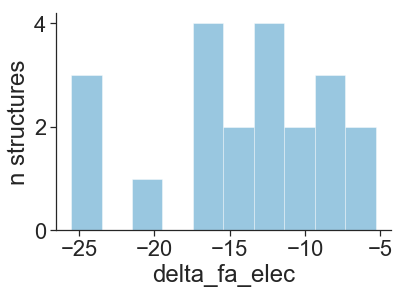

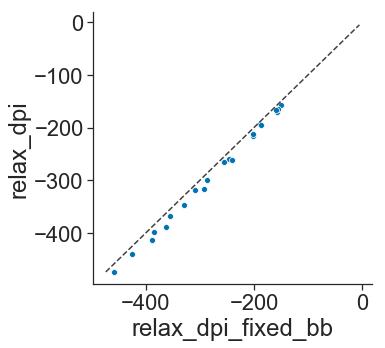

In [15]:
# Read in scores
e_term = 'fa_elec'
e_function = 'opt46A'
group = 'dpi_natives'
relax_types = [
    'relax_dpi',
    'relax_dpi_fixed_bb',
]
all_data_df = pandas.DataFrame()
for relax_type in relax_types:
    score_file = os.path.join(
        resultsdir,
        group,
        e_function,
        relax_type,
        'score.sc'
    )
    df = pandas.read_csv(score_file, skiprows=1, sep='\s+')
    df['pdb'] = df['description'].apply(os.path.basename)
    df.set_index('pdb', inplace=True)
    df.rename(columns={e_term:relax_type}, inplace=True)
    if len(all_data_df) == 0:
        all_data_df = df[[relax_type]].copy()
    else:
        all_data_df = all_data_df.merge(
            df[[relax_type]], left_index=True, right_index=True
        )

# Show differences as a histogram
all_data_df[f'delta_{e_term}'] = \
    all_data_df[relax_types[0]] - all_data_df[relax_types[1]]
sns.distplot(
    all_data_df[f'delta_{e_term}'], kde=False,
    bins=10
)
sns.despine()
plt.ylabel('n structures')
plt.show()
    
# Show data as a scatter plot
plt.figure(figsize=[5,5])
sns.scatterplot(
    x=relax_types[1], y=relax_types[0], data=all_data_df
)
min_val = all_data_df.min().min()
max_val = all_data_df.max().max()
plt.plot(
    [min_val, max_val], [min_val, max_val], ls='--', c='0.25'
)
sns.despine()
plt.show()

In [16]:
all_data_df.sort_values(f'delta_{e_term}').head()

,relax_dpi,relax_dpi_fixed_bb,delta_fa_elec
pdb,,,
3ldy_0001_0001,-413.382,-387.855,-25.527
5zmo_0001_0001,-387.529,-363.026,-24.503
2a66_0001_0001,-316.520,-292.700,-23.820
4hc9_0001_0001,-260.763,-240.120,-20.643
1i3j_0001_0001,-346.620,-329.500,-17.120


Compare total score between energy functions

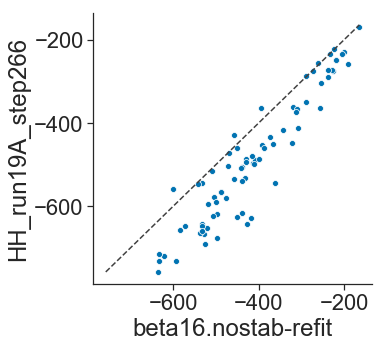

In [17]:
# Read in scores
e_functions = [
    'beta16.nostab-refit',
    'HH_run19A_step266'
]
group = 'beta_nov16_natives'
relax_type = 'design_MonomerDesign2019'
all_data_df = pandas.DataFrame()
for e_function in e_functions:
    score_file = os.path.join(
        resultsdir,
        group,
        e_function,
        relax_type,
        'score.sc'
    )
    df = pandas.read_csv(score_file, skiprows=1, sep='\s+')
    df['pdb'] = df['description'].apply(os.path.basename)
    df.set_index('pdb', inplace=True)
    df.rename(columns={'total_score':e_function}, inplace=True)
    if len(all_data_df) == 0:
        all_data_df = df[[e_function]].copy()
    else:
        all_data_df = all_data_df.merge(
            df[[e_function]], left_index=True, right_index=True
        )

plt.figure(figsize=[5,5])
sns.scatterplot(
    x=e_functions[0], y=e_functions[1], data=all_data_df
)
min_val = all_data_df.min().min()
max_val = all_data_df.max().max()
plt.plot(
    [min_val, max_val], [min_val, max_val], ls='--', c='0.25'
)
sns.despine()
plt.show()

Compute the radius of gyration of structures

In [18]:
score_app_path = '/home/haddox/Rosetta/main/source/bin/score.default.linuxgccrelease'
extra_args = [
    '-set_weights rg 1',
    '-read_only_ATOM_entries'
]
e_functions = [
    'beta16.nostab-refit',
    'HH_run19A_step266',
]
input_pdb_dirs = {
    'beta_nov16_natives' : \
        '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/',
    'beta16.nostab-refit_cart': \
        'results/beta_nov16_natives/beta16.nostab-refit/relax_w_out_symm_cartesian/',
    'beta16.nostab-refit_fixed_bb_cart': \
        'results/beta_nov16_natives/beta16.nostab-refit/relax_w_out_symm_fixed_bb_cartesian/',
    'HH_run19A_step266_cart': \
        'results/beta_nov16_natives/HH_run19A_step266/relax_w_out_symm_cartesian/',
    'HH_run19A_step266_fixed_bb_cart': \
        'results/beta_nov16_natives/HH_run19A_step266/relax_w_out_symm_fixed_bb_cartesian/',
}
for e_function in e_functions:
    (weights_file, flags_file) = e_functions_dict[e_function]
    for (group, input_pdb_dir) in input_pdb_dirs.items():
        pdbs = glob.glob(os.path.join(input_pdb_dir, '*.pdb'))
        output_dir = f'results/rg/{e_function}/{group}/'
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        file_listing_pdbs = os.path.join(output_dir, 'input_pdbs.txt')
        if not os.path.isfile(file_listing_pdbs):
            with open(file_listing_pdbs, 'w') as f:
                for pdb in pdbs:
                    f.write(f'{pdb}\n')
            scores_file_prefix = os.path.join(output_dir, 'score')
            design_utils.compute_score_using_rosettascripts(
                score_app_path=score_app_path,
                weights_file=weights_file,
                flags_file=flags_file,
                output_dir=output_dir,
                extra_args=extra_args,
                scores_file_prefix=scores_file_prefix,
                file_listing_pdbs=file_listing_pdbs
            )

In [19]:
dfs = []
for e_function in ['beta16.nostab-refit']:
    for (group, input_pdb_dir) in input_pdb_dirs.items():
        scores_file = f'results/rg/{e_function}/{group}/score.sc'
        if not os.path.isfile(scores_file):
            continue
        df = pandas.read_csv(scores_file, sep='\s+')
        df['e_function'] = e_function
        df['group'] = group
        df['pdb'] = df['description'].apply(
            lambda x: os.path.basename(x)[:10]
        )
        print(group, len(df))
        dfs.append(df)
df = pandas.concat(dfs, sort=False)
df = df.pivot(index='pdb', columns='group', values='rg')

for col in df.columns.values:
    df[f'delta_rg_{col}'] = df[col] - df['beta_nov16_natives']
    df[f'rg_ratio_{col}'] = df[col] / df['beta_nov16_natives']

beta_nov16_natives 78
beta16.nostab-refit_cart 78
beta16.nostab-refit_fixed_bb_cart 78
HH_run19A_step266_cart 78
HH_run19A_step266_fixed_bb_cart 78


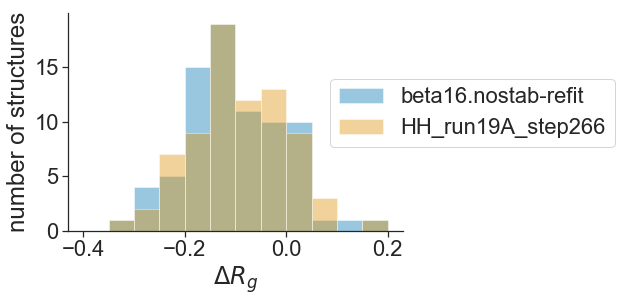

In [20]:
cols = [
    'beta16.nostab-refit_cart',
    'HH_run19A_step266_cart'
]
bins = np.arange(-0.40, 0.22, 0.05)
for col in cols:
    sns.distplot(
        df[f'delta_rg_{col}'], bins=bins, kde=False,
        label = col.replace('_cart', '')
    )
plt.xlabel('$\Delta R_{g}$')
plt.ylabel('number of structures')
plt.legend(bbox_to_anchor=(0.75,0.75))
sns.despine()
plt.show()

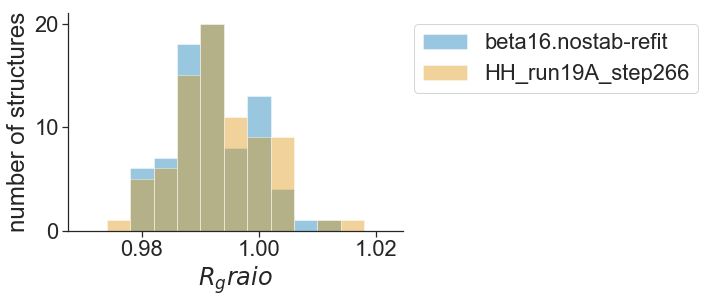

In [21]:
cols = [
    'beta16.nostab-refit_cart',
    'HH_run19A_step266_cart'
]
bins = np.arange(0.97, 1.025, 0.004)
for col in cols:
    sns.distplot(
        df[f'rg_ratio_{col}'], bins=bins,
        label = col.replace('_cart', ''),
        kde=False
    )
plt.xlabel('$R_{g} raio$')
plt.ylabel('number of structures')
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

Measure the RMSD between native structures and relaxed counterparts

In [22]:
# Define path to score application
score_app = '/home/haddox/Rosetta/main/source/bin/score.linuxgccrelease'

# Cycle over input PDBs and energy functions used in the
# relax and compute scores and RMSD values
relax_types = [
    'relax_w_out_symm', 'relax_w_out_symm_long', 
    'relax_w_out_symm_dualspace',
    'relax_w_out_symm_dualspace_const',
    'relax_w_out_symm_cartesian',
    'relax_w_out_symm_cartesian_legacy',
    'relax_w_out_symm_cartesian_const',    
    'design'
]
for group in ['beta_nov16_natives']:
    
    # Make a list of all input PDBs
    native_pdbs = glob.glob(os.path.join(
        native_pdb_dirs[group],
        '*.pdb'
    ))
    for native_pdb in native_pdbs:
        
        native_pdb_basename = os.path.basename(native_pdb)
        
        for e_function in [
            'beta16.nostab-refit',
            'HH_run19A_step266',
        ]:
        
            # Get weights and flags files
            (weights_file, flags_file) = e_functions_dict[e_function]

            # Relax with and without the `-symmetry_definition` flag
            for relax_type in relax_types: 

                # Assemble the command
                pdb_dir = os.path.join(
                    resultsdir,
                    group,
                    e_function,
                    relax_type
                )
                if not os.path.isdir(pdb_dir):
                    continue
                pdb = os.path.join(
                    pdb_dir,
                    native_pdb_basename.replace('.pdb', '_0001.pdb')
                )
                assert os.path.isfile(pdb)
                output_file = os.path.join(
                    pdb_dir,
                    native_pdb_basename.replace('.pdb', '.sc')
                )
                cmd = ' '.join([
                    score_app,
                    f'-s {pdb}',
                    f'-in:file:native {native_pdb}',
                    f'-score:weights {weights_file}',
                    f'@{flags_file}',
                    f'-out:file:scorefile {output_file}'
                ])
                
                # Execute commands using sbatch
                sbatch_file = output_file.replace(
                    '.sc', '.sbatch'
                )
                if not os.path.isfile(sbatch_file):
                    design_utils.WriteSbatchFile(
                        sbatch_file,
                        command=cmd,
                        queue_type='short',
                        memory='2g'
                    )
                    ! sbatch {sbatch_file}

Look at the distribution in RMSD values

In [23]:
# Cycle over input PDBs and energy functions used in the
# relax and read in RMSD values for each relaxed structure
# relative to the corresponding parent structure
dfs = []
relax_types = [
    'relax_w_out_symm', 'relax_w_out_symm_long', 
    'relax_w_out_symm_dualspace',
    'relax_w_out_symm_dualspace_const',
    'relax_w_out_symm_cartesian',
    'relax_w_out_symm_cartesian_legacy',
    'relax_w_out_symm_cartesian_const',
    #'design'
]
for group in ['beta_nov16_natives']:
    for e_function in [
        'beta16.nostab-refit',
        'HH_run19A_step266',
    ]:
        for relax_type in relax_types:

            # Read in RMSD values for each relaxed structure
            pdb_dir = os.path.join(
                resultsdir,
                group,
                e_function,
                relax_type
            )
            if not os.path.isdir(pdb_dir):
                continue
            scores_files = glob.glob(os.path.join(
                pdb_dir,
                '*_0001.sc'
            ))
            for scores_file in scores_files:
                df = pandas.read_csv(scores_file, sep='\s+')
                df['group'] = group
                df['e_function'] = e_function
                df['relax_type'] = relax_type
                dfs.append(df)
                
rmsd_df = pandas.concat(dfs, sort=False)

rms
relax_w_out_symm 0.409 0.416
relax_w_out_symm_long 0.634 0.665
relax_w_out_symm_dualspace 0.639 0.654
relax_w_out_symm_dualspace_const 0.477 0.495
relax_w_out_symm_cartesian 0.659 0.671
relax_w_out_symm_cartesian_legacy 0.915 0.917
relax_w_out_symm_cartesian_const 0.49 0.509


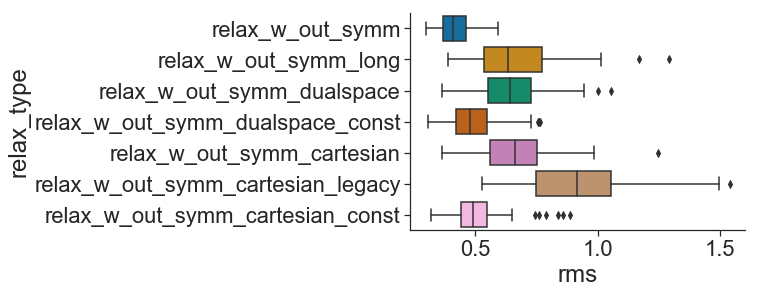

score
relax_w_out_symm -337.704 -328.604
relax_w_out_symm_long -352.041 -337.824
relax_w_out_symm_dualspace -349.615 -338.003
relax_w_out_symm_dualspace_const -344.252 -329.467
relax_w_out_symm_cartesian -352.534 -337.675
relax_w_out_symm_cartesian_legacy -347.783 -325.645
relax_w_out_symm_cartesian_const -348.518 -331.934


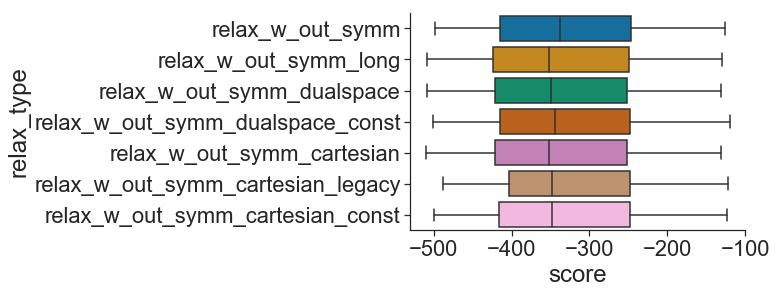

In [24]:
# Plot data
group = 'beta_nov16_natives'
e_function = 'beta16.nostab-refit' # 'HH_run19A_step266' #
metrics = ['rms', 'score']
for metric in metrics:
    print(metric)
    min_val = rmsd_df[metric].min()
    if metric == 'rms':
        max_val = 2
    elif metric == 'score':
        max_val = rmsd_df[rmsd_df[metric] < 0][metric].max()
    else:
        max_val = rmsd_df[metric].max()
    n_bins = 20
    bin_size = (max_val-min_val) / n_bins
    bins = np.arange(min_val-bin_size, max_val+bin_size, bin_size)
    data = rmsd_df[
        (rmsd_df['group'] == group) &
        (rmsd_df['e_function'] == e_function) &
        (rmsd_df[metric] <= max_val)
    ].copy()
    assert sum(data[metric].isnull()) == 0
    for relax_type in relax_types:
        print(
            relax_type,
            round(data[data['relax_type'] == relax_type][metric].median(), 3),
            round(data[data['relax_type'] == relax_type][metric].mean(), 3)
        )
    sns.boxplot(
        x=metric, y='relax_type', data=data
    )
    #plt.legend(bbox_to_anchor=(1,1))
    sns.despine()
    plt.show()

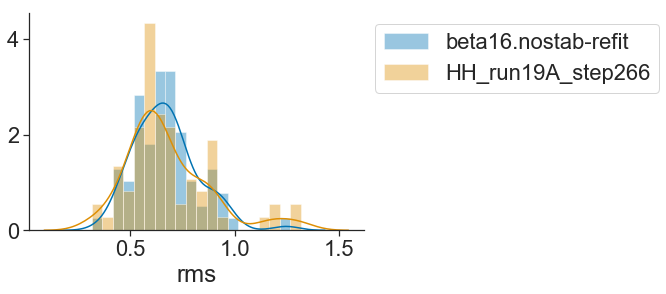

In [25]:
e_functions = ['beta16.nostab-refit', 'HH_run19A_step266']
data = rmsd_df[
    (rmsd_df['e_function'].isin(e_functions)) &
    (rmsd_df['relax_type'] == 'relax_w_out_symm_cartesian')
]
min_val = data['rms'].min()
max_val = data['rms'].max()
nbins = 20
bin_size = (max_val - min_val) / nbins
bins = np.arange(min_val-bin_size, max_val+2*bin_size, bin_size)
for e_function in e_functions:
    data = rmsd_df[
        (rmsd_df['e_function'] == e_function) &
        (rmsd_df['relax_type'] == 'relax_w_out_symm_cartesian')
    ]
    sns.distplot(
        data['rms'], label=e_function, bins=bins
    )
    
plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

In [26]:
group = 'beta_nov16_natives'
e_function = 'beta16.nostab-refit'
relax_type = 'relax_w_out_symm'
data = rmsd_df[
    (rmsd_df['group'] == group) &
    (rmsd_df['e_function'] == e_function) &
    (rmsd_df['relax_type'] == relax_type) &
    (rmsd_df['rms'].between(0.45, 0.55))
]
data.head()

,SCORE:,score,fa_atr,fa_rep,fa_sol,fa_intra_atr_xover4,fa_intra_rep_xover4,fa_intra_sol_xover4,lk_ball,lk_ball_iso,...,gdtmm4_3,gdtmm7_4,irms,maxsub,maxsub2.0,rms,description,group,e_function,relax_type
0,SCORE:,-332.215,-533.270,51.718,358.247,-33.251,10.669,22.707,196.178,-204.848,...,1.0,1.0,0.0,106.0,106.0,0.463,2frg_clean_0001_0001_0001,beta_nov16_natives,beta16.nostab-refit,relax_w_out_symm
0,SCORE:,-421.041,-776.126,71.831,541.437,-46.706,14.351,32.535,289.760,-307.842,...,1.0,1.0,0.0,131.0,131.0,0.536,1t3y_clean_0001_0001_0001,beta_nov16_natives,beta16.nostab-refit,relax_w_out_symm
0,SCORE:,-420.083,-784.248,73.003,552.603,-40.750,13.129,30.236,282.865,-308.916,...,1.0,1.0,0.0,130.0,130.0,0.458,1jf8_clean_0001_0001_0001,beta_nov16_natives,beta16.nostab-refit,relax_w_out_symm
0,SCORE:,-323.629,-613.795,60.314,460.168,-30.085,8.884,19.626,244.860,-259.555,...,1.0,1.0,0.0,107.0,107.0,0.485,2pvb_clean_0001_0001_0001,beta_nov16_natives,beta16.nostab-refit,relax_w_out_symm
0,SCORE:,-490.013,-910.661,90.147,586.858,-50.606,15.301,35.539,317.728,-332.221,...,1.0,1.0,0.0,150.0,150.0,0.491,1z2u_clean_0001_0001_0001,beta_nov16_natives,beta16.nostab-refit,relax_w_out_symm


In [27]:
groups = [
    'beta_nov16_natives',
    'beta16.nostab-refit_cart',
    'beta16.nostab-refit_fixed_bb_cart',
    'HH_run19A_step266_cart',
    'HH_run19A_step266_fixed_bb_cart',
]
e_function = 'HH_run19A_step266' # 'beta16.nostab-refit'
dfs = []
for group in groups:
    f = f'results/rg/{e_function}/{group}/score.sc'
    df = pandas.read_csv(f, sep='\s+')
    df['group'] = group
    df['pdb'] = df['description'].apply(
        lambda x: os.path.basename(x)[:4]
    )
    del df['SCORE:']
    dfs.append(df)
df = pandas.concat(dfs, sort=False)

In [28]:
pandas.set_option('display.max_columns', None)

In [29]:
cols = [
    'score',
    'cart_bonded',
    'fa_atr', 'fa_rep',
    'fa_elec',
    'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb',
    #'total_sol',
    'fa_sol',
    'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
    'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi',
    'fa_intra_atr_xover4', 'fa_intra_rep_xover4', 'fa_intra_elec', 'fa_intra_sol_xover4',
    'hxl_tors',
    'omega', 'p_aa_pp', 'rama_prepro',
    'ref', 'dslf_fa13', 'group', 'pdb', 'description',
]
df[df['pdb'] == '1jf8'][cols].head()

,score,cart_bonded,fa_atr,fa_rep,fa_elec,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,fa_sol,lk_ball,lk_ball_iso,lk_ball_bridge,lk_ball_bridge_uncpl,fa_dun_rot,fa_dun_dev,fa_dun_semi,fa_intra_atr_xover4,fa_intra_rep_xover4,fa_intra_elec,fa_intra_sol_xover4,hxl_tors,omega,p_aa_pp,rama_prepro,ref,dslf_fa13,group,pdb,description
2,-398.306,75.924,-785.656,95.899,-281.375,-24.150,-39.196,-24.264,-60.538,521.487,303.430,-339.703,-1.341,-9.945,64.308,10.621,129.754,-44.744,16.786,-42.287,30.281,22.215,5.169,-20.373,15.749,-30.1,0.0,beta_nov16_natives,1jf8,results/rg/HH_run19A_step266/beta_nov16_native...
3,-487.366,77.030,-847.466,129.013,-317.068,-27.640,-42.366,-29.747,-62.375,535.542,315.557,-357.015,-1.283,-9.822,60.542,8.593,127.562,-45.261,18.355,-47.845,32.406,23.089,2.452,-27.338,14.244,-30.1,0.0,beta16.nostab-refit_cart,1jf8,results/rg/HH_run19A_step266/beta16.nostab-ref...
68,-445.584,72.352,-801.758,105.488,-308.236,-25.912,-39.198,-28.282,-60.972,531.281,312.905,-345.439,-1.287,-9.640,60.364,7.365,126.886,-44.267,17.085,-46.434,31.927,22.090,2.688,-21.863,13.634,-30.1,0.0,beta16.nostab-refit_fixed_bb_cart,1jf8,results/rg/HH_run19A_step266/beta16.nostab-ref...
58,-495.148,87.602,-841.972,103.097,-327.357,-27.036,-42.693,-26.646,-62.106,536.644,315.615,-355.841,-1.297,-10.049,60.806,10.079,129.189,-45.237,17.339,-46.750,32.258,23.275,3.295,-26.863,16.002,-30.1,0.0,HH_run19A_step266_cart,1jf8,results/rg/HH_run19A_step266/HH_run19A_step266...
66,-454.993,80.866,-801.426,90.149,-313.165,-26.454,-39.175,-26.743,-61.281,535.190,310.032,-346.159,-1.406,-10.211,60.170,8.925,127.033,-44.706,16.074,-46.552,31.942,22.222,3.532,-21.740,14.248,-30.1,0.0,HH_run19A_step266_fixed_bb_cart,1jf8,results/rg/HH_run19A_step266/HH_run19A_step266...


In [30]:
groups = [
    #'beta_nov16_natives',
    'beta16.nostab-refit_fixed_bb_cart',
    'beta16.nostab-refit_cart',
    #'HH_run19A_step266_fixed_bb_cart',
    #'HH_run19A_step266_cart',
]
pdbs = list(set(df['pdb']))
score_terms = cols[:-3]
delta_dict = {
    key : []
    for key in score_terms + ['pdb']
}
for pdb in pdbs:
    delta_dict['pdb'].append(pdb)
    for score_term in score_terms:
        val1 = float(df[
            (df['group'] == groups[0]) &
            (df['pdb'] == pdb)
        ][score_term])
        val2 = float(df[
            (df['group'] == groups[1]) &
            (df['pdb'] == pdb)
        ][score_term])
        delta_dict[score_term].append(val2-val1)

delta_df = pandas.DataFrame(delta_dict)
delta_df = delta_df[delta_df['score'] < 200]

In [31]:
delta_df[delta_df['score'].between(-65,-50)]

,score,cart_bonded,fa_atr,fa_rep,fa_elec,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,fa_sol,lk_ball,lk_ball_iso,lk_ball_bridge,lk_ball_bridge_uncpl,fa_dun_rot,fa_dun_dev,fa_dun_semi,fa_intra_atr_xover4,fa_intra_rep_xover4,fa_intra_elec,fa_intra_sol_xover4,hxl_tors,omega,p_aa_pp,rama_prepro,ref,dslf_fa13,pdb
5,-50.360,6.116,-33.863,20.838,-18.783,-4.481,-2.149,-1.858,-4.383,-1.472,2.743,-9.266,-0.118,-0.365,1.811,0.670,-1.191,-0.315,1.220,0.097,-0.017,1.655,-1.842,-3.949,-1.328,0.0,0.000,2nt4
15,-51.994,-3.697,-13.238,-0.636,-13.832,0.602,-1.955,-3.011,-1.920,-3.021,-1.479,-0.335,0.317,2.090,-4.167,0.042,-1.064,0.427,0.394,0.301,-0.320,-0.026,-0.327,-7.117,-1.012,0.0,1.237,1zlb
54,-50.747,1.465,-27.697,19.908,-16.245,-7.665,-2.890,-2.134,-2.025,-2.553,3.095,-5.126,0.030,0.250,-0.360,0.838,2.770,-0.008,1.002,-2.292,0.270,0.085,-3.526,-5.504,-2.317,0.0,0.000,3ey6
56,-50.025,1.600,-46.258,29.638,-10.170,0.227,-4.378,-0.412,-3.912,2.678,4.761,-13.031,0.075,0.885,0.067,-0.577,-2.352,-0.881,5.019,-3.809,0.883,-2.379,-2.584,-5.772,0.164,0.0,0.614,1r2m
63,-56.320,0.378,-27.136,13.128,-4.948,-1.019,-1.980,-5.658,-1.399,-10.126,-1.675,-2.524,-0.200,-1.485,-0.280,-0.679,1.405,-1.439,1.959,-11.066,3.021,0.183,0.031,-3.351,-1.280,0.0,0.000,1z2u


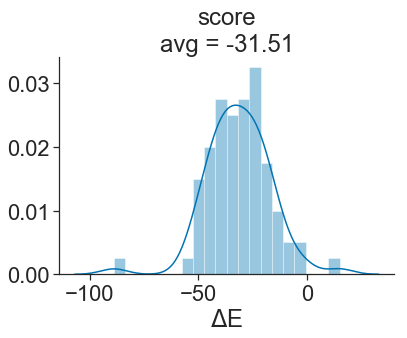

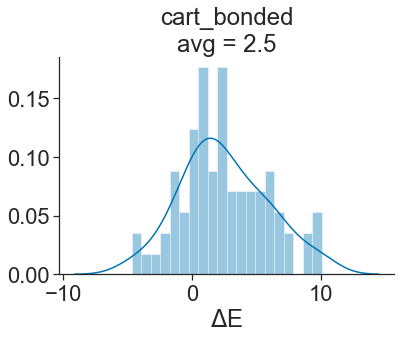

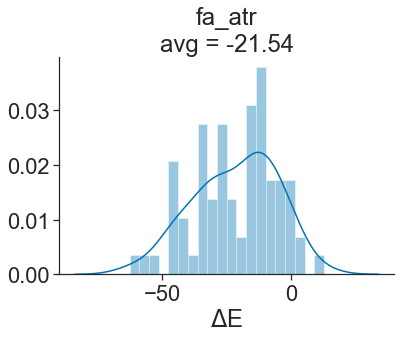

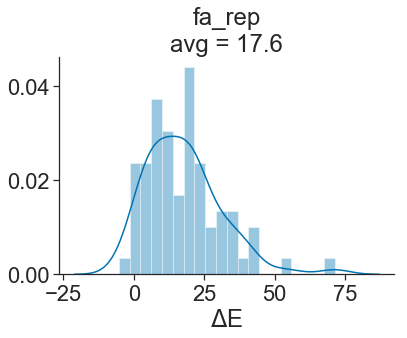

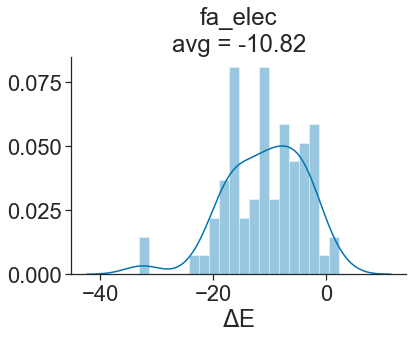

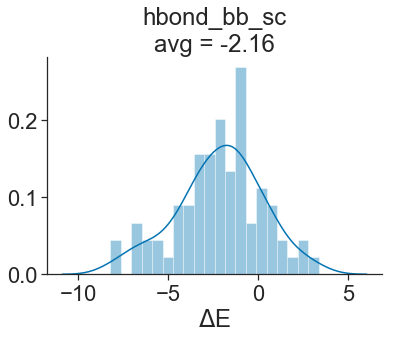

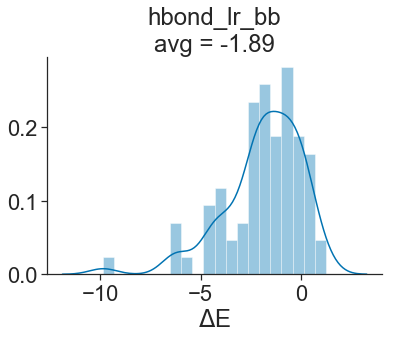

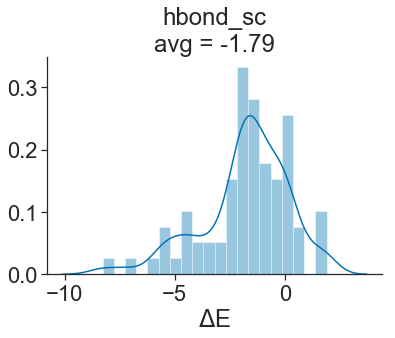

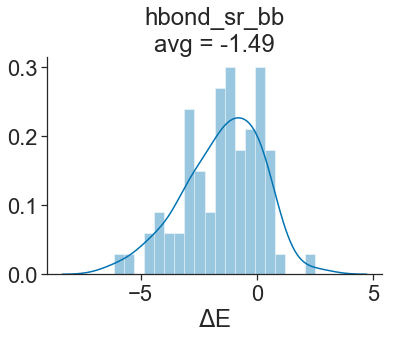

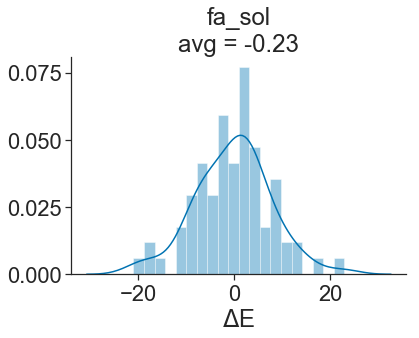

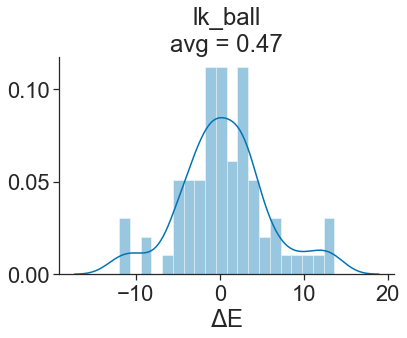

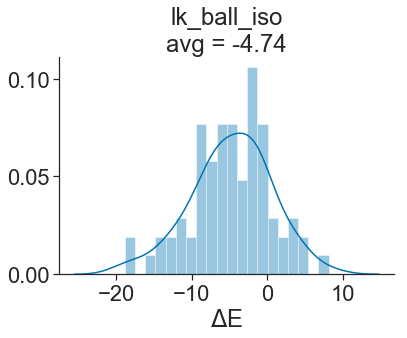

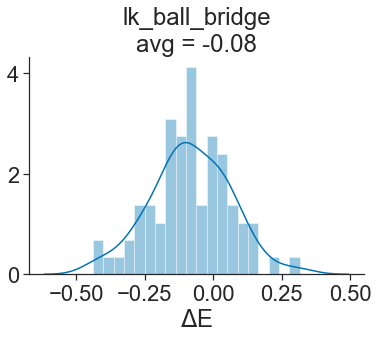

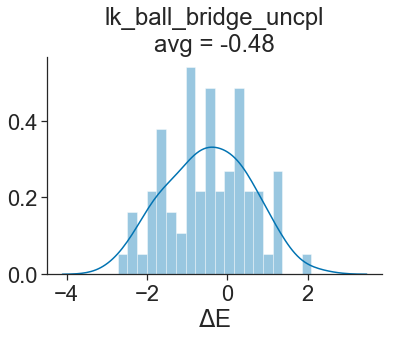

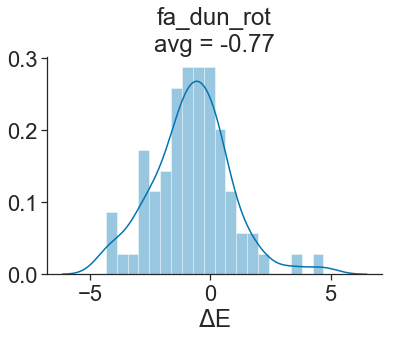

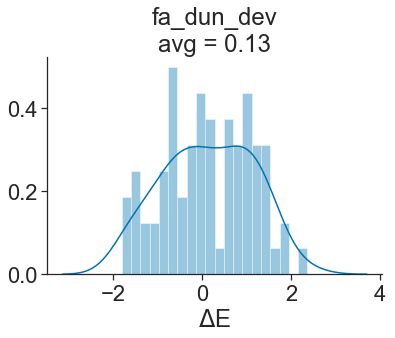

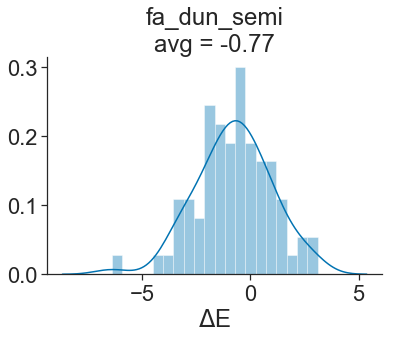

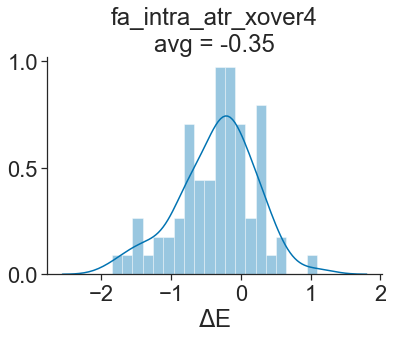

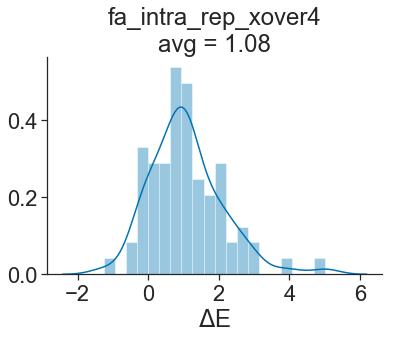

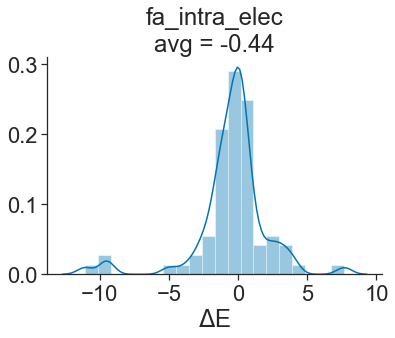

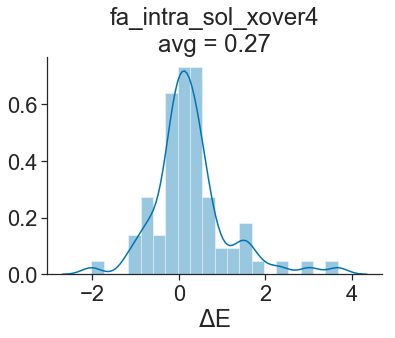

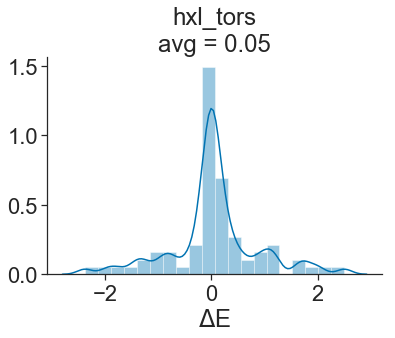

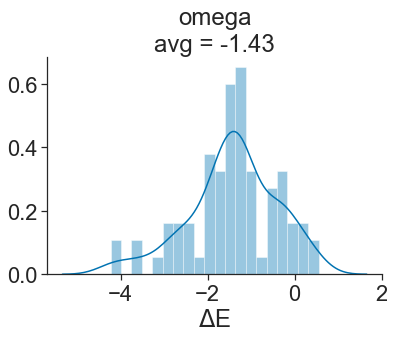

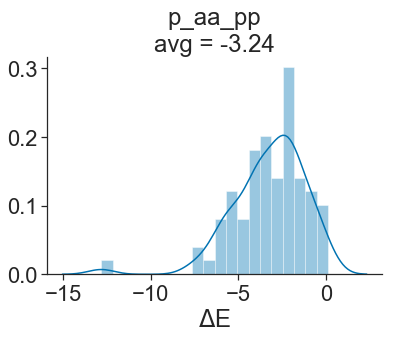

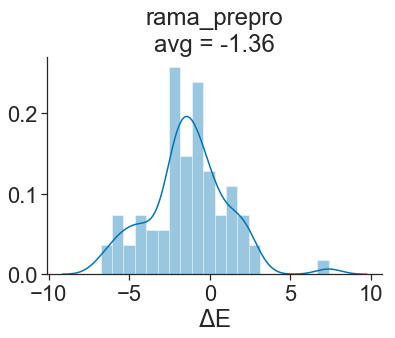

/home/haddox/.conda/envs/high_throughput_design_for_E_function_opt/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/haddox/.conda/envs/high_throughput_design_for_E_function_opt/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


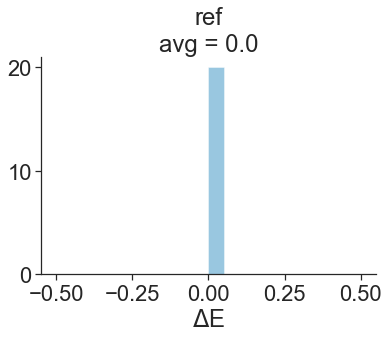

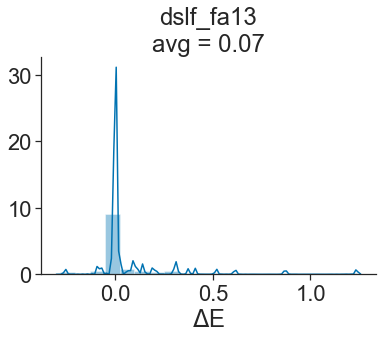

In [32]:
metrics = [
    'score',
    'fa_atr', 'fa_rep',
    'fa_elec', 'fa_sol', 'lk_ball',
    'cart_bonded'
]
for metric in score_terms:
    sns.distplot(delta_df[metric], bins=20)
    plt.title(
        f'{metric}\navg = {round(delta_df[metric].mean(), 2)}'
    )
    plt.xlabel('$\Delta$E')
    sns.despine()
    plt.show()

## Design natives using each energy function

In [33]:
# Define input variables
rosetta_path = '/home/haddox/Rosetta/main/source/bin/rosetta_scripts.default.linuxgccrelease'
database_path = '/home/haddox/Rosetta/main/database/'
design_scripts_dict = {
    'design' : 'scripts/design_scripts/fast_design_with_surface_and_ss_aa_comp_3.xml',
    #'design_polyval' : 'scripts/design_scripts/fast_design_with_surface_and_ss_aa_comp_3_polyval.xml',
}
surface_aa_comp_files = {
    #'hard_layer' : 'scripts/design_scripts/total_hydrophobicity_4.comp',
    'soft_layer_10' : 'scripts/design_scripts/total_hydrophobicity.comp',
    #'no_layer' : 'scripts/design_scripts/no_constraints.comp',
}
e_functions = [
#     'talaris2014', 'ref2015', #'beta_nov16',
    'beta16.nostab-refit',
#     'HH_run19A_step266',
#     'HH_run19A_step266_dd2_elec_5_no_scale',
#     'HH_run19A_step266_dd2_elec_5g',
#     'HH_run19A_step266_dd2_elec_5h',
#     'HH_run19A_step266_dd_elec_5_no_scale2',
#     'HH_run19A_step266_dd_elec_5g',
#     'HH_run19A_step266_dd_elec_5h',
    
#     'HH_run23A_step384',
#     'HH_run23A_step384_1b',
#     'HH_run23B_sol_elec_dd2_simple_step384',
#     'HH_run23B_sol_elec_dd2_simple_step384_1a',
#     'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
    #'HH_run25B_step311_1d',
    #'HH_run26A_step258_1d',
    #'HH_run25B_step311_final',
    'HH_run26B_step129_final',
]

# Cycle over groups and energy functions and make designs
groups = [
    'beta_nov16_natives',
    #'original_ppi_natives',
    #'lmbw_af2_des',
]
relaxscript = 'MonomerDesign2019'
design_protocol = 'design' # 'design_polyval' # 
design_script = design_scripts_dict[design_protocol]
for (comp_protocol, surface_aa_comp_file) in surface_aa_comp_files.items():
    for group in groups:
        pdbs = glob.glob(os.path.join(
            native_pdb_dirs[group],
            '*.pdb'
        ))
        for e_function in e_functions:

            # Get weights and flags files for the given energy function
            (weights_file, flags_file) = e_functions_dict[e_function]

            # Make designs if the output directory doesn't already exist
            output_dir = os.path.join(
                resultsdir,
                group,
                e_function,
                f'{design_protocol}_{relaxscript}_{comp_protocol}/'
            )
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
                print(output_dir)
                cmds = []
                for pdb in pdbs:
                    cmd = ' '.join([
                        rosetta_path,
                        f'-database {database_path}',
                        f'-in:file:s {pdb}',
                        f'-parser:protocol {design_script}',
                        f'-out:prefix {output_dir}',
                        f'@{flags_file}',
                        '-crystal_refine',
                        #'-ignore_unrecognized_res',
                        #'-ignore_waters',
                        '-read_only_ATOM_entries True',
                        '-multi_cool_annealer 10',
                        '-ex1 -ex2aro -linmem_ig 10',
                        '-parser:script_vars',
                        f'weights_file={weights_file}',
                        f'surface_aa_comp_file={surface_aa_comp_file}',
                        f'relaxscript={relaxscript}'
                    ])
                    cmds.append(cmd)
                command_file = os.path.join(
                    output_dir,
                    'commands.txt'
                )
                with open(command_file, 'w') as f:
                    for cmd in cmds:
                        f.write(f'{cmd}\n')

                # Execute commands using sbatch
                sbatch_file = os.path.join(
                    output_dir,
                    'design.sbatch'
                )
                design_utils.WriteSbatchFile(
                    sbatch_file,
                    command_file_name=command_file,
                    queue_type='long',
                    memory='10g'
                )
                ! sbatch -a 1-$(cat {command_file}|wc -l) {sbatch_file}

## Compute the distribution of inter-atomic distances in relaxed and designed structures from above

In [60]:
e_functions = [
    #'talaris2013', 
    # 'talaris2014', 'ref2015', #'beta_nov16',
    'beta16.nostab-refit',
    # 'beta16_plus_lj_changes',
    'beta16_plus_hpsc_lj_changes',
    
    # 'HH_run19A_step266',
]

relax_types = [
    # 'relax_w_out_symm', #'relax_w_out_symm_long',
    #'relax_w_out_symm_dualspace',
    #'relax_w_out_symm_dualspace_const',
    'relax_w_out_symm_cartesian',
    #'relax_w_out_symm_cartesian_legacy',
    #'relax_w_out_symm_cartesian_const',
    #'design',
    # 'design_MonomerDesign2019',
    # 'design_MonomerDesign2019_hard_layer',
    # 'design_MonomerDesign2019_no_layer',
    # 'design_MonomerDesign2019_soft_layer_10',
    #'design_legacy',
    # 'relax_dpi',
]

for analyze_all_atoms in [True, False]:
    for group in ['beta_nov16_natives_validation']: # native_pdb_dirs:

        # Make a list of input PDBs for the current group
        native_pdbs = glob.glob(os.path.join(
            native_pdb_dirs[group],
            '*.pdb'
        ))

        # Define path to reference file for current group
        ref_file = os.path.join(
            resultsdir,
            group,
            'distr_new_atom_typing.REF'
        )
        if ('mpnn' in group) or ('rf_v00' in group) or ('lmbw' in group):
            ref_file = os.path.join(
                resultsdir,
                'beta_nov16_natives',
                'distr_new_atom_typing.REF'
            )
        if group == 'dpi_natives':
            ref_file = ref_file.replace(
                '_new_atom_typing.REF',
                '.REF'
            )
        if analyze_all_atoms:
            ref_file = ref_file.replace(
                '.REF', '_all_atoms.REF'
            )

        # Loop over energy functions and relax protocols and
        # compute distance distributions for group of relaxed
        # structures
        for e_function in e_functions:
            for relax_type in relax_types:

                print(group, e_function, relax_type)
                
                # Make a list of relaxed PDBs
                output_dir = os.path.join(
                    resultsdir,
                    group,
                    e_function,
                    relax_type + '/'
                )
                if not os.path.isdir(output_dir):
                    continue
                pdbs = glob.glob(os.path.join(output_dir, '*.pdb'))
                if len(pdbs) == 0:
                    continue

                # Make sure that the number of relaxed PDBs is the
                # same as the number of native PDBs in the same group
                if len(pdbs) != len(native_pdbs):
                    print(output_dir)
                    print(f"{len(pdbs)} != {len(native_pdbs)}")
                    continue
                    raise ValueError(
                        f"{len(pdbs)} != {len(native_pdbs)}"
                    )

                # Compute the distribution of inter-atomic
                # distances in the above PDBs
                cmd = ' '.join([
                    'python',
                    'scripts/distdstr_0.3.py',
                    ' '.join(pdbs),
                    f'--ref {ref_file}',
                    f'--output_dir {output_dir}',
                    '--plot',
                    '--verbose',
                    '--use_new_atom_typing',
                    '--allow_missing_atom_pairs',
                ])
                cmd = 'source activate optE\n' \
                    + cmd
                sbatch_file = os.path.join(
                    output_dir,
                    f'distdstr_plot_new_atom_typing.sbatch'
                )
                if group == 'dpi_natives':
                    cmd = cmd.replace(
                        '--use_new_atom_typing',
                        '--min_seq_sep 1'
                    )
                    sbatch_file = sbatch_file.replace(
                        '_new_atom_typing.sbatch',
                        '.sbatch'
                    )
                if analyze_all_atoms:
                    cmd += ' --analyze_all_atoms'
                    sbatch_file = sbatch_file.replace(
                        '.sbatch', '_all_atoms.sbatch'
                    )
                if not os.path.isfile(sbatch_file):
                    print(
                        group,
                        e_function,
                        relax_type,
                        f'all_atoms:{analyze_all_atoms}'
                    )
                    design_utils.WriteSbatchFile(
                        sbatch_file,
                        command=cmd,
                        queue_type='cpu',
                        memory='4g'
                    )
                    ! sbatch {sbatch_file}

beta_nov16_natives_validation beta16.nostab-refit relax_w_out_symm_cartesian
beta_nov16_natives_validation beta16_plus_hpsc_lj_changes relax_w_out_symm_cartesian
beta_nov16_natives_validation beta16.nostab-refit relax_w_out_symm_cartesian
beta_nov16_natives_validation beta16_plus_hpsc_lj_changes relax_w_out_symm_cartesian
beta_nov16_natives_validation beta16_plus_hpsc_lj_changes relax_w_out_symm_cartesian all_atoms:False
Submitted batch job 17472929


Also compute distance distributions for pools of mini-protein designs

In [43]:
base_pdb_dir = os.path.join(
    '../compare_design_protocols/results/',
    'standard_with_extra_rotamers/'
)
e_functions = [
    'talaris2014',
    'ref2015',
    'beta_nov16',
    'beta16.nostab-refit',
    'HH_run9_step282',
    'HH_run18C_step286',
    'HH_run18E_step147',
    'HH_run18D_step886_modified6f',
]
topologies = [
    '3h_1018',
    'EEHEE_43aa',
    'EEHEE_57aa',
    'EHEE_40aa',
    'EHEE_65aa',
    'HEEHE_65aa',
    'HHH_43aa',
    '4h'
]
relax_scripts = [
    'custom_default',
    'MonomerDesign2019'
]
for analyze_all_atoms in [True, False]:
    for e_function in e_functions:
        for relax_script in relax_scripts:

            # Make a list of input PDBs for the current group
            pdbs = []
            for topology in topologies:
                if topology == '4h':
                    pdb_dir = os.path.join(
                        base_pdb_dir,
                        'from_Brian',
                        topology,
                        relax_script,
                        e_function,
                        'cart_relax',
                        e_function
                    )
                else:
                    pdb_dir = os.path.join(
                        base_pdb_dir,
                        'new',
                        topology,
                        relax_script,
                        e_function,
                        'cart_relax',
                        e_function
                    )
                pdbs += glob.glob(os.path.join(pdb_dir, '*.pdb'))
            
            if len(pdbs) == 0:
                continue
                
            # Define path to reference file for current group
            ref_file = os.path.join(
                resultsdir,
                'beta_nov16_natives',
                'distr_new_atom_typing.REF'
            )
            if analyze_all_atoms:
                ref_file = ref_file.replace(
                    '.REF', '_all_atoms.REF'
                )

            # Compute the distribution of inter-atomic distances
            # in the above PDBs
            output_dir = os.path.join(
                resultsdir,
                f'miniprotein_designs_{relax_script}',
                e_function
            )
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            cmd = ' '.join([
                'python',
                'scripts/distdstr_0.3.py',
                ' '.join(pdbs),
                f'--ref {ref_file}',
                f'--output_dir {output_dir}',
                '--plot',
                '--verbose',
                '--allow_missing_atom_pairs',
                '--use_new_atom_typing'
            ])
            sbatch_file = os.path.join(
                output_dir,
                f'distdstr_plot_new_atom_typing.sbatch'
            )
            if analyze_all_atoms:
                cmd += ' --analyze_all_atoms'
                sbatch_file = sbatch_file.replace(
                    '.sbatch', '_all_atoms.sbatch'
                )
            if not os.path.isfile(sbatch_file):
                print(e_function, relax_script, len(pdbs))
                design_utils.WriteSbatchFile(
                    sbatch_file,
                    command=cmd,
                    queue_type='short',
                    memory='4g'
                )
                ! sbatch {sbatch_file}

In [44]:
base_pdb_dir = os.path.join(
    '../compare_design_protocols/results/',
    'standard_with_extra_rotamers/'
)
e_functions = [
    'talaris2014',
    'ref2015',
    #'beta_nov16',
    'beta16.nostab-refit',
    'HH_run9_step282',
    'HH_run18C_step286',
    'HH_run18E_step147'
]
topologies = [
    '3h_1018',
    'EEHEE_43aa',
    'EEHEE_57aa',
    'EHEE_40aa',
    'EHEE_65aa',
    'HEEHE_65aa',
    'HHH_43aa'
]
for e_function in e_functions:
    
    # Make a list of input PDBs for the current group
    pdbs = []
    for topology in topologies:
        pdb_dir = os.path.join(
            base_pdb_dir,
            'new',
            topology,
            'MonomerDesign2019',
            e_function,
            #'cart_relax',
            #e_function
        )
        pdbs += glob.glob(os.path.join(pdb_dir, '*.pdb'))
        print(e_function, topology, len(pdbs))

talaris2014 3h_1018 287
talaris2014 EEHEE_43aa 520
talaris2014 EEHEE_57aa 658
talaris2014 EHEE_40aa 781
talaris2014 EHEE_65aa 912
talaris2014 HEEHE_65aa 1085
talaris2014 HHH_43aa 1230
ref2015 3h_1018 287
ref2015 EEHEE_43aa 520
ref2015 EEHEE_57aa 658
ref2015 EHEE_40aa 781
ref2015 EHEE_65aa 912
ref2015 HEEHE_65aa 1085
ref2015 HHH_43aa 1230
beta16.nostab-refit 3h_1018 287
beta16.nostab-refit EEHEE_43aa 520
beta16.nostab-refit EEHEE_57aa 658
beta16.nostab-refit EHEE_40aa 781
beta16.nostab-refit EHEE_65aa 912
beta16.nostab-refit HEEHE_65aa 1085
beta16.nostab-refit HHH_43aa 1230
HH_run9_step282 3h_1018 287
HH_run9_step282 EEHEE_43aa 475
HH_run9_step282 EEHEE_57aa 581
HH_run9_step282 EHEE_40aa 704
HH_run9_step282 EHEE_65aa 835
HH_run9_step282 HEEHE_65aa 989
HH_run9_step282 HHH_43aa 1134
HH_run18C_step286 3h_1018 219
HH_run18C_step286 EEHEE_43aa 408
HH_run18C_step286 EEHEE_57aa 524
HH_run18C_step286 EHEE_40aa 646
HH_run18C_step286 EHEE_65aa 777
HH_run18C_step286 HEEHE_65aa 950
HH_run18C_step28

Make directories with symbolic links to stable and unstable designs from Gabe's rd3 and rd4 libraries

In [45]:
def get_topology(name):
    """order of elif statements important for EEHEE and EHEE"""
    if 'HHH' in name:
        return 'HHH'
    elif 'HEEH' in name:
        return 'HEEH'
    elif 'EEHEE' in name:
        return 'EEHEE'
    elif 'EHEE' in name:
        return 'EHEE'
    else:
        raise ValueError(name)

# Read in stability scores
dfs = []
for rd in ['rd3', 'rd4']:
    f = f'/home/haddox/Rocklin_2017_supp_info/aan0693_SI_datasets/{rd}_stability_scores'
    df = pandas.read_csv(f, sep='\s+')
    df['rd'] = rd
    df = df[
        (df['name'].str.contains(rd)) &
        (df['name'].str.endswith('.pdb'))
    ]
    dfs.append(df)
df = pandas.concat(dfs, sort=False)
df['stability'] = df['stabilityscore'].apply(
    lambda x: 'stable' if x > 1.0 else 'unstable'
)
df['topology'] = df['name'].apply(lambda x: get_topology(x))

# Get paths to PDBs
pdb_dir = '/home/haddox/Rocklin_2017_supp_info/aan0693_designed-PDB-files/'
df['pdb_path'] = df.apply(
    lambda row: os.path.join(
        pdb_dir,
        row['rd'],
        row['name']
    ),
    axis=1
)
df['pdb_exists'] = df['pdb_path'].apply(lambda x: os.path.isfile(x))
assert len(df) == sum(df['pdb_exists'])

# For each topology, make a directory with symbolic links to
# stable and unstable designs
for topology in ['HHH', 'HEEH', 'EHEE', 'EEHEE']:
    for stability in ['stable', 'unstable']:
        data = df[
            (df['topology'] == topology) &
            (df['stability'] == stability)
        ]
        pdbs = list(data['pdb_path'])
        output_dir = os.path.join(
            resultsdir,
            'designs_from_others',
            f'Rocklin_{topology}_{stability}/'
        )
        print(output_dir, len(pdbs))
        if not os.path.isdir(output_dir):
            print(output_dir)
            os.makedirs(output_dir)
            for pdb in pdbs:
                new_pdb = os.path.join(
                    output_dir,
                    os.path.basename(pdb)
                )
                os.symlink(pdb, new_pdb)

results/designs_from_others/Rocklin_HHH_stable/ 1041
results/designs_from_others/Rocklin_HHH_unstable/ 209
results/designs_from_others/Rocklin_HEEH_stable/ 60
results/designs_from_others/Rocklin_HEEH_unstable/ 2770
results/designs_from_others/Rocklin_EHEE_stable/ 430
results/designs_from_others/Rocklin_EHEE_unstable/ 820
results/designs_from_others/Rocklin_EEHEE_stable/ 811
results/designs_from_others/Rocklin_EEHEE_unstable/ 2019


Make directories with symbolic links to Gabe's rd3 and rd4 designs

In [46]:
pdb_dir = '/home/haddox/2018/analyze_calibrated_stability_data/results/constrained_relax/beta16.nostab-refit/Rocklin_2017_Science/'
topologies = ['HHH', 'EHEE', 'EEHEE', 'HEEH']
for topology in topologies:
    # Make a list of rd3 and rd4 PDBs for the given
    # topology
    pdbs = glob.glob(os.path.join(
        pdb_dir,
        f'{topology}_rd3_*.pdb'
    ))
    pdbs += glob.glob(os.path.join(
        pdb_dir,
        f'{topology}_rd4_*.pdb'
    ))
    if topology == 'EHEE':
        pdbs = [pdb for pdb in pdbs if 'EEHEE' not in pdb]

    print(topology, len(pdbs))

    # Make sym links for each PDB file
    output_dir = os.path.join(
        resultsdir,
        'designs_from_others',
        f'Rocklin_{topology}'
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
        for pdb in pdbs:
            new_pdb = os.path.join(
                output_dir,
                os.path.basename(pdb)
            )
            os.symlink(pdb, new_pdb)

HHH 0
EHEE 0
EEHEE 0
HEEH 0


Make symbolic links to Ali's designs

In [47]:
pdb_dirs = {
    'no_PPI' : '/home/etemadih/projects/worm/remote_projects/oligomers/hugh__score_functions/no_PPI/filtered_scores_no_PPI/',
    'with_PPI' : '/home/etemadih/projects/worm/remote_projects/oligomers/hugh__score_functions/with_PPI/filtered_scores_with_PPI/',
    'no_PPI_new' : '/home/etemadih/projects/worm/remote_projects/oligomers/hugh__score_functions/no_PPI/filtered_scores_no_PPI_beta20/',
    'with_PPI_new' : '/home/etemadih/projects/worm/remote_projects/oligomers/hugh__score_functions/with_PPI/filtered_scores_with_PPI/beta20_new/',
}
e_functions = ['beta16', 'beta20']
for (group, pdb_dir) in pdb_dirs.items():
    for e_function in e_functions:
        pdbs = [
            pdb for pdb in glob.glob(os.path.join(pdb_dir, '*.pdb'))
            if e_function in pdb
        ]
        if len(pdbs) == 0:
            continue
        print(group, e_function, len(pdbs))

        # Make sym links for each PDB file
        output_dir = os.path.join(
            resultsdir,
            'designs_from_others',
            f'Ali_{group}_{e_function}'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
            for pdb in pdbs:
                new_pdb = os.path.join(
                    output_dir,
                    os.path.basename(pdb)
                )
                os.symlink(pdb, new_pdb)

Make symbolic links to David Kim's designs

In [48]:
pdbs = glob.glob('/home/dekim/small_beta_barrels/DESIGNS/score_func_test/*/start_*.pdb')
output_dir = os.path.join(
    resultsdir,
    'designs_from_others',
    'mini_beta_barrel_designs_18F',
)
if not os.path.isdir(output_dir):
    print(f"Copying {len(pdbs)} PDBs")
    os.makedirs(output_dir)
    for (i, pdb) in enumerate(pdbs):
        new_pdb = os.path.join(
            output_dir,
            f'{i}_{os.path.basename(pdb)}'
        )
        os.symlink(pdb, new_pdb)

Make symbolic links to Anna and Chris's designs

In [49]:
design_e_functions = ['beta_scoring', 'hugh_scoring']
for design_e_function in design_e_functions:
    pdbs = glob.glob(f'/home/laukoa/Projects/serine_hydrolase/design/design_triad/round_3/out/design_rp1/*{design_e_function}*.pdb')
    output_dir = os.path.join(
        resultsdir,
        'designs_from_others',
        f'NTF2_AC_{design_e_function}',
    )
    if not os.path.isdir(output_dir):
        print(design_e_function, f"Copying {len(pdbs)} PDBs")
        os.makedirs(output_dir)
        for (i, pdb) in enumerate(pdbs):
            new_pdb = os.path.join(
                output_dir,
                f'{i}_{os.path.basename(pdb)}'
            )
            os.symlink(pdb, new_pdb)

Extract chain A from Jilliane's and Sidney's LOCKR-key designs

In [50]:
import pyrosetta
import pyrosetta.rosetta
init_flags = ' '.join([
    '-mute all', '-mute core', '-mute protocols',
    '-detect_disulf False', '-read_only_ATOM_entries',
])
pyrosetta.init(init_flags)

In [51]:
design_dirs = [
    'lockr_key_beta16', 'lockr_key_19A',
]
for design_dir in design_dirs:
    output_dir = f'results/designs_from_others/{design_dir}'
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    pdbs = glob.glob(f'data/designs_from_others/{design_dir}/*.pdb')
    for pdb in pdbs:
        output_pdb = os.path.join(
            output_dir,
            os.path.basename(pdb).replace('.pdb', '_chainA.pdb')
        )
        if not os.path.isfile(output_pdb):
            pose = pyrosetta.pose_from_pdb(pdb)
            chains = pose.split_by_chain()
            for chain in chains:
                chain_letter = chain.pdb_info().chain(1)
                if chain_letter == 'A':
                    chain.dump_pdb(output_pdb)

Compute distance distributions for others sets of mini-proteins

In [52]:
pdb_dirs = {
    'Rocklin_HHH' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_HHH/',
    'Rocklin_EHEE' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_EHEE/',
    'Rocklin_EEHEE' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_EEHEE/',
    'Rocklin_HEEH' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_HEEH/',
    
    'Rocklin_HHH_stable' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_HHH_stable/',
    'Rocklin_HHH_unstable' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_HHH_unstable/',
    'Rocklin_EHEE_stable' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_EHEE_stable/',
    'Rocklin_EHEE_unstable' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_EHEE_unstable/',
    'Rocklin_EEHEE_stable' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_EEHEE_stable/',
    'Rocklin_EEHEE_unstable' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_EEHEE_unstable/',
    'Rocklin_HEEH_stable' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_HEEH_stable/',
    'Rocklin_HEEH_unstable' : '/home/haddox/2019/optE_eval_dist/results/designs_from_others/Rocklin_HEEH_unstable/',
    
    'hbnet_designs' : '/home/haddox/2018/high_throughput_design_for_E_function_opt/results/ordered_designs_constrained_cart_relax_fixed/',
    'TERM_designs' : '/home/haddox/2018/topology_mining_rd2/results/ordered_designs_constrained_cart_relax_beta_nov16/',
    'HHH_BC_1' : '/home/bcov/sc/helical_bundles/attempt2/finished/a_collect2-3',
    'HHH_BC_2' : '/home/bcov/sc/helical_bundles/attempt2/finished/collect1-3',
    'ferr_BH' : '/home/bhuang4/_scaffold_design/scaffolds/ferr_buw_lddt0.9/pdbs',
    'NTF2s_CN' : '/home/norn/NTF2/200409_generate_native_constained_idealized_NTF2/good_fix',
    'DHRs' : '/home/haddox/2018/score_monomeric_designs/data/190128_DHRs',
    'zcons' : 'data/designs_from_others/zcons/',
    'beta_barrels_1' : '/home/haddox/2019/buried_hbnets/data/backbones/beta_barrels_lib1',
    'beta_barrels_2' : '/home/haddox/2019/buried_hbnets/data/backbones/beta_barrels_lib2',
    
    'mini_beta_barrel_designs' : '/home/dekim/projects/design/new_designs/small_beta_barrels/chip1/chip_designs/',
    'mini_beta_barrel_designs_18F' : 'results/designs_from_others/mini_beta_barrel_designs_18F/',
    'mini_beta_barrel_natives' : '/home/dekim/projects/design/new_designs/small_beta_barrels/chip1/natives/pdbs/',
    
    'SL_keys' : 'data/designs_from_others/lockr_SL/',
    'lockr_key_beta16' : 'data/designs_from_others/lockr_key_beta16/',
    'key_beta16' : 'results/designs_from_others/lockr_key_beta16/',
    'key_19A' : 'results/designs_from_others/lockr_key_19A',
    
    'Bahl_native': 'data/designs_from_others/Bahl_lab_designs/native/',
    'Bahl_default': 'data/designs_from_others/Bahl_lab_designs/default/',
    'Bahl_KillA': 'data/designs_from_others/Bahl_lab_designs/KillA/',
    
    'helical_oligomer_designs' : 'data/designs_from_others/helical_oligomer_designs/',
    'Ali_no_PPI_beta16' : 'results/designs_from_others/Ali_no_PPI_beta16',
    'Ali_no_PPI_beta20' : 'results/designs_from_others/Ali_no_PPI_beta20',
    'Ali_with_PPI_beta16' : 'results/designs_from_others/Ali_with_PPI_beta16',
    'Ali_with_PPI_beta20' : 'results/designs_from_others/Ali_with_PPI_beta20',
    'Ali_no_PPI_new_beta20' : 'results/designs_from_others/Ali_no_PPI_new_beta20/',
    'Ali_with_PPI_new_beta20' : 'results/designs_from_others/Ali_with_PPI_new_beta20/',
    
    'NTF2_AC_beta_scoring' : 'results/designs_from_others/NTF2_AC_beta_scoring/',
    'NTF2_AC_hugh_scoring' : 'results/designs_from_others/NTF2_AC_hugh_scoring/',
    
    'ankyrin_HJ' : '/home/jianghl/shared/hugh/clash_plot_20201208/',
    
    'lmbw_af2_des' : 'data/lmbw_af2_des/',
}
analyze_all_atoms = True
for ref_proteins in native_pdb_dirs:
    
    if ref_proteins != 'beta_nov16_natives':
        continue
    
    # Define path to reference file for current group
    ref_file = os.path.join(
        resultsdir,
        ref_proteins,
        'distr_new_atom_typing.REF'
    )
    if analyze_all_atoms:
        ref_file = ref_file.replace(
            '.REF', '_all_atoms.REF'
        )
    for (group, pdb_dir) in pdb_dirs.items():

        # Compute the distribution of inter-atomic distances
        # in the above PDBs
        output_dir = os.path.join(
            resultsdir,
            ref_proteins,
            'design_pools',
            group + '/'
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        cmd = ' '.join([
            'python',
            'scripts/distdstr_0.3.py',
            pdb_dir,
            f'--ref {ref_file}',
            f'--output_dir {output_dir}',
            '--plot',
            '--verbose',
            '--allow_missing_atom_pairs',
            '--inpdb_arg_is_dir',
            '--use_new_atom_typing',
            #'--allow_missing_atom_pairs',
        ])
        if group in ['beta_barrels_1', 'beta_barrels_2']:
            cmd += ' --use_all_files_in_dir'
        sbatch_file = os.path.join(
            output_dir,
            f'distdstr_plot_new_atom_typing.sbatch'
        )
        if analyze_all_atoms:
            cmd += ' --analyze_all_atoms'
            sbatch_file = sbatch_file.replace(
                '.sbatch', '_all_atoms.sbatch'
            )
        if not os.path.isfile(sbatch_file):
            pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
            print(ref_proteins, group, len(pdbs))
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='short',
                memory='4g'
            )
            ! sbatch {sbatch_file}

## Analyze overall scores from each of the above distribution tests

In [13]:
distr_scores_dict = {
    key : []
    for key in [
        'ref_proteins', 'e_function', 'relax_type',
        'score', 'counts', 'all_atoms'
    ]
}
e_functions = [
    'talaris2014',
    'ref2015',
    'beta16.nostab-refit',
    'HH_run19A_step266',
    'beta16_plus_lj_changes',
    'beta16_plus_hpsc_lj_changes',
    
    # 'HH_run9_step282',
    # 'HH_run18E_step147',
    
    # 'HH_run19A_step266_dd2_elec_5_no_scale',
    # 'HH_run19A_step266_dd2_elec_5a',
    # 'HH_run19A_step266_dd2_elec_5b',
    # 'HH_run19A_step266_dd2_elec_5c',
    # 'HH_run19A_step266_dd2_elec_5e',
    # 'HH_run19A_step266_dd2_elec_5f',
    # 'HH_run19A_step266_dd_elec_5_no_scale',
    # 'HH_run19A_step266_dd_elec_5a',
    # 'HH_run19A_step266_dd_elec_5b',
    # 'HH_run19A_step266_dd_elec_5c',
    # 'HH_run19A_step266_dd_elec_5e',
    # 'HH_run19A_step266_dd_elec_5f',
    # 'HH_run19A_step266_dd_elec_5_no_scale2',
    # 'HH_run19A_step266_dd_elec_5g',
    # 'HH_run19A_step266_dd_elec_5h',
    # 'HH_run19A_step266_dd_elec_5i',
    # 'HH_run19A_step266_dd_elec_5j',
    # 'HH_run19A_step266_dd_elec_5k',
    # 'HH_run19A_step266_dd_elec_5h_res0.5_pr2.5',
    # 'HH_run19A_step266_dd_elec_sol_5h_res0.5_pr2.5',
    
    # 'HH_run23A_step384',
    # 'HH_run23A_step384_cf_1a',
    # 'HH_run23A_step384_cf_1b',
    # 'HH_run23B_sol_elec_dd2_simple_step169',
    # 'HH_run23B_sol_elec_dd2_simple_step169_5a2',
    # 'HH_run23B_sol_elec_dd2_simple_step169_cf_5a2',
    # 'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3',
    # 'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3_14',
    # 'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
    
    # 'HH_run25A_step402',
    # 'HH_run25A_step402_1a',
    # 'HH_run25A_step402_1b',
    # 'HH_run26A_step0',
    # 'HH_run26A_step0_1a',
    # 'HH_run26A_step258',
    # 'HH_run26A_step258_1a',
    # 'HH_run26A_step258_1b',
    # 'HH_run26A_step258_1c',
    
    # 'HH_run25B_step311',
    # 'HH_run25B_step311_1d',
    # 'HH_run25B_step311_final',
    # 'HH_run26A_step311_1d_elec_dd2',
    # 'HH_run26A_step258_1d',
    # 'HH_run26A_step258_1d_elec_dd2',
    # 'HH_run26B_step129',
    # 'HH_run26B_step129_1a',
    # 'HH_run26B_step129_final',
    # 'HH_run26B_step129_1e3_14',
    # #'HH_run25A_step480',
    # #'HH_run25A_step480_1a',
    
    # 'bcov_1a',
    
    # 'beta16_newdna',
    # 'opt46A',
    # 'opt46A_dd_elec',
    # 'opt47_step1',
    # 'opt47_step1_mod1',
]
relax_types = [
    'relax_w_out_symm', 'relax_w_out_symm_long',
    'relax_w_out_symm_dualspace',
    'relax_w_out_symm_dualspace_const',
    'relax_w_out_symm_cartesian',
    'relax_w_out_symm_cartesian_legacy',
    'relax_w_out_symm_cartesian_const',
    'design',
    'design_legacy', 'design_MonomerDesign2019',
    'design_MonomerDesign2019_hard_layer',
    'design_MonomerDesign2019_soft_layer_10',
    'miniprotein_designs',
    'miniprotein_designs_MonomerDesign2019',
    'miniprotein_designs_custom_default',
    
    'relax_dpi'
]
dfs = []
for all_atoms in [True, False]:
    for ref_proteins in native_pdb_dirs:
        for e_function in e_functions:
            for relax_type in relax_types: 

                # Read in the overall score from the score file
                if 'miniprotein' in relax_type:
                    output_dir = os.path.join(
                        resultsdir,
                        relax_type,
                        e_function
                    )
                else:
                    output_dir = os.path.join(
                        resultsdir,
                        ref_proteins,
                        e_function,
                        relax_type
                    )
                scores_f = os.path.join(
                    output_dir,
                    f'distdstr_plot_new_atom_typing.sbatch.out'
                )
                if all_atoms:
                    scores_f = scores_f.replace(
                        '.sbatch', '_all_atoms.sbatch'
                    )
                if not os.path.isfile(scores_f):
                    continue
                with open(scores_f) as f:
                    lines = f.readlines()
                if len(lines) == 0:
                    continue
                (score, counts) = \
                    map(float, lines[0].strip().split())
                distr_scores_dict['ref_proteins'].append(ref_proteins)
                distr_scores_dict['relax_type'].append(relax_type)
                distr_scores_dict['e_function'].append(e_function)
                distr_scores_dict['score'].append(score)
                distr_scores_dict['counts'].append(counts)
                distr_scores_dict['all_atoms'].append(all_atoms)

                # Also read in all atom-specific scores
                df = pandas.read_csv(
                    scores_f, sep='\s+', skiprows=1
                )
                df['score'] = df['kldiv']
                df.dropna(subset=['score'], inplace=True)
                df['ref_proteins'] = ref_proteins
                df['relax_type'] = relax_type
                df['e_function'] = e_function
                df['all_atoms'] = all_atoms
                dfs.append(df)

kl_df = pandas.concat(dfs)
kl_df['atoms'] = kl_df.apply(
    lambda row: ':'.join(sorted([row['a1'], row['a2']])),
    axis=1
)
del dfs
distr_scores_df = pandas.DataFrame(distr_scores_dict)

/home/haddox/.conda/envs/high_throughput_design_for_E_function_opt/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Use randomization to test for significant differences in weighted averages

In [14]:
e_functions = [
    'beta16.nostab-refit',
    'beta16_plus_hpsc_lj_changes'
]
dfs = []
for e_function in e_functions:
    f = f'results/beta_nov16_natives_validation/{e_function}/relax_w_out_symm_cartesian/distdstr_plot_new_atom_typing.sbatch.out'
    df = pandas.read_csv(f, skiprows=1, sep=' ')
    df.rename(columns={'kldiv':e_function}, inplace=True)
    dfs.append(df)

df = dfs[0].merge(dfs[1], on=['a1', 'a2', 'weight'])

def shuffle_values_within_rows(df, col1, col2):
    
    # Create a copy of the DataFrame to avoid modifying the original
    df_shuffled = df.copy()
    
    # Generate random booleans with approximately 50% True, 50% False
    mask = np.random.random(len(df)) > 0.5
    
    # Where mask is True, swap the values
    temp = df_shuffled.loc[mask, col1].copy()
    df_shuffled.loc[mask, col1] = df_shuffled.loc[mask, col2]
    df_shuffled.loc[mask, col2] = temp
    
    return df_shuffled

def compute_difference_between_scores(df, verbose=False):
    scores = []
    for e_function in e_functions:
        #score = np.sqrt(sum(df['weight'] * df[e_function] * df[e_function]) / sum(df['weight']))
        score = sum(df['weight'] * df[e_function]) / sum(df['weight'])
        scores.append(score)
        if verbose:
            print(e_function, score)
    return scores[1] - scores[0]

observed_diff = compute_difference_between_scores(df, verbose=True)
print(observed_diff)

rand_diffs = []
for i in range(1000):
    shuffled_df = shuffle_values_within_rows(df, e_functions[0], e_functions[1])
    diff = compute_difference_between_scores(shuffled_df, verbose=False)
    rand_diffs.append(diff)

beta16.nostab-refit 0.021838139911762706
beta16_plus_hpsc_lj_changes 0.017651084626909872
-0.004187055284852834


p = 0.002


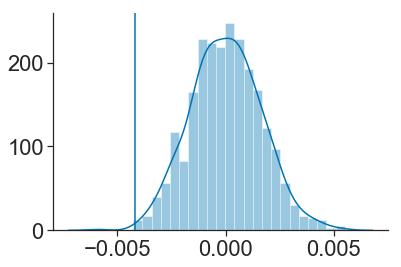

In [19]:
print('p =', sum(np.array(rand_diffs) < observed_diff) / len(rand_diffs))
sns.distplot(rand_diffs)
plt.axvline(observed_diff)
sns.despine()
plt.show()

In [16]:
for ref_proteins in native_pdb_dirs:
    display(distr_scores_df[
        (distr_scores_df['ref_proteins'] == ref_proteins) &
        (distr_scores_df['relax_type'] == 'relax_w_out_symm') &
        (distr_scores_df['all_atoms'] == False)
    ])

,ref_proteins,e_function,relax_type,score,counts,all_atoms
63,beta_nov16_natives,talaris2014,relax_w_out_symm,0.025422,118.0,False
68,beta_nov16_natives,ref2015,relax_w_out_symm,0.022967,118.0,False
73,beta_nov16_natives,beta16.nostab-refit,relax_w_out_symm,0.021970,118.0,False
81,beta_nov16_natives,HH_run19A_step266,relax_w_out_symm,0.014501,118.0,False


,ref_proteins,e_function,relax_type,score,counts,all_atoms
89,beta_nov16_natives_validation,talaris2014,relax_w_out_symm,0.023810,138.0,False
92,beta_nov16_natives_validation,ref2015,relax_w_out_symm,0.024054,138.0,False
95,beta_nov16_natives_validation,beta16.nostab-refit,relax_w_out_symm,0.022607,138.0,False
99,beta_nov16_natives_validation,HH_run19A_step266,relax_w_out_symm,0.016358,138.0,False


,ref_proteins,e_function,relax_type,score,counts,all_atoms
103,original_ppi_natives,talaris2014,relax_w_out_symm,0.026008,165.0,False
106,original_ppi_natives,ref2015,relax_w_out_symm,0.031107,165.0,False
109,original_ppi_natives,beta16.nostab-refit,relax_w_out_symm,0.028854,165.0,False


,ref_proteins,e_function,relax_type,score,counts,all_atoms


,ref_proteins,e_function,relax_type,score,counts,all_atoms


,ref_proteins,e_function,relax_type,score,counts,all_atoms
123,xtals_of_designs,beta16.nostab-refit,relax_w_out_symm,0.067451,46.0,False


In [17]:
for ref_proteins in native_pdb_dirs:
    display(distr_scores_df[
        (distr_scores_df['ref_proteins'] == ref_proteins) &
        (distr_scores_df['relax_type'] == 'relax_w_out_symm_cartesian') &
        (distr_scores_df['all_atoms'] == False)
    ])

,ref_proteins,e_function,relax_type,score,counts,all_atoms
64,beta_nov16_natives,talaris2014,relax_w_out_symm_cartesian,0.035343,118.0,False
69,beta_nov16_natives,ref2015,relax_w_out_symm_cartesian,0.032443,118.0,False
74,beta_nov16_natives,beta16.nostab-refit,relax_w_out_symm_cartesian,0.032644,118.0,False
82,beta_nov16_natives,HH_run19A_step266,relax_w_out_symm_cartesian,0.018461,118.0,False
87,beta_nov16_natives,beta16_plus_lj_changes,relax_w_out_symm_cartesian,0.029327,118.0,False
88,beta_nov16_natives,beta16_plus_hpsc_lj_changes,relax_w_out_symm_cartesian,0.027821,118.0,False


,ref_proteins,e_function,relax_type,score,counts,all_atoms
90,beta_nov16_natives_validation,talaris2014,relax_w_out_symm_cartesian,0.032314,138.0,False
93,beta_nov16_natives_validation,ref2015,relax_w_out_symm_cartesian,0.034648,138.0,False
96,beta_nov16_natives_validation,beta16.nostab-refit,relax_w_out_symm_cartesian,0.031860,138.0,False
100,beta_nov16_natives_validation,HH_run19A_step266,relax_w_out_symm_cartesian,0.021636,138.0,False
101,beta_nov16_natives_validation,beta16_plus_lj_changes,relax_w_out_symm_cartesian,0.029692,138.0,False
102,beta_nov16_natives_validation,beta16_plus_hpsc_lj_changes,relax_w_out_symm_cartesian,0.028513,138.0,False


,ref_proteins,e_function,relax_type,score,counts,all_atoms
104,original_ppi_natives,talaris2014,relax_w_out_symm_cartesian,0.036896,165.0,False
107,original_ppi_natives,ref2015,relax_w_out_symm_cartesian,0.042340,165.0,False
110,original_ppi_natives,beta16.nostab-refit,relax_w_out_symm_cartesian,0.038801,165.0,False


,ref_proteins,e_function,relax_type,score,counts,all_atoms


,ref_proteins,e_function,relax_type,score,counts,all_atoms


,ref_proteins,e_function,relax_type,score,counts,all_atoms


In [18]:
for ref_proteins in native_pdb_dirs:
    display(distr_scores_df[
        (distr_scores_df['ref_proteins'] == ref_proteins) &
        (distr_scores_df['relax_type'] == 'design_MonomerDesign2019') &
        (distr_scores_df['all_atoms'] == False)
    ])

,ref_proteins,e_function,relax_type,score,counts,all_atoms
66,beta_nov16_natives,talaris2014,design_MonomerDesign2019,0.043671,118.0,False
71,beta_nov16_natives,ref2015,design_MonomerDesign2019,0.055772,118.0,False
76,beta_nov16_natives,beta16.nostab-refit,design_MonomerDesign2019,0.051745,118.0,False
84,beta_nov16_natives,HH_run19A_step266,design_MonomerDesign2019,0.035171,118.0,False


,ref_proteins,e_function,relax_type,score,counts,all_atoms


,ref_proteins,e_function,relax_type,score,counts,all_atoms


,ref_proteins,e_function,relax_type,score,counts,all_atoms


,ref_proteins,e_function,relax_type,score,counts,all_atoms


,ref_proteins,e_function,relax_type,score,counts,all_atoms


In [20]:
display(distr_scores_df[
    (distr_scores_df['ref_proteins'] == 'beta_nov16_natives') &
    (distr_scores_df['relax_type'] == 'miniprotein_designs_MonomerDesign2019') &
    (distr_scores_df['all_atoms'] == False)
])

,ref_proteins,e_function,relax_type,score,counts,all_atoms
67,beta_nov16_natives,talaris2014,miniprotein_designs_MonomerDesign2019,0.041418,118.0,False
72,beta_nov16_natives,ref2015,miniprotein_designs_MonomerDesign2019,0.075900,118.0,False
79,beta_nov16_natives,beta16.nostab-refit,miniprotein_designs_MonomerDesign2019,0.087881,118.0,False


In [21]:
display(distr_scores_df[
    (distr_scores_df['ref_proteins'] == 'dpi_natives') &
    (distr_scores_df['relax_type'] == 'relax_dpi') &
    (distr_scores_df['all_atoms'] == False)
])

,ref_proteins,e_function,relax_type,score,counts,all_atoms


Make a dictionary of atomic radii from a given `atom_properties.txt` file

In [22]:
atom_f = 'data/new_atom_typing/atom_properties.txt'
with open(atom_f) as f:
    lines = f.readlines()
radius_dict = {}
for line in lines:
    elements = line.split()
    if len(elements) < 4:
        continue
    (name, atom, r, e) = elements[:4]
    try:
        r = float(r)
    except ValueError:
        continue
    radius_dict[name] = r

Read in data on distance distributions and then plot

beta_nov16_natives_validation
beta16.nostab-refit
beta16_plus_hpsc_lj_changes
CH3:CH3


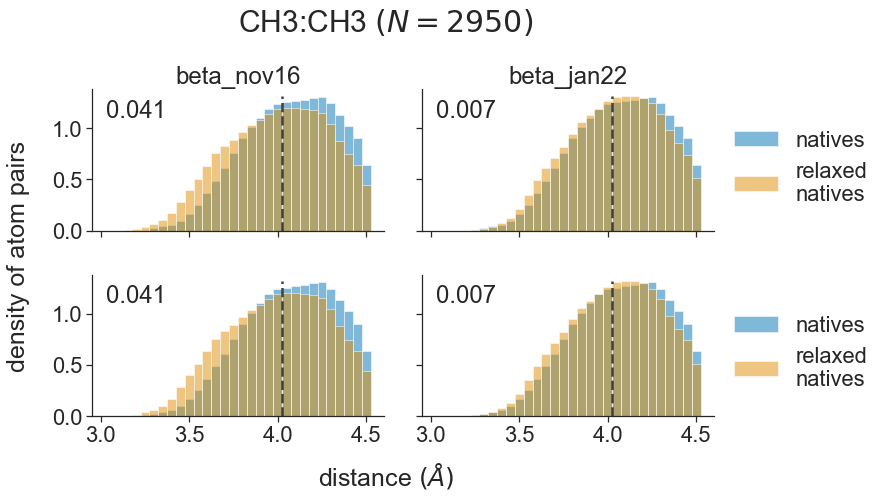


CH3:OCbb


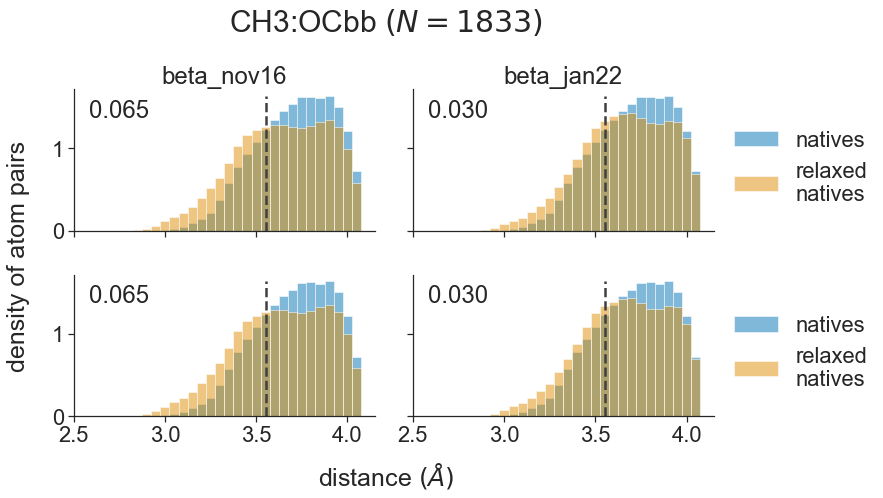


CH3:OH


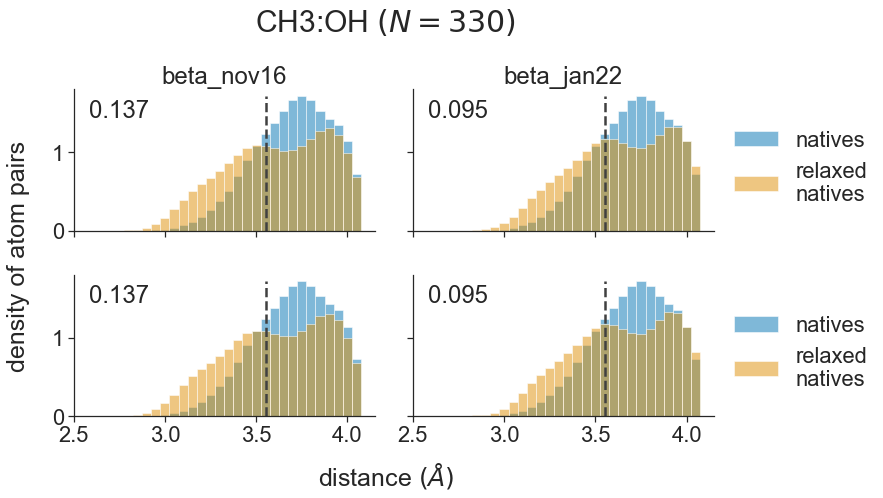


CH3:Hapo


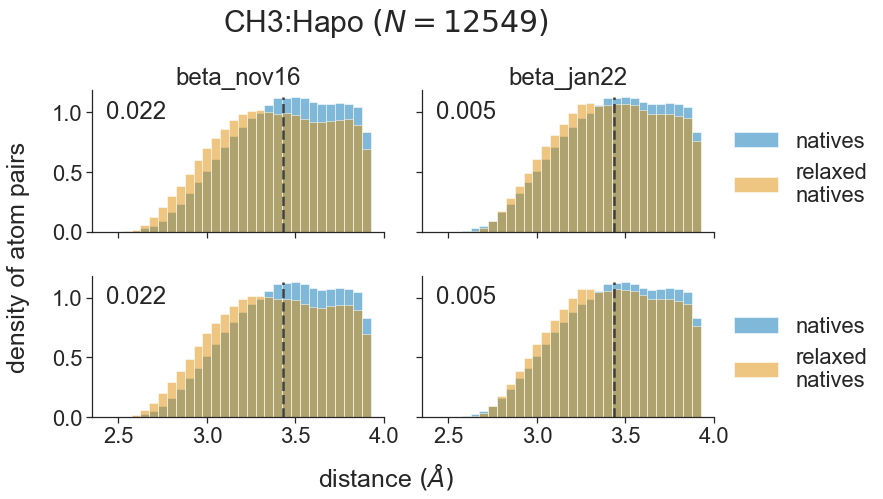


Hapo:Hapo


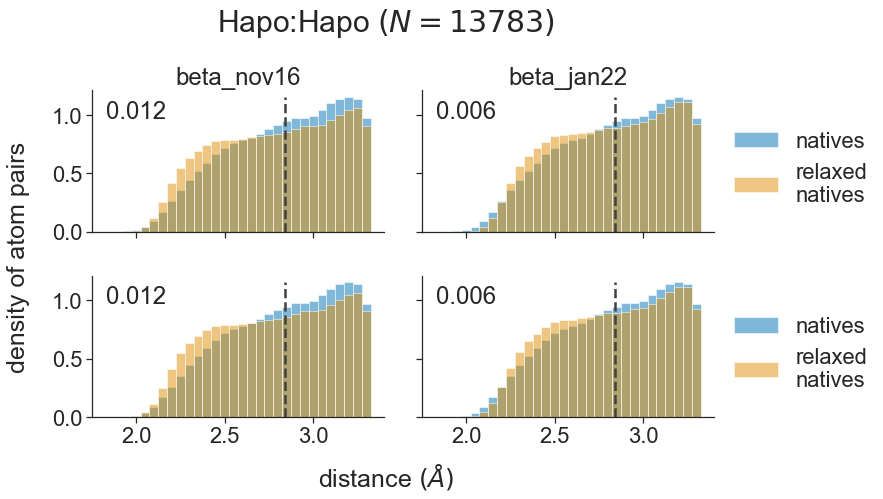

In [23]:
groups = [
    'relax_w_out_symm',
    'relax_w_out_symm_long',
    'relax_w_out_symm_dualspace',
    'relax_w_out_symm_dualspace_const',
    'relax_w_out_symm_cartesian',
    'relax_w_out_symm_cartesian_legacy',
    'relax_w_out_symm_cartesian_const',
    'design',
    'design_legacy', 'design_MonomerDesign2019',
    'design_MonomerDesign2019_hard_layer',
    'design_MonomerDesign2019_soft_layer_10',
    'miniprotein_designs',
    'miniprotein_designs_MonomerDesign2019',
    'miniprotein_designs_custom_default',
]
e_functions = [
#     'talaris2014',
#     'ref2015',
    'beta16.nostab-refit',
    #'HH_run19A_step266',
    #'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
    #'rf_v00.0',
    #'rf_v00.1',
    #'mpnn',
    #'lmbw_af2_des',
    #'lmbw_af2_mpnn_des',
    #'lmbw_af2_des_redes',
    #'mpnn_af2',
    #'HH_run18E_step147'
    #'HH_run23A_step384',
    #'bcov_1a',
    #'HH_run23A_step384_cf_1a',
    #'HH_run23B_sol_elec_dd2_simple_step169',
    #'HH_run23B_sol_elec_dd2_simple_step169_5a2',
    #'HH_run23B_sol_elec_dd2_simple_step169_cf_5a2',
    #'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3',
    #'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3_14',
    
    #'HH_run25A_step402',
    #'HH_run25A_step402_1a',
    #'HH_run25B_step311',
    # 'HH_run25B_step311_1d',
    # 'beta16_plus_lj_changes',
    'beta16_plus_hpsc_lj_changes',
    #'HH_run25B_step311_final',
    #'HH_run26A_step258',
    #'HH_run26A_step258_1a',
    #'HH_run26A_step258_1b',
    #'HH_run26A_step258_1d',
    #'HH_run26A_step258_1d_elec_dd2',
    #'HH_run26B_step129',
    #'HH_run26B_step129_1a',
    #'HH_run26B_step129_final',
    #'HH_run26B_step129_1e3_14',
    #'HH_run26A_step0',
    #'HH_run26A_step0_1a',
    #'HH_run25A_step480',
    #'HH_run25A_step480_1a',
]

# Read in data for relaxed structures, designed natives,
# and designed mini-proteins
ref_proteins = 'beta_nov16_natives_validation' # 'beta_nov16_natives' # 'original_ppi_natives' # 
dfs = []
for e_function in e_functions:
    for group in groups:
        if 'miniprotein' in group:
            f = f'results/{group}/{e_function}/distrs_new_atom_typing_all_atoms.csv'
        elif group == 'miniproteins':
            f = f'results/miniprotein_designs/{e_function}/distrs_new_atom_typing_all_atoms.csv'
        else:
            f = f'results/{ref_proteins}/{e_function}/{group}/distrs_new_atom_typing_all_atoms.csv'
        if not os.path.isfile(f):
            continue
        df = pandas.read_csv(f)
        df['e_function'] = e_function
        df['group'] = group
        dfs.append(df)    

# Add data from designs made with DL methods
dl_ref_proteins_list = [
    'mpnn_beta_nov16_natives',
    'mpnn_af2_beta_nov16_natives',
    #'rf_v00.0_beta_nov16_natives',
    'rf_v00.1_beta_nov16_natives',
    'lmbw_af2_des',
    'lmbw_af2_mpnn_des',
]
e_function = 'beta16.nostab-refit' # 'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14' # 'HH_run19A_step266' #
group = 'relax_w_out_symm_cartesian'
for dl_ref_proteins in dl_ref_proteins_list:
    f = f'results/{dl_ref_proteins}/{e_function}/{group}/distrs_new_atom_typing_all_atoms.csv'
    if not os.path.isfile(f):
        continue
    df = pandas.read_csv(f)
    df['e_function'] = dl_ref_proteins.replace('_beta_nov16_natives', '')
    df['group'] = 'design_MonomerDesign2019_hard_layer'
    dfs.append(df)

group = 'design_MonomerDesign2019_hard_layer'
for dl_ref_proteins in dl_ref_proteins_list:
    f = f'results/{dl_ref_proteins}/{e_function}/{group}/distrs_new_atom_typing_all_atoms.csv'
    if not os.path.isfile(f):
        continue
    df = pandas.read_csv(f)
    df['e_function'] = dl_ref_proteins + '_redes'
    df['group'] = 'design_MonomerDesign2019_hard_layer'
    dfs.append(df)
        
# Add data from other pools of protein designs from the lab
design_pools = [
    'Rocklin_HHH', 'Rocklin_EHEE', 'Rocklin_EEHEE', 'Rocklin_HEEH',
    'Rocklin_HHH_stable', 'Rocklin_HHH_unstable',
    'Rocklin_EHEE_stable', 'Rocklin_EHEE_unstable',
    'Rocklin_EEHEE_stable', 'Rocklin_EEHEE_unstable',
    'Rocklin_HEEH_stable', 'Rocklin_HEEH_unstable',
    'hbnet_designs', 'TERM_designs',
    'HHH_BC_1', 'HHH_BC_2', 'ferr_BH',
    'DHRs', 'NTF2s_CN',
    'zcons',
    'beta_barrels_1', 'beta_barrels_2',
    'mini_beta_barrel_designs', 'mini_beta_barrel_natives',
    'mini_beta_barrel_designs_18F',
    'lockr_key_beta16', 'key_beta16',
    'lockr_key_19A', 'key_19A',
    'SL_keys',
    'Bahl_native', 'Bahl_default', 'Bahl_KillA',
    'helical_oligomer_designs',
    'Ali_no_PPI_beta16',
    'Ali_no_PPI_beta20',
    'Ali_with_PPI_beta16',
    'Ali_with_PPI_beta20',
    'Ali_no_PPI_new_beta20',
    'Ali_with_PPI_new_beta20',
    'NTF2_AC_beta_scoring',
    'NTF2_AC_hugh_scoring',
    'ankyrin_HJ',
]

for design_pool in design_pools:
    f = os.path.join(
        f'results/{ref_proteins}/design_pools/{design_pool}',
        'distrs_new_atom_typing_all_atoms.csv'
    )
    if not os.path.isfile(f):
        #raise ValueError(f)
        continue
    df = pandas.read_csv(f)
    df['design_pool'] = design_pool
    dfs.append(df)

dist_df = pandas.concat(dfs, sort=False)
dist_df['atoms'] = dist_df.apply(
    lambda row: ':'.join(sorted([row['a1'], row['a2']])),
    axis=1
)

# Plot data
sns.set(font_scale=2, style='ticks', palette = 'colorblind')
groups = [
    #'miniprotein_designs_MonomerDesign2019',
    #'miniprotein_designs_legacy',
    #'relax_w_out_symm',
    #'design_MonomerDesign2019',
    'relax_w_out_symm_cartesian',
    'relax_w_out_symm_cartesian',
    #'design_MonomerDesign2019_soft_layer_10',
    #'design_legacy',
]
atoms_to_plot = [
    'OCbb:OCbb', 'CAbb:CAbb',
    'CObb:OCbb', 'CAbb:OCbb', 'Nbb:OCbb',
    'CAbb:CObb',
    'Narg:OOC',
    'Nlys:OOC',
    'Nbb:OOC',
    'NH2O:OOC',
    'Nhis:OOC',
    'Narg:ONH2',
    'Nlys:ONH2',
    'NH2O:ONH2',
    'Nhis:ONH2',
    'Nbb:ONH2',
    'Narg:OCbb',
    'Nlys:OCbb',
    'NH2O:OCbb',
    'Nhis:OCbb',
    'Ntrp:OCbb',
    'OCbb:OH',
    'OH:Nbb',
    'Nbb:OH',
    'Nhis:Nbb',
    'Nbb:Nhis',
    'CHR1:S',
    'CH3:NH2O', 'NH2O:aroC', 'CH2:NH2O', 'CH1:NH2O', 'CHR1:NH2O', 'CHR2:NH2O',
    'CH3:Nhis', 'Nhis:aroC', 'CH2:Nhis', 'CH1:Nhis', 'CHR1:Nhis', 'CHR2:Nhis',
    'CH3:Nlys', 'Nlys:aroC', 'CH2:Nlys', 'CH1:Nlys', 'CHR1:Nlys', 'CHR2:Nlys',
    'CH3:Narg', 'Narg:aroC', 'CH2:Narg', 'CH1:Narg', 'CHR1:Narg', 'CHR2:Narg',
    'CH3:Npro', 'Npro:aroC', 'CH2:Npro', 'CH1:Npro', 'CHR1:Npro', 'CHR2:Npro',
    'CH3:Nbb', 'Nbb:aroC', 'CH2:Nbb', 'CH1:Nbb', 'CHR1:Nbb', 'CHR2:Nbb',
    'CH3:OOC', 'OOC:aroC', 'CH2:OOC', 'CHR1:OOC', 'CHR2:OOC',
    'CH3:ONH2', 'ONH2:aroC', 'CH2:ONH2', 'CHR1:ONH2', 'CHR2:ONH2',
    'CHR1:CHR1', 'CH1:CHR1',
    'CHR2:CHR2',
    'Hapo:OCbb', 'HAbb:OCbb', 'HapR:OCbb',
    'CH3:OCbb', 'CH2:OCbb', 'CH1:OCbb', 'OCbb:aroC',
    'CObb:OH',
    'CH2:OH', 'CH3:OH', 'OH:aroC',
    'CH2:SH1', 'CH3:SH1',
    'CH3:S',
    'CH1:CH1',
    'CH3:CH3', 'CH2:CH3', 'CH1:CH3',
    'Hapo:Hapo', 'HapR:HapR',
    'CH3:Hapo', 'CH2:Hapo', 'CH1:Hapo',
    'CH3:Haro', 'CH2:Haro', 'CH1:Haro',
    #'CH3:HAbb', 'CH2:HAbb', 'CH1:HAbb',  #'HAbb:aroC'.
    'aroC:aroC', 'CH3:aroC',
]

atoms_to_plot = [
    'CH3:CH3',
    'CH3:OCbb', #'OCbb:aroC',
    'CH3:OH',
    'CH3:Hapo',
    'Hapo:Hapo'
    #'CH3:aroC',
    #'aroC:aroC',
    #'Nbb:OCbb',
]

label_dict = {
    'relax_w_out_symm' : 'relaxed\nnatives\n(short)',
    'relax_w_out_symm_long' : 'relaxed\nnatives\n(long)',
    'relax_w_out_symm_dualspace' : 'dualspace',
    'relax_w_out_symm_dualspace_const' : 'dualspace_const',
    'relax_w_out_symm_cartesian' : 'relaxed\nnatives',
    'relax_w_out_symm_cartesian_legacy' : 'cart_legacy',
    'relax_w_out_symm_cartesian_const' : 'cart_const',
    #'design_MonomerDesign2019' : 'redesigned\nnatives',
    'design_MonomerDesign2019_hard_layer' : 'redesigned\nnatives',
    'design_MonomerDesign2019_soft_layer_10' : 'redesigned\nnatives',
    'miniproteins': '$\it{de}$ $\it{novo}$\ndesigns',
    'miniprotein_designs_MonomerDesign2019' : '$\it{de}$ $\it{novo}$\ndesigns',
}
e_function_title_dict = {
    'HH_run9_step282' : 'run9',
    'HH_run18D_step886_modified6f' : '18D_6f',
    'beta16.nostab-refit' : 'beta_nov16',
    'HH_run19A_step266' : 'new energy function',
    #'HH_run25B_step311_1d' : 'beta_jan22',
    'beta16_plus_hpsc_lj_changes' : 'beta_jan22',
    #'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14' : 'beta_jan22'
}
print(ref_proteins)
print('\n'.join(e_functions))
for atoms in atoms_to_plot: #[:47]:
    
    # Get metadata for atom pair
    print(atoms)
    (a1, a2) = atoms.split(':')
    r1 = radius_dict[a1]
    r2 = radius_dict[a2]
    sigma = r1 + r2
    min_d = sigma - 1.0
    max_d = sigma + 0.5
    data = dist_df[
        (dist_df['atoms'] == atoms) &
        (dist_df['e_function'].isin(e_functions)) &
        (dist_df['group'].isin(groups))
    ]
    if len(data) == 0:
        continue
    max_density = data[['ref', 'input']].max().max()
    
    # Plot data
    nrows = len(groups)
    ncols = len(e_functions)
    (fig, axs) = plt.subplots(
        ncols=ncols, nrows=nrows, sharex=True, sharey=True,
        figsize=[5*ncols,3*nrows]
    )
    for (i, group) in enumerate(groups):
        for (j, e_function) in enumerate(e_functions):

            # Get data for the given energy function, group,
            # and atom pair
            data = dist_df[
                (dist_df['atoms'] == atoms) &
                (dist_df['e_function'] == e_function) &
                (dist_df['group'] == group) &
                (dist_df['distance'].between(min_d, max_d))
            ].copy()
            if len(data) == 0:
                continue
            for col in ['ref', 'input']:
                if col == 'ref':
                    label = 'natives'
                elif group in label_dict:
                    label = label_dict[group]
                else:
                    label = group
                axs[i][j].bar(
                    x=data['distance'], height=data[col], width=0.05,
                    label=label, alpha=0.5, linewidth=1
                )
                if i == 0:
                    if True & (e_function in e_function_title_dict):
                        axs[i][j].set(
                            title=e_function_title_dict[e_function]
                        )
                    else:
                        axs[i][j].set(
                            title=e_function.replace(
                                'HH_run', ''
                            ).replace(
                                '5h_res0.5_pr2.5', '*'
                            ).replace(
                                'no_dd_elec_res0.5_pr1.4_sigS2.0_ceil0.6', '*'
                            ).replace(
                                '23B_sol_elec_dd2_simple_step169', '23B'
                            )
                        )
            #axs[i][j].set(yticks=[0, 1])
            
            # Plot the vertical bar showing sigma
            axs[i][j].plot(
                [sigma, sigma], [0, max_density],
                ls='--', c='0.25', linewidth=2.5
            )
                    
            # Add the KL divergence value to each plot
            if True:
                data = kl_df[
                    (kl_df['relax_type'] == group) &
                    (kl_df['ref_proteins'] == ref_proteins) &
                    (kl_df['e_function'] == e_function) &
                    (kl_df['atoms'] == atoms) &
                    (kl_df['all_atoms'] == True)
                ].copy()
                if len(data) == 1:
                    kldiv = float(data['kldiv'])
                    axs[i][j].text(
                        0.05, 0.8, '{:.3f}'.format(round(kldiv, 3)),
                        transform=axs[i][j].transAxes, fontsize=24
                    )
            
    plt.tight_layout()
    
    # Add legends
    j = len(e_functions)-1
    for (i, group) in enumerate(groups):
        axs[i][j].legend(bbox_to_anchor=(1,0.85), frameon=False)
    
    # Add common axis labels and title
    fig.text(
        -0.01, 0.5, 'density of atom pairs',
        ha='center', va='center', rotation='vertical',
        fontsize=25
    )
    fig.text(
        0.5, -0.01, 'distance $({\AA})$', ha='center',
        va='center', fontsize=25
    )
    if True:
        n = int(n_df[
            (n_df['ref_proteins'] == ref_proteins) &
            (n_df['atoms'] == atoms) &
            (n_df['all_atoms'] == True)
        ]['n'])
    else:
        n = 'X'
    fig.text(
        0.5, 1.04,
        f'{atoms} $(N={n})$',
        ha='center', va='center',
        fontsize=30
    )
    sns.despine()
    plt.show()
    print('')

Plot distances for a given atom type

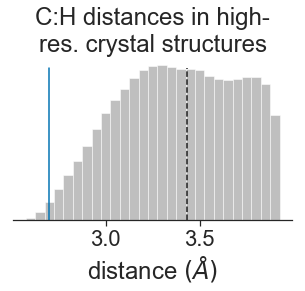

In [119]:
e_function = 'beta16.nostab-refit'
group = 'relax_w_out_symm_cartesian'

atoms = 'CH3:Hapo' # 'Hapo:Hapo' # 'Hapo:OCbb' # 'CH3:CH3' # 
(a1, a2) = atoms.split(':')
r1 = radius_dict[a1]
r2 = radius_dict[a2]
sigma = r1 + r2
min_d = sigma - 0.85
max_d = sigma + 0.5 # 3.55 # 

data = dist_df[
    (dist_df['atoms'] == atoms) &
    (dist_df['e_function'] == e_function) &
    (dist_df['group'] == group) &
    (dist_df['distance'].between(min_d, max_d))
].copy()
data.head()

plt.figure(figsize=[5,3])
plt.bar(
    x=data['distance'], height=data[col], width=0.05,
    label=label, alpha=0.5, linewidth=1, color='0.5'
)
plt.plot([2.7, 2.7], [0, 1])
plt.plot([sigma, sigma], [0, 1], ls='--', c='k')
plt.title('C:H distances in high-\nres. crystal structures')
#plt.xticks([2.5, 3, 3.5])
plt.xlabel('distance $(\AA)$')
plt.yticks([])
sns.despine(left=True)
plt.show()

['beta16.nostab-refit', 'beta16_plus_hpsc_lj_changes']
beta_nov16_natives_validation


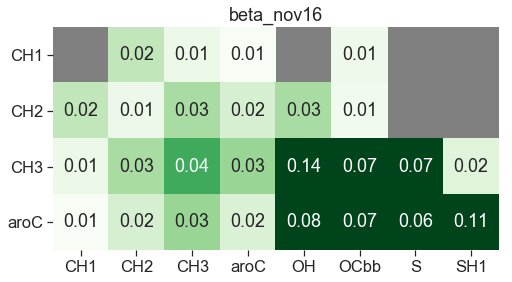

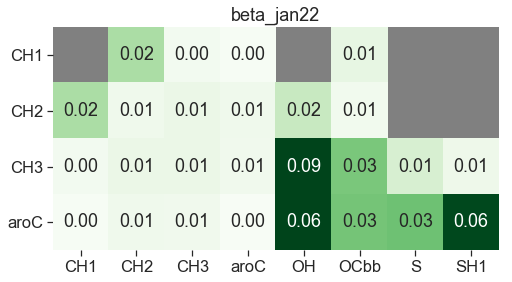

In [120]:
# Get data of interest
e_functions = [
    'beta16.nostab-refit',
    'beta16_plus_hpsc_lj_changes'
]
print(e_functions)
e_function_labels = {
    'beta16.nostab-refit' : 'beta_nov16',
    'beta16_plus_hpsc_lj_changes' : 'beta_jan22',
}
ref_proteins = 'beta_nov16_natives_validation' # 'beta_nov16_natives' #  'original_ppi_natives' # 
print(ref_proteins)
relax_type = 'relax_w_out_symm_cartesian'
all_atoms = True
atoms_y = [
    'CH1', 'CH2', 'CH3', 'aroC', #'CHR1', 'CHR2'
    #'CH1', 'CH2', 'CH3', 'aroC',
]
atoms_x = [
    'CH1', 'CH2', 'CH3', #'Hapo',
    #'CHR1', 'CHR2', #'HapR',
    'aroC', #'Haro',
    'OH', 'OCbb',
    #'OOC', 'ONH2',
    'S', 'SH1',
    #'NH2O', 'Narg', 'Nlys', 'Nbb',
]
if False:
    atoms_x = ['OCbb', 'CObb', 'CAbb']
    atoms_y = [
        'OCbb', 'CObb', 'CAbb',
        'CH1', 'CH2', 'CH3', 'aroC',
        #'CHR1', 'CHR2'
    ]
    
for e_function in e_functions:
    data = kl_df[
        (kl_df['e_function'] == e_function) &
        (kl_df['relax_type'] == relax_type) &
        (kl_df['ref_proteins'] == ref_proteins) &
        (kl_df['all_atoms'] == all_atoms)
    ].copy()
    assert len(data['atoms']) == len(set(data['atoms']))
    data_switch = data.copy()
    data_switch.rename(columns = {'a1':'a2', 'a2':'a1'}, inplace=True)
    data = pandas.concat([data, data_switch], sort=False)

    data = data.pivot_table(
        values='kldiv', columns=['a2'], index=['a1']
    )

    # Get data for specific atoms   
    data_to_plot = data[atoms_x].loc[atoms_y]

    # Make plot
    sns.set(font_scale=1.5, style='ticks', palette = 'colorblind')
    plt.figure(figsize=[8,12])
    g = sns.heatmap(
        data_to_plot, annot=True, cmap='Greens',
        fmt='.2f', square=True, cbar=False, vmax=0.06
    )
    g.set_facecolor('0.5')
    plt.title(e_function_labels[e_function])
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

To do:

* Look at CHR1 and CHR2 distributions
* HAbb getting too close to things?

Observations:
* OH:aroC
    * rotamer change where OH flips in, is desolvated, and makes an H-bond
        * 2ra9_clean_0001_0001 (beta16 decoy)
    * large changes where two OHs break H-bonds, resulting in unsats
        * 1lu4_clean_0001_0001 (beta16 decoy)
    * subtle shift that caused clash
        * 3nbm_clean_0001_0001 (18F decoy)
        
* OH:CH3
    * clash may be due to missing water and OH moving over to make missing Hbond?
        * 1ucs (18F decoy)
    * OH moves to make a sc-bb H-bond w/ a bb atom already making an H-bond. Fix by discounting this H-bond energy?

results/dpi_natives/opt46A/relax_dpi/distrs.csv
results/dpi_natives/opt46A_dd_elec/relax_dpi/distrs.csv
dpi_natives
opt46A
opt46A_dd_elec
CH3:OOC


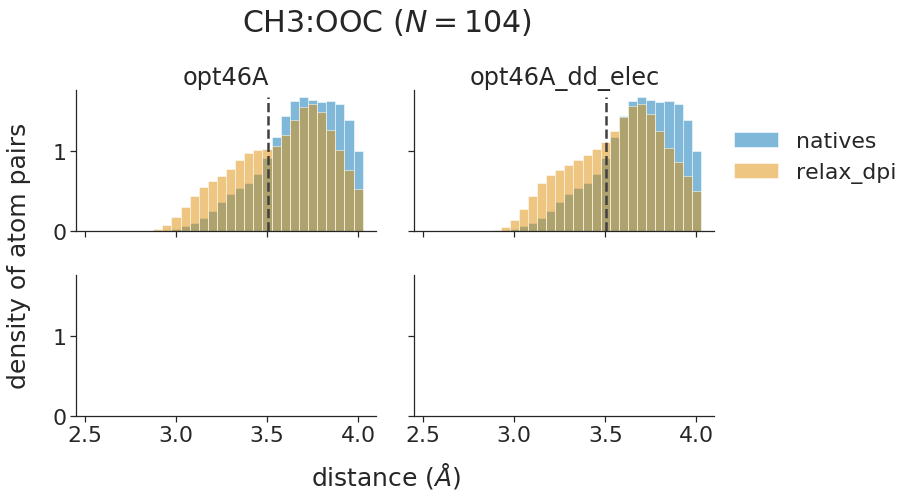


CH2:OOC


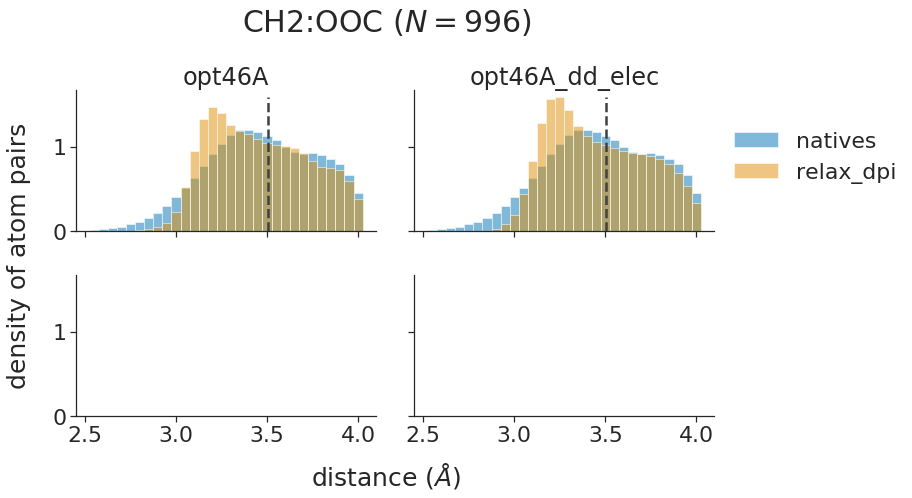


OOC:aroC


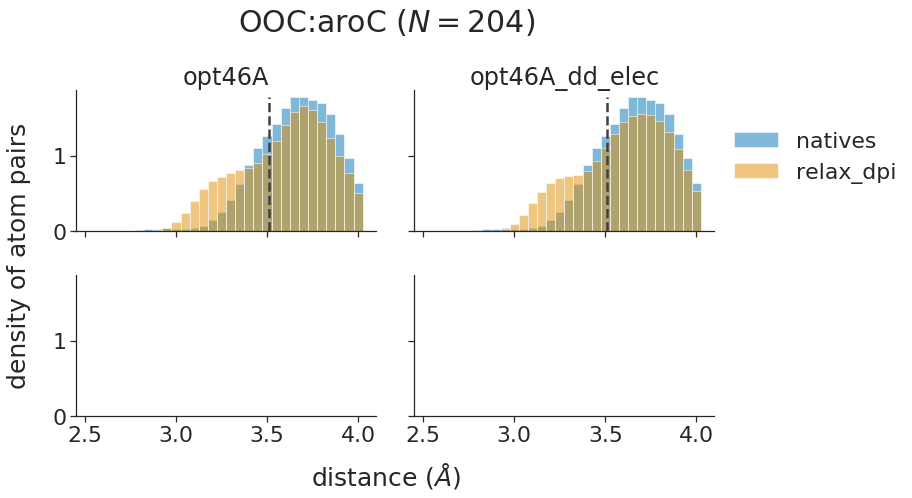

In [54]:
groups = [
    'relax_dpi',
]
e_functions = [
    #'beta16_newdna',
    'opt46A',
    'opt46A_dd_elec',
    #'opt47_step1',
    #'opt47_step1_mod1',
]

# Read in data for relaxed structures, designed natives,
# and designed mini-proteins
ref_proteins = 'dpi_natives'
dfs = []
for e_function in e_functions:
    for group in groups:
        f = f'results/{ref_proteins}/{e_function}/{group}/distrs.csv'
        print(f)
        if not os.path.isfile(f):
            continue
        df = pandas.read_csv(f)
        df['e_function'] = e_function
        df['group'] = group
        dfs.append(df)        

dist_df = pandas.concat(dfs, sort=False)
dist_df['atoms'] = dist_df.apply(
    lambda row: ':'.join(sorted([row['a1'], row['a2']])),
    axis=1
)

# Plot data
sns.set(font_scale=2, style='ticks', palette = 'colorblind')
groups = [
    'relax_dpi',
    'relax_w_out_symm_cartesian',
]
atoms_to_plot = [
    'CH3:OOC', 'CH2:OOC', 'OOC:aroC'
]
label_dict = {
    'relax_w_out_symm' : 'relaxed\nnatives',
    'relax_w_out_symm_long' : 'relaxed\nnatives\n(long)',
    'relax_w_out_symm_dualspace' : 'dualspace',
    'relax_w_out_symm_dualspace_const' : 'dualspace_const',
    'relax_w_out_symm_cartesian' : 'relaxed\nnatives\n(long)',
    'relax_w_out_symm_cartesian_legacy' : 'cart_legacy',
    'relax_w_out_symm_cartesian_const' : 'cart_const',
    'design_MonomerDesign2019' : 're-designed\nnatives',
    'miniproteins': '$\it{de}$ $\it{novo}$\ndesigns',
    'miniprotein_designs_MonomerDesign2019' : '$\it{de}$ $\it{novo}$\ndesigns',
}
e_function_title_dict = {
    'HH_run9_step282' : 'run9',
    'HH_run18D_step886_modified6f' : '18D_6f',
}
print(ref_proteins)
print('\n'.join(e_functions))
for atoms in atoms_to_plot: #[:47]:
    
    # Get metadata for atom pair
    print(atoms)
    (a1, a2) = atoms.split(':')
    r1 = radius_dict[a1]
    r2 = radius_dict[a2]
    sigma = r1 + r2
    min_d = sigma - 1.0
    max_d = sigma + 0.5
    data = dist_df[
        (dist_df['atoms'] == atoms) &
        (dist_df['e_function'].isin(e_functions)) &
        (dist_df['group'].isin(groups))
    ]
    if len(data) == 0:
        continue
    max_density = data[['ref', 'input']].max().max()
    
    # Plot data
    nrows = len(groups)
    ncols = len(e_functions)
    (fig, axs) = plt.subplots(
        ncols=ncols, nrows=nrows, sharex=True, sharey=True,
        figsize=[5*ncols,3*nrows]
    )
    for (i, group) in enumerate(groups):
        for (j, e_function) in enumerate(e_functions):

            # Get data for the given energy function, group,
            # and atom pair
            data = dist_df[
                (dist_df['atoms'] == atoms) &
                (dist_df['e_function'] == e_function) &
                (dist_df['group'] == group) &
                (dist_df['distance'].between(min_d, max_d))
            ].copy()
            if len(data) == 0:
                continue
            for col in ['ref', 'input']:
                if col == 'ref':
                    label = 'natives'
                elif group in label_dict:
                    label = label_dict[group]
                else:
                    label = group
                axs[i][j].bar(
                    x=data['distance'], height=data[col], width=0.05,
                    label=label, alpha=0.5, linewidth=1
                )
                if i == 0:
                    if True & (e_function in e_function_title_dict):
                        axs[i][j].set(
                            title=e_function_title_dict[e_function]
                        )
                    else:
                        axs[i][j].set(title=e_function)
            axs[i][j].set(yticks=[0, 1])
            
            # Plot the vertical bar showing sigma
            axs[i][j].plot(
                [sigma, sigma], [0, max_density],
                ls='--', c='0.25', linewidth=2.5
            )
                    
            # Add the KL divergence value to each plot
            if False:
                data = kl_df[
                    (kl_df['relax_type'] == group) &
                    (kl_df['ref_proteins'] == ref_proteins) &
                    (kl_df['e_function'] == e_function) &
                    (kl_df['atoms'] == atoms) &
                    (kl_df['all_atoms'] == False)
                ].copy()
                assert len(data) == 1
                kldiv = float(data['kldiv'])
                axs[i][j].text(
                    0.05, 0.8, '{:.3f}'.format(round(kldiv, 3)),
                    transform=axs[i][j].transAxes, fontsize=24
                )
            
    plt.tight_layout()
    
    # Add legends
    j = len(e_functions)-1
    for (i, group) in enumerate(groups):
        axs[i][j].legend(bbox_to_anchor=(1,0.85), frameon=False)
    
    # Add common axis labels and title
    fig.text(
        -0.01, 0.5, 'density of atom pairs',
        ha='center', va='center', rotation='vertical',
        fontsize=25
    )
    fig.text(
        0.5, -0.01, 'distance $({\AA})$', ha='center',
        va='center', fontsize=25
    )
    if True:
        n = int(n_df[
            (n_df['ref_proteins'] == ref_proteins) &
            (n_df['atoms'] == atoms) &
            (n_df['all_atoms'] == False)
        ]['n'])
    else:
        n = 'X'
    fig.text(
        0.5, 1.04,
        f'{atoms} $(N={n})$',
        ha='center', va='center',
        fontsize=30
    )
    sns.despine()
    plt.show()
    print('')

Compare atomic radii

In [54]:
atom_prop_f = '/home/haddox/Rosetta/main/database/chemical/atom_type_sets/fa_standard/atom_properties.txt'
df = pandas.read_csv(
    atom_prop_f, sep='\s+', error_bad_lines=False,
    warn_bad_lines=False, comment='#'
)
atoms = ['OCbb', 'S']
df[df['NAME'].isin(atoms)]

,NAME,ATOM,LJ_RADIUS,LJ_WDEPTH,LK_DGFREE,LK_LAMBDA,LK_VOLUME
8,S,S,1.975967,0.455970,-1.707229,3.5,17.640000


In [55]:
df[df['NAME'].str.contains('O')]

,NAME,ATOM,LJ_RADIUS,LJ_WDEPTH,LK_DGFREE,LK_LAMBDA,LK_VOLUME
1,COO,C,1.916661,0.141799,-3.332648,3.5,14.653000
11,CObb,C,1.916661,0.141799,3.104248,3.5,13.221000
16,Opoint,O,1.550000,0.1591,0.000000,3.5,10.8000
73,Os,OS,1.560000,0.0370,-5.000000,3.5,10.1938


Plot data relative to the LJ potential

In [56]:
lj_dir = os.path.join(
    '/home/haddox/2019/rosetta_feature_space_geometry/',
    'results/decoys_for_e_potentials/LL_CH3_CH3/'
)
e_functions = [
    'beta16.nostab-refit',
    'HH_run18C_step286'
]
dfs = []
for e_function in e_functions:
    lj_file = os.path.join(
        lj_dir,
        e_function,
        'pairwise_landscapes/CD1_CD1.csv'
    )
    df = pandas.read_csv(lj_file)
    df['e_function'] == e_function
    dfs.append(df)

lj_df = pandas.concat(dfs, sort=False)

In [57]:
sigma_dict = {
    'Narg:OCbb' : 1.802452 + 1.540580,
    'Nlys:OCbb' : 1.802452 + 1.540580,
    'NH2O:OCbb' : 1.802452 + 1.540580,
    'Nbb:OCbb' : 1.802452 + 1.540580,
    'OCbb:OCbb' : 1.540580 + 1.540580,
    'CObb:OCbb' : 1.916661 + 1.540580,
    'CObb:OH' : 1.916661 + 1.542743,
    'CAbb:CObb' : 2.011760 + 1.916661,
    'CAbb:OCbb' : 2.011760 + 1.540580,
    'Hapo:Hapo' : 1.4 + 1.4,
    'HapR:HapR' : 1.4 + 1.4,
    'Hapo:OCbb' : 1.4 + 1.540580,
    'HapR:OCbb' : 1.4 + 1.540580,
    'HAbb:OCbb' : 1.4 + 1.540580,
    'CAbb:Hapo' : 2.011760 + 1.4,
    'CH1:Hapo' : 2.011760 + 1.4,
    'CH2:Hapo' : 2.011760 + 1.4,
    'CH3:Hapo' : 2.011760 + 1.4,
    'CAbb:Haro' : 2.011760 + 1.4,
    'CH1:Haro' : 2.011760 + 1.4,
    'CH2:Haro' : 2.011760 + 1.4,
    'CH3:Haro' : 2.011760 + 1.4,
    'CH1:HAbb' : 2.011760 + 1.4,
    'CH2:HAbb' : 2.011760 + 1.4,
    'CH3:HAbb' : 2.011760 + 1.4,
    'CAbb:HapR' : 2.011760 + 1.4,
    'CAbb:CAbb' : 2.011760 + 2.011760,
    'CHR1:CHR1' : 1.82 + 1.82,
    'CH1:CHR1' : 2.011760 + 1.82,
    'CH1:CH1' : 2.011760 + 2.011760,
    'CH2:CH2' : 2.011760 + 2.011760,
    'CH1:CH3' : 2.011760 + 2.011760,
    'CH2:CH3' : 2.011760 + 2.011760,
    'CH3:CH3' : 2.011760 + 2.011760,
    'CH3:OCbb' : 2.011760 + 1.540580,
    'CH2:OCbb' : 2.011760 + 1.540580,
    'CH1:OCbb' : 2.011760 + 1.540580,
    'CH2:OH' : 2.011760 + 1.542743,
    'CH3:OH' : 2.011760 + 1.542743,
    'CH3:S' : 2.011760 + 1.975967,
    'CH2:SH1' : 2.011760 + 1.975967,
    'CH3:SH1' : 2.011760 + 1.975967,
    'CH3:SH1' : 2.011760 + 1.975967,
    'CH3:Narg' : 1.802452 + 1.975967,
    'aroC:aroC' : 2.016441 + 2.016441,
    'CH3:aroC' : 2.011760 + 2.016441,
    'OH:aroC' : 1.542743 + 2.016441,
    'OOC:aroC' : 1.492871 + 2.016441,
    'OCbb:aroC' : 1.540580 + 2.016441,
    'OCbb:OH' : 1.542743 + 1.540580,
    'Nbb:OH' : 1.802452 + 1.540580,
}

distance_range = {
    'Hapo:Hapo' : (1.9, 3.3),
    'HapR:HapR' : (1.9, 3.3),
    'Hapo:OCbb' : (2.0, 3.6),
    'HapR:OCbb' : (2.0, 3.6),
    'HAbb:OCbb' : (2.0, 3.6),
    'CAbb:Hapo' : (2.5, 3.9),
    'CH1:Hapo' : (2.5, 3.9),
    'CH2:Hapo' : (2.5, 3.9),
    'CH3:Hapo' : (2.5, 3.9),
    'CAbb:Haro' : (2.5, 3.9),
    'CH1:Haro' : (2.5, 3.9),
    'CH2:Haro' : (2.5, 3.9),
    'CH3:Haro' : (2.5, 3.9),
    'CH1:HAbb' : (2.5, 3.9),
    'CH2:HAbb' : (2.5, 3.9),
    'CH3:HAbb' : (2.5, 3.9),
    'CAbb:HapR' : (2.5, 3.9),
    'Narg:OCbb' : (2.2, 4.2),
    'Nlys:OCbb' : (2.2, 4.2),
    'Nbb:OCbb' : (2.6, 4.0),
    'NH2O:OCbb' : (2.2, 4.2),
    'OCbb:OCbb' : (2.8, 3.7),
    'CObb:OCbb' : (3.2, 4.1),
    'CAbb:OCbb' : (2.9, 4.2),
    'CAbb:CAbb' : (3.2, 4.7),
    'CAbb:CObb' : (3.1, 4.6),
    'CObb:OH' : (2.8, 4.2),
    'CHR1:CHR1' : (3.2, 4.7),
    'CH1:CHR1' : (3.2, 4.7),
    'CH1:CH1' : (3.2, 4.7),
    'CH2:CH2' : (3.2, 4.7),
    'CH1:CH3' : (3.2, 4.7),
    'CH2:CH3' : (3.2, 4.7),
    'CH3:CH3' : (3.2, 4.7),
    'CH3:OCbb' : (2.9, 4.2),
    'CH2:OCbb' : (2.9, 4.2),
    'CH1:OCbb' : (2.9, 4.2),
    'CH2:OH' : (2.8, 4.2),
    'CH3:OH' : (2.8, 4.2),
    'CH3:S' : (3.1, 4.7),
    'CH2:SH1' : (2.6, 4.7),
    'CH3:SH1' : (3.1, 4.7),
    'CH3:Narg' : (3.2, 4.6),
    'aroC:aroC' : (3.2, 4.8),
    'CH3:aroC' :(3.2, 4.6),
    'OH:aroC' :(2.8, 4.3),
    'OOC:aroC' :(2.8, 4.3),
    'OCbb:aroC' :(2.9, 4.2),
    'OCbb:OH' : (2.2, 3.9),
    'Nbb:OH' : (2.3, 4.2),
}

CH3:CH3


ValueError: Axis limits cannot be NaN or Inf

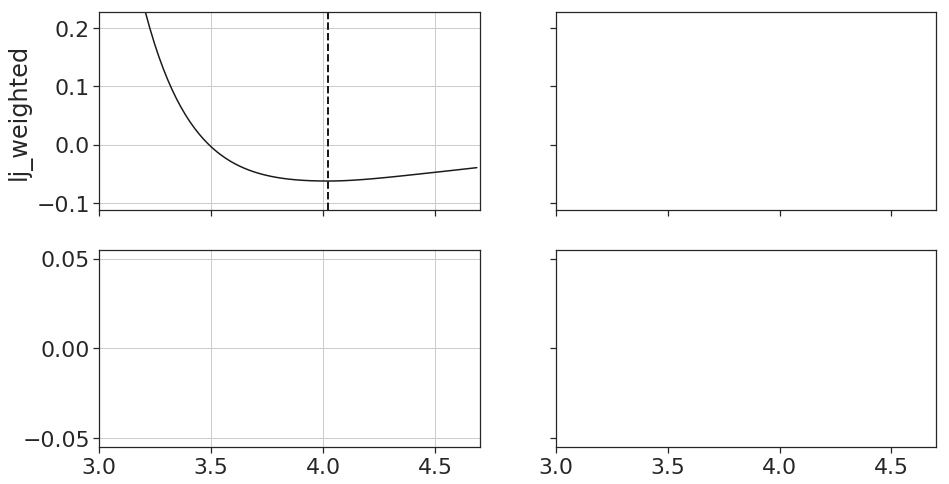

In [58]:
groups = ['relax_w_out_symm', 'design', 'miniproteins']
e_functions = [
    'beta16.nostab-refit',
    'HH_run18C_step286'
]
ref_proteins = 'beta_nov16_natives' # 'original_ppi_natives' # 

atoms_to_plot = [
    'CH3:CH3',
    'CH3:OCbb'
]

label_dict = {
    'relax_w_out_symm' : 'relaxed\nnatives',
    'design' : 're-designed\nnatives',
    'miniprotein_designs': '$\it{de}$ $\it{novo}$\ndesigns'
}
e_function_title_dict = {
    'HH_run9_step282' : 'run9',
    'HH_run18E_step147' : 'run18'
}

atoms = 'CH3:CH3'
    
# Get metadata for atom pair
print(atoms)
(min_d, max_d) = distance_range[atoms]
min_d = min_d -0.05
#max_d = sigma + 0.5
data = dist_df[
    (dist_df['atoms'] == atoms) &
    (dist_df['e_function'].isin(e_functions)) &
    (dist_df['group'].isin(groups))
]
max_density = data[['ref', 'input']].max().max()


#dist_df['distance'] = dist_df['distance'] - 4.02
#lj_df['ref_d'] = lj_df['ref_d'] - 4.02
min_d = 3.0
max_d = 4.7

# Plot data
(fig, axs) = plt.subplots(
    ncols=2, nrows=2, sharex=True, sharey='row',
    figsize=[15,8]
)
axs = axs.reshape(-1)
lj_term = 'lj_weighted'
for (i, e_function) in enumerate(e_functions):
    
    lj_ax = i
    dist_ax = i + 2

    lj_data = lj_df[
        (lj_df['e_function'] == e_function) &
        (lj_df['ref_d'].between(min_d, max_d))
    ]
    if i == 0:
        min_e = lj_data[lj_term].min()
        max_e = lj_data[lj_term].max()

    # Get data for the given energy function, group, and atom pair
    group = 'miniprotein_designs'
    data = dist_df[
        (dist_df['atoms'] == atoms) &
        (dist_df['e_function'] == e_function) &
        (dist_df['group'] == group) &
        (dist_df['distance'].between(min_d, max_d))
    ].copy()

    # First plot atom distances
    for col in ['ref', 'input']:
        if col == 'ref':
            label = 'natives'
        else:
            label = label_dict[group]
        axs[dist_ax].bar(
            x=data['distance'], height=data[col], width=0.05, label=label,
            alpha=0.5, linewidth=1
        )

    # Then plot the LJ potential
    sns.lineplot(x='ref_d', y=lj_term, data=lj_data, ax=axs[lj_ax], color='k')

    # Plot the vertical bar showing sigma
    sigma = list(set(lj_data['o']))
    assert len(sigma) == 1
    sigma = sigma[0]
    #sigma = 0 #4.02
    for i in [lj_ax, dist_ax]:
        axs[i].set(xlim=[min_d, max_d])
        axs[i].grid()

    axs[lj_ax].plot(
        [sigma, sigma], [min_e-0.05, max_e],
        ls='--', c='k', linewidth=2.0
    )
    axs[lj_ax].set(ylim=[min_e-0.05, max_e])
    axs[dist_ax].plot(
        [sigma, sigma], [0, max_density],
        ls='--', c='k', linewidth=2.0
    )
    axs[dist_ax].set(
        ylim=[0, max_density], xlabel='distance $({\AA})$'
    )

axs[0].set(ylabel='energy')
axs[2].set(ylabel='density of atom pairs')
    
plt.tight_layout()
sns.despine()
plt.show()
print('')

Add my mini-protein data as a new design pool

In [54]:
if False:
    data = dist_df[
        (dist_df['group'] == 'miniproteins') &
        (dist_df['e_function'] == 'beta16.nostab-refit')
    ].copy()
    data['group'] = np.nan
    data['design_pool'] = 'new_miniproteins'
    design_pools = list(set(dist_df['design_pool']))
    if 'new_miniproteins' not in design_pools:
        dist_df = pandas.concat([dist_df, data], sort=False)

Plot data for other pools of miniprotiens

In [55]:
dist_df['design_pool'] = \
    dist_df['design_pool'].replace('NTF2_AC_beta_scoring', 'NTF2_AL_beta_scoring') 
dist_df['design_pool'] = \
    dist_df['design_pool'].replace('NTF2_AC_hugh_scoring', 'NTF2_AL_hugh_scoring') 

In [56]:
group = 'design_MonomerDesign2019'
e_functions = ['beta16.nostab-refit', 'HH_run19A_step266']
for e_function in e_functions:
    data = dist_df[
        (dist_df['e_function'] == e_function) &
        (dist_df['group'] == group)
    ].copy()
    #data.head()
    design_pool = f'{e_function}_designs'.replace(
        'beta16.nostab-refit', 'beta16'
    ).replace(
        'HH_run19A_step266', 'beta20'
    )
    if design_pool not in set(dist_df['design_pool']):
        data['design_pool'] = design_pool
        dist_df = pandas.concat([dist_df, data], sort=False)

CH3:CH3


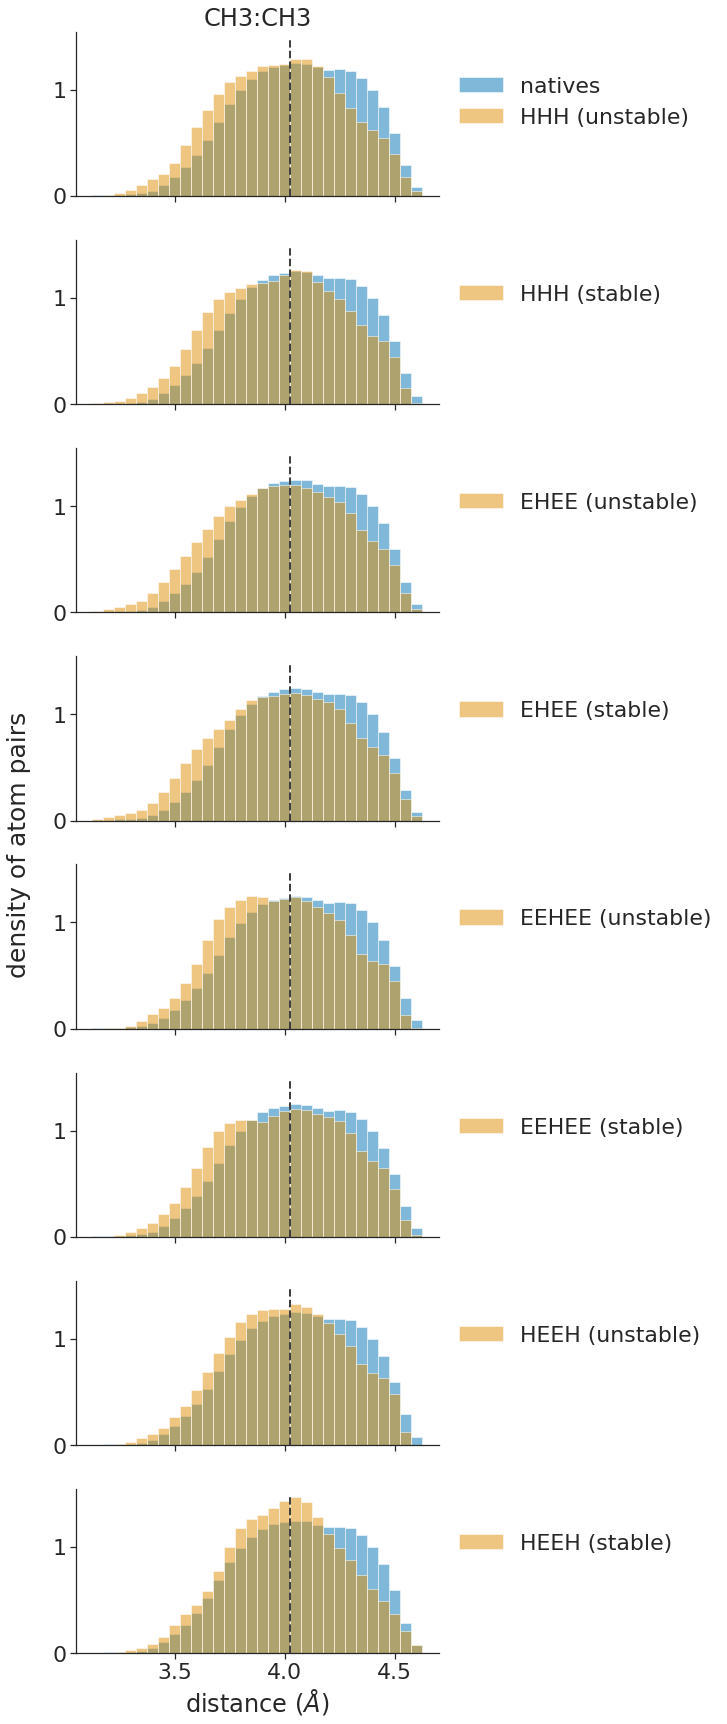


CH3:Hapo


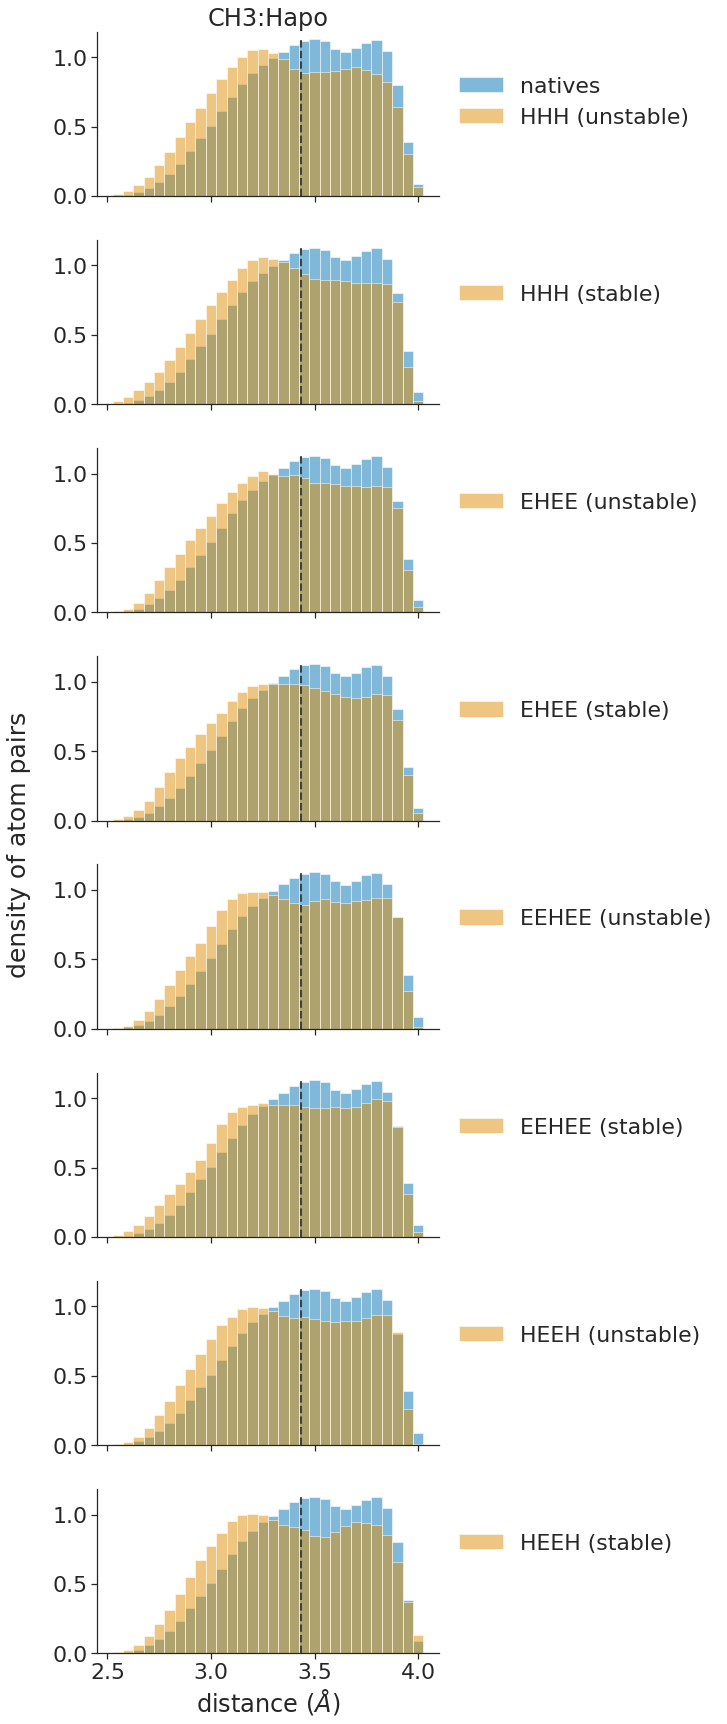


Hapo:Hapo


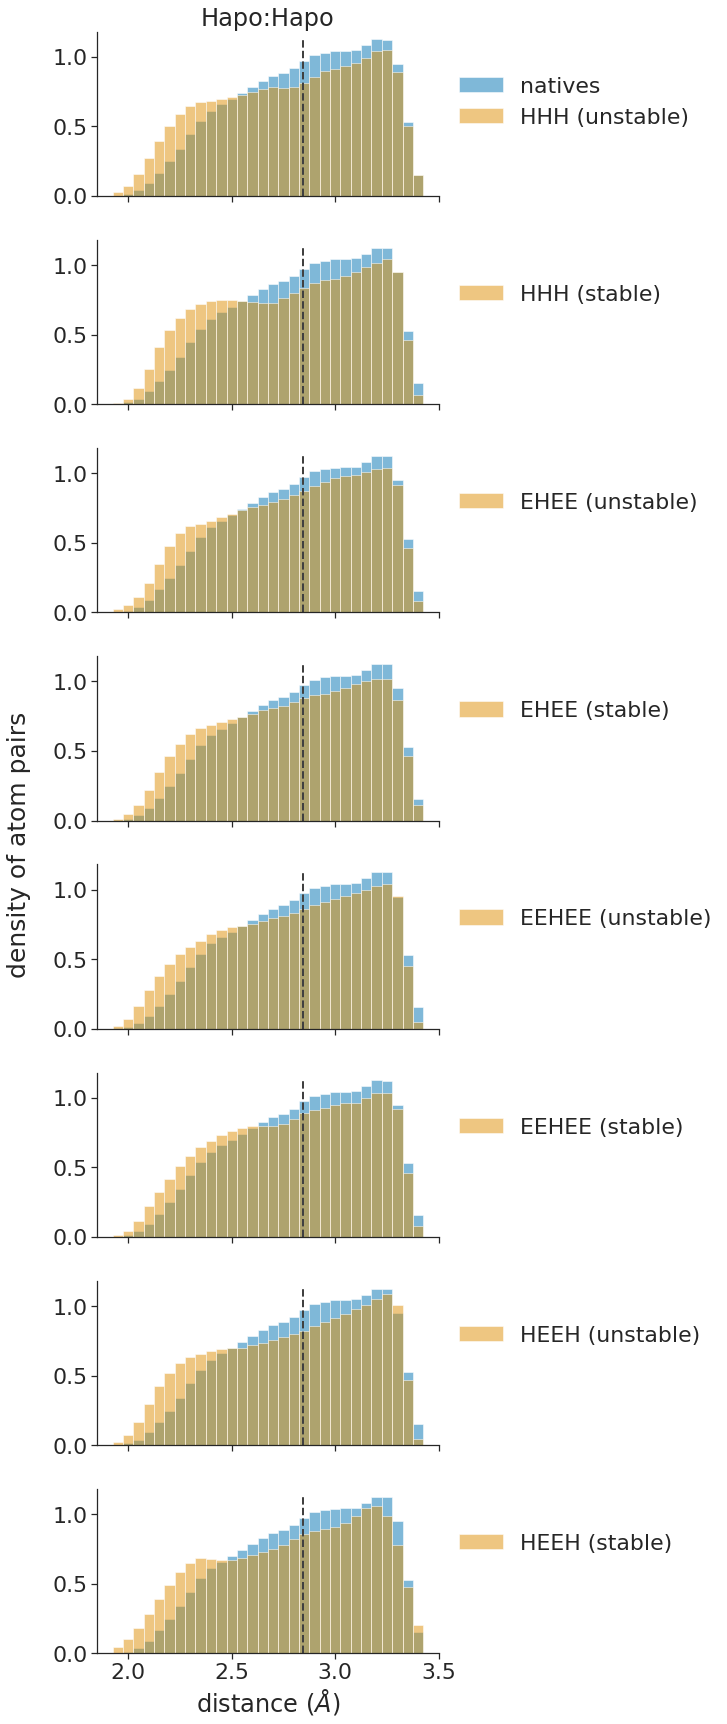

In [71]:
design_pools = [
    #'hbnet_designs',
    #'Rocklin_HHH', #'Rocklin_EHEE', 'Rocklin_EEHEE', 'Rocklin_HEEH',
    'Rocklin_HHH_unstable',
    'Rocklin_HHH_stable',
    'Rocklin_EHEE_unstable',
    'Rocklin_EHEE_stable',
    'Rocklin_EEHEE_unstable',
    'Rocklin_EEHEE_stable',
    'Rocklin_HEEH_unstable',
    'Rocklin_HEEH_stable',
    #'ankyrin_HJ',
    #'DHRs',
    #'helical_oligomer_designs',    
    #'Ali_no_PPI_beta16',
    #'Ali_no_PPI_beta20',
    #'Ali_no_PPI_new_beta20',
    #'Ali_with_PPI_beta16',
    #'Ali_with_PPI_beta20',
    #'Ali_with_PPI_new_beta20',
    
    #'mini_beta_barrel_designs',
    #'mini_beta_barrel_designs_18F',
    #'mini_beta_barrel_natives',
    #'key_beta16',
    #'key_19A',
    #'lockr_key_beta16', 
    #'lockr_key_19A', 
    #'NTF2s_CN',
    #'NTF2_AL_beta_scoring',
    #'NTF2_AL_hugh_scoring',
    
    #'HHH_BC_1',
    #'TERM_designs',
    #'new_miniproteins', 'ferr_BH',
    #'beta_barrels_1', #'beta_barrels_2',
    #'zcons',
    #'Bahl_native', 'Bahl_default', 'Bahl_KillA',
    #'beta16_designs', 'beta20_designs',
    
]
atoms_to_plot = [
    'CH3:CH3',
#     'CH3:OH',
#     'CH3:OCbb', #'CH3:OOC', 'CH3:ONH2', 'CH3:NH2O',
#     'CH2:OCbb', #'CH2:OOC', 'CH2:ONH2', 'CH2:NH2O',
#     'OCbb:aroC',# 'OOC:aroC', 'ONH2:aroC', 'NH2O:aroC',
    'CH3:Hapo',
    'Hapo:Hapo',
#     'CH1:Hapo', 'CH2:Hapo',
#     'CH3:aroC',
#     'aroC:aroC',
#     #'CH1:CH1',
#     'CH1:CH2',
#     'CH1:CH3',
#     'CH2:CH2',
#     'CH2:CH3',
#     'CHR2:CHR2',
]
label_dict = {
    'relax_w_out_symm' : 'relaxed\nnatives',
    'design' : 're-designed\nnatives',
    'miniproteins': '$\it{de}$ $\it{novo}$\ndesigns',
    'hbnet_designs' : 'hbnet'
}

for atoms in atoms_to_plot:
    
    # Get metadata for atom pair
    print(atoms)
    (a1, a2) = atoms.split(':')
    r1 = radius_dict[a1]
    r2 = radius_dict[a2]
    sigma = r1 + r2
    min_d = sigma - 0.9
    max_d = sigma + 0.6
    data = dist_df[
        (dist_df['atoms'] == atoms) &
        (dist_df['design_pool'].isin(design_pools))
    ]
    if len(data) == 0:
        continue
    max_density = data[['ref', 'input']].max().max()
    
    # Plot data
    nrows = len(design_pools)
    (fig, axs) = plt.subplots(
        nrows=nrows, sharex=True, sharey=True,
        figsize=[10, 3*nrows]#[10,3.5*nrows]
    )
    for (i, design_pool) in enumerate(design_pools):

        # Get data for the given design pool
        data = dist_df[
            (dist_df['atoms'] == atoms) &
            (dist_df['design_pool'] == design_pool) &
            (dist_df['distance'].between(min_d, max_d))
        ].copy()
        if len(data) == 0:
            continue
        for col in ['ref', 'input']:
            if col == 'ref':
                if i == 0:
                    label = 'natives'
                else:
                    label = '_nolegend_'
            else:
                label = design_pool.replace(
                    'Rocklin_', ''
                ).replace(
                    '_stable', ' (stable)'
                ).replace(
                    '_unstable', ' (unstable)'
                )
            axs[i].bar(
                x=data['distance'], height=data[col],
                width=0.05, label=label, alpha=0.5,
                linewidth=1
            )

        # Plot the vertical bar showing sigma
        axs[i].plot(
            [sigma, sigma], [0, max_density],
            ls='--', c='0.25', linewidth=2
        )
        
        # Add a title, ylabels, and legends
        if i == 0:
            axs[i].set(title=atoms)
        #axs[i].set(ylabel='density of\natom pairs')
        axs[i].legend(bbox_to_anchor=(1,0.85), frameon=False)
        #axs[i].grid()

    fig.text(
        -0.01, 0.5, 'density of atom pairs',
        ha='center', va='center', rotation='vertical',
        fontsize=25
    )

    plt.tight_layout()
    plt.xlabel('distance $({\AA})$')
    sns.despine()
    plt.show()
    print('')

In [133]:
# Get data for the given design pool
atoms = 'CH3:Hapo'
(a1, a2) = atoms.split(':')
r1 = radius_dict[a1]
r2 = radius_dict[a2]
sigma = r1 + r2
min_d = sigma - 0.9
max_d = sigma + 0.6
design_pool = 'Rocklin_HHH_stable'
data = dist_df[
    (dist_df['atoms'] == atoms) &
    (dist_df['design_pool'] == design_pool) &
    (dist_df['distance'].between(min_d, max_d))
].copy()

def compute_lj_energy(e, o, d):
    energy = e * (math.pow((o/d), 12) - 2 * math.pow((o/d), 6))
    return energy

o = 2.011760 + 1.421272
e = math.sqrt(0.021808 * 0.062642)
data['lj_es'] = data['distance'].apply(lambda x: compute_lj_energy(e, o, x))
data.head()

,distance,ref,input,a1,a2,atoms,e_function,group,design_pool,lj_es
447,2.55,0.001923,0.022458,Hapo,CH3,CH3:Hapo,NaN,NaN,Rocklin_HHH_stable,0.870221
448,2.60,0.009690,0.052966,Hapo,CH3,CH3:Hapo,NaN,NaN,Rocklin_HHH_stable,0.646254
449,2.65,0.027060,0.099011,Hapo,CH3,CH3:Hapo,NaN,NaN,Rocklin_HHH_stable,0.476462
450,2.70,0.056870,0.158389,Hapo,CH3,CH3:Hapo,NaN,NaN,Rocklin_HHH_stable,0.347588
451,2.75,0.102147,0.234097,Hapo,CH3,CH3:Hapo,NaN,NaN,Rocklin_HHH_stable,0.249724


Plot LJ curve

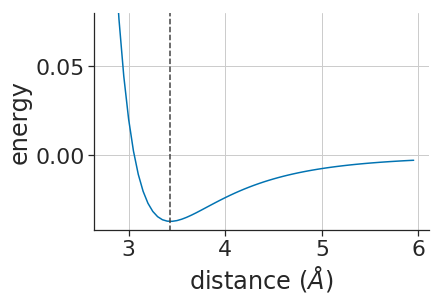

In [145]:
def compute_lj_energy(e, o, d):
    energy = e * (math.pow((o/d), 12) - 2 * math.pow((o/d), 6))
    return energy

o = 2.011760 + 1.421272
eps = math.sqrt(0.021808 * 0.062642)
ds = np.arange(2.8, 6, 0.05)
es = [compute_lj_energy(eps, o, d) for d in ds]
sns.lineplot(ds, es)
plt.plot([o, o], [-eps-0.01, 0.09], ls='--', c='0.25')
plt.grid()
plt.ylim([-eps-0.005, 0.08])
plt.ylabel('energy')
plt.xlabel('distance $({\AA})$')
sns.despine()
plt.show()

In [147]:
o - 0.79

2.6430320000000003

Compare re-designed natives made with different energy functions

In [44]:
import pyrosetta
pyrosetta.init('-ignore_unrecognized_res -mute all -mute core -mute protocols -read_only_ATOM_entries')

Read in native sequences

In [45]:
pdb_dirs = {
    'natives' : '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/',
    'HH_run19A_step266' : 'results/beta_nov16_natives/HH_run19A_step266/design_MonomerDesign2019/',
    'beta16.nostab-refit' : 'results/beta_nov16_natives/beta16.nostab-refit/design_MonomerDesign2019/',
}

In [46]:
for (group, pdb_dir) in pdb_dirs.items():
    output_dir = 'results/beta_nov16_natives/sequences/'
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    seq_f = os.path.join(
        output_dir,
        f'{group}.csv'
    )
    if not os.path.isfile(seq_f):
        seq_dict = {
            key : []
            for key in ['pdb', group]
        }
        pdbs = glob.glob(os.path.join(pdb_dir, '*.pdb'))
        for pdb in pdbs:
            pose = pyrosetta.pose_from_pdb(pdb)
            seq_dict['pdb'].append(
                os.path.basename(pdb).replace('_0001', '')
            )
            seq_dict[group].append(pose.sequence())
        seq_df = pandas.DataFrame(seq_dict)
        seq_df.to_csv(seq_f, index=False)

In [81]:
all_data = pandas.DataFrame()
for (group, pdb_dir) in pdb_dirs.items():
    print(group)
    seq_f = os.path.join(
        'results/beta_nov16_natives/sequences/',
        f'{group}.csv'
    )
    df = pandas.read_csv(seq_f)
    if len(all_data) == 0:
        print('here')
        all_data = df.copy()
    else:
        all_data = all_data.merge(df, on='pdb')
all_data.set_index('pdb', inplace=True)

natives
here
HH_run19A_step266
beta16.nostab-refit


In [130]:
e_function = 'HH_run19A_step266' # 'beta16.nostab-refit' # 

# Initialize dictionary for recording confusion matrix
aas = Bio.Alphabet.IUPAC.IUPACProtein.letters
cm_dict = {}
for i in aas:
    for j in aas:
        cm_dict[(i, j)] = 0

seq_id_dict = {
    key : []
    for key in ['pdb', 'id']
}

# Iterate over each pair of sequences and fill out
# the above dictionaries
for (i, row) in all_data.iterrows():
    seq_i = row['natives']
    seq_j = row[e_function]
    assert len(seq_i) == len(seq_j)
    seq_id_dict['pdb'].append(row.name)
    seq_id_dict['id'].append(
        100 * sum(i == j for (i,j) in zip(seq_i, seq_j)) / \
            len(seq_i)
    )
    for (aa_i, aa_j) in zip(seq_i, seq_j):
        cm_dict[(aa_i, aa_j)] += 1

# Make dataframes from above dictionaries
seq_id_df = pandas.DataFrame(seq_id_dict)
cm_df = {
    key : []
    for key in ['aa'] + list(aas)
}
for aa_i in aas:
    cm_df['aa'].append(aa_i)
    for aa_j in aas:
        cm_df[aa_j].append(cm_dict[(aa_i, aa_j)])
        
cm_df = pandas.DataFrame(cm_df)
cm_df.set_index('aa', inplace=True)

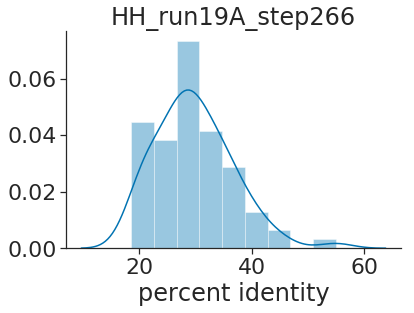

In [131]:
sns.distplot(seq_id_df['id'])
plt.title(e_function)
plt.xlabel('percent identity')
sns.despine()
plt.show()

In [132]:
aas

'ACDEFGHIKLMNPQRSTVWY'

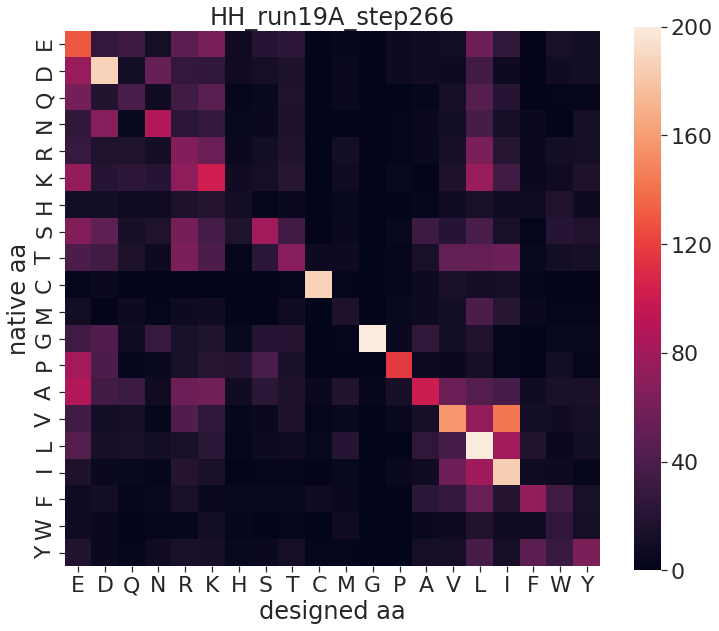

In [133]:
aa_order = list('EDQNRKHSTCMGPAVLIFWY')
plt.figure(figsize=[12,10])
sns.heatmap(
    cm_df.loc[aa_order][aa_order], square=True, vmax=200
)
plt.ylabel('native aa')
plt.xlabel('designed aa')
plt.title(e_function)
plt.show()

**Observations**
* Main trends:
    * A variety of aas often mutate to E, R, or K; less so to D, Q, or N
    * S/T interconvert sometimes
    * With aliphatic, see more conversion within beta-branched group or non-beta branched group, but less in between
    * Most frequent matches are: D, C, G, L

Compare percent identity between pairs of designs

In [72]:
percent_ids = []
pdbs = glob.glob('/home/laukoa/Projects/serine_hydrolase/design/design_triad/round_3/out/design_rp1/*beta_scoring*.pdb')[:20]
for pdb_beta in pdbs:
    
    if 'w_hisp' in pdb_beta:
        continue
    
    # Get matching PDB made with new score function
    pdb_new = pdb_beta.replace('beta_scoring', 'hugh_scoring')
    
    # Get sequences and compute the percent identity
    # between them
    pose_beta = pyrosetta.pose_from_pdb(pdb_beta)
    seq_beta = pose_beta.sequence()
    pose_new = pyrosetta.pose_from_pdb(pdb_new)
    seq_new = pose_new.sequence()
    assert len(seq_beta) == len(seq_new)
    percent_id = 100 * sum([i == j for (i,j) in zip(seq_beta, seq_new)]) / \
        len(seq_beta)
    percent_ids.append(percent_id)

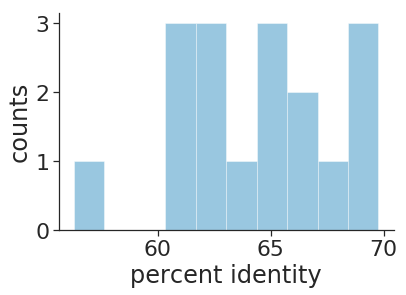

In [73]:
sns.distplot(percent_ids, bins=10, kde=False)
plt.xlabel('percent identity')
plt.ylabel('counts')
sns.despine()
plt.show()

Examine KL-divergence values for individual pairs of atoms

In [32]:
set(kl_df['e_function'])

{'HH_run18E_step147',
 'HH_run19A_step266',
 'HH_run19A_step266_dd2_elec_5_no_scale',
 'HH_run19A_step266_dd2_elec_5a',
 'HH_run19A_step266_dd2_elec_5b',
 'HH_run19A_step266_dd2_elec_5c',
 'HH_run19A_step266_dd2_elec_5e',
 'HH_run19A_step266_dd2_elec_5f',
 'HH_run19A_step266_dd_elec_5_no_scale',
 'HH_run19A_step266_dd_elec_5_no_scale2',
 'HH_run19A_step266_dd_elec_5a',
 'HH_run19A_step266_dd_elec_5b',
 'HH_run19A_step266_dd_elec_5c',
 'HH_run19A_step266_dd_elec_5e',
 'HH_run19A_step266_dd_elec_5f',
 'HH_run19A_step266_dd_elec_5g',
 'HH_run19A_step266_dd_elec_5h_res0.5_pr2.5',
 'HH_run19A_step266_dd_elec_5i',
 'HH_run19A_step266_dd_elec_5j',
 'HH_run19A_step266_dd_elec_5k',
 'HH_run19A_step266_dd_elec_sol_5h_res0.5_pr2.5',
 'HH_run23A_step384',
 'HH_run23A_step384_cf_1a',
 'HH_run23A_step384_cf_1b',
 'HH_run23B_sol_elec_dd2_simple_step169',
 'HH_run23B_sol_elec_dd2_simple_step169_5a2',
 'HH_run23B_sol_elec_dd2_simple_step169_cf_5a2',
 'HH_run23B_sol_elec_dd2_simple_step169_cf_5a3',
 'HH

In [62]:
group = 'beta_nov16_natives' # 'original_ppi_natives' # 'monomers_and_ppi_natives' #
all_atoms = False
relax_type = 'relax_w_out_symm' # 'relax_w_out_symm_cartesian' #
print(group, f'all_atoms:{all_atoms}')
data = kl_df[
    (kl_df['relax_type'] == relax_type) &
    (kl_df['ref_proteins'] == group) &
    (kl_df['all_atoms'] == all_atoms)
].copy()
data = data.pivot_table(
    values='score', columns=['e_function'], index=['atoms']
)

# Add the number of counts of each atom type
n_data = n_df[
    (n_df['ref_proteins'] == group) &
    (n_df['all_atoms'] == all_atoms)
].copy()
n_data.set_index('atoms', inplace=True, verify_integrity=True)
data = data.merge(n_data, left_index=True, right_index=True)

# Compute changes in KL divergence
e_functions = [
    'talaris2014',
    'ref2015',
    'beta16.nostab-refit',
    'HH_run19A_step266',
    'HH_run19A_step266_dd2_elec_5e',
    'HH_run19A_step266_dd_elec_5g',
]
for e_function in e_functions:
    data[f'delta_{e_function}'] = \
        data[e_function] - data['HH_run19A_step266']

# Show changes
cols = [
    'n',
    'HH_run19A_step266',
    'delta_HH_run19A_step266_dd_elec_5g',
    'delta_HH_run19A_step266_dd2_elec_5e',
]
sort_col = cols[2]
atom_str = ''
display(data[
    (data.index.str.contains(atom_str))
].sort_values(sort_col)[cols].head(20))
display(data[
    (data.index.str.contains(atom_str))
].sort_values(sort_col)[cols].tail(20))

beta_nov16_natives all_atoms:False


,n,HH_run19A_step266,delta_HH_run19A_step266_dd_elec_5g,delta_HH_run19A_step266_dd2_elec_5e
atoms,,,,
OCbb:OH,141,0.045425,-0.036487,-0.021335
CH1:CHR1,115,0.050934,-0.024993,-0.017314
CObb:OOC,129,0.029949,-0.019169,-0.014143
CH2:Nbb,199,0.026689,-0.018393,-0.007906
CAbb:CObb,901,0.023215,-0.012544,-0.001275
CObb:OCbb,1708,0.029685,-0.010818,0.001043
CH2:CObb,439,0.015731,-0.010633,-0.002418
HapR:NH2O,161,0.040215,-0.010476,-0.003047
SH1:aroC,125,0.036731,-0.010234,-0.003900


,n,HH_run19A_step266,delta_HH_run19A_step266_dd_elec_5g,delta_HH_run19A_step266_dd2_elec_5e
atoms,,,,
CH0:OCbb,130,0.023747,0.007376,0.003078
CH2:CHR2,415,0.009394,0.007579,-0.000943
HapR:ONH2,142,0.031193,0.007791,0.044716
CAbb:OH,246,0.006435,0.007820,0.005896
HapR:OH,460,0.013984,0.008588,0.001333
HapR:OCbb,1665,0.014570,0.008711,0.003329
CHR2:Narg,108,0.013220,0.009439,-0.004078
CH0:CObb,105,0.023684,0.009810,-0.008886
CObb:Nlys,100,0.024381,0.010083,0.011027


In [ ]:
'OH:OOC', 'OCbb:ONH2', 'OCbb:OOC', 'OCbb:OH',
'CHO:Narg', 'Narg:OOC',
'CHR1:Nlys', 'OOC:Nlys', 'CHR2:Nlys'

In [41]:
print(len(data))
sum(data['delta_HH_run18D_step886_modified6c'] < 0)

91


56

In [50]:
len(set(kl_df[kl_df['ref_proteins'] == 'beta_nov16_natives']['atoms']))

91

Make a heatmap showing KL values

['beta16.nostab-refit', 'HH_run25B_step311_1d']
beta_nov16_natives


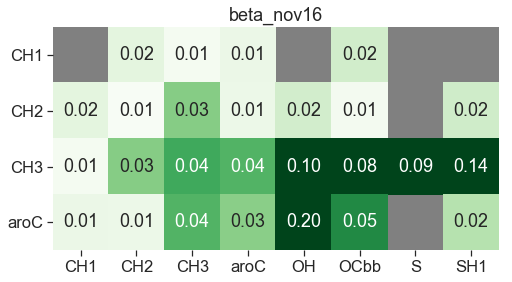

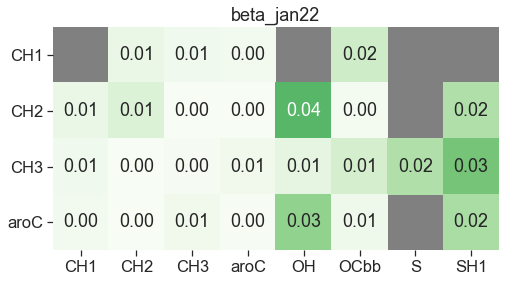

In [34]:
# Get data of interest
e_functions = [
    'beta16.nostab-refit',
    'HH_run25B_step311_1d',
    #'HH_run18D_step886_modified6f',
    #'HH_run18F_step434',
    #'HH_run18F_step434_mod6f',
    #'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14',
]
print(e_functions)
e_function_labels = {
    'beta16.nostab-refit' : 'beta_nov16',
    'HH_run18D_step886_modified6f' : '18D',
    'HH_run18F_step434' : '18F',
    'HH_run18F_step434_mod6f' : '18F_mod6f',
    #'HH_run23B_sol_elec_dd2_simple_step169_cfnp_5a3_14' : 'beta_jan22',
    'HH_run25B_step311_1d' : 'beta_jan22',
}
ref_proteins = 'beta_nov16_natives' # 'beta_nov16_natives_validation' # 'original_ppi_natives' # 
print(ref_proteins)
relax_type = 'relax_w_out_symm_cartesian'
all_atoms = True
atoms_y = [
    'CH1', 'CH2', 'CH3', 'aroC', #'CHR1', 'CHR2'
    #'CH1', 'CH2', 'CH3', 'aroC',
]
atoms_x = [
    'CH1', 'CH2', 'CH3', #'Hapo',
    #'CHR1', 'CHR2', #'HapR',
    'aroC', #'Haro',
    'OH', 'OCbb',
    #'OOC', 'ONH2',
    'S', 'SH1',
    #'NH2O', 'Narg', 'Nlys', 'Nbb',
]
if False:
    atoms_x = ['OCbb', 'CObb', 'CAbb']
    atoms_y = [
        'OCbb', 'CObb', 'CAbb',
        'CH1', 'CH2', 'CH3', 'aroC',
        #'CHR1', 'CHR2'
    ]
    
for e_function in e_functions:
    data = kl_df[
        (kl_df['e_function'] == e_function) &
        (kl_df['relax_type'] == relax_type) &
        (kl_df['ref_proteins'] == ref_proteins) &
        (kl_df['all_atoms'] == all_atoms)
    ].copy()
    assert len(data['atoms']) == len(set(data['atoms']))
    data_switch = data.copy()
    data_switch.rename(columns = {'a1':'a2', 'a2':'a1'}, inplace=True)
    data = pandas.concat([data, data_switch], sort=False)

    data = data.pivot_table(
        values='kldiv', columns=['a2'], index=['a1']
    )

    # Get data for specific atoms   
    data_to_plot = data[atoms_x].loc[atoms_y]

    # Make plot
    sns.set(font_scale=1.5, style='ticks', palette = 'colorblind')
    plt.figure(figsize=[8,12])
    g = sns.heatmap(
        data_to_plot, annot=True, cmap='Greens',
        fmt='.2f', square=True, cbar=False, vmax=0.06
    )
    g.set_facecolor('0.5')
    plt.title(e_function_labels[e_function])
    plt.yticks(rotation=0)
    plt.xticks(rotation=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

In [112]:
data = kl_df[
    #(kl_df['e_function'] == e_function) &
    (kl_df['relax_type'] == relax_type) &
    (kl_df['ref_proteins'] == ref_proteins) &
    (kl_df['all_atoms'] == all_atoms)
].copy()
data.head()

,a1,a2,kldiv,score,ref_proteins,relax_type,e_function,all_atoms,atoms
0,OCbb,aroC,0.025544,0.025544,beta_nov16_natives,relax_w_out_symm_cartesian,beta16.nostab-refit,True,OCbb:aroC
1,CH2,CH3,0.018624,0.018624,beta_nov16_natives,relax_w_out_symm_cartesian,beta16.nostab-refit,True,CH2:CH3
2,CH2,Hapo,0.007437,0.007437,beta_nov16_natives,relax_w_out_symm_cartesian,beta16.nostab-refit,True,CH2:Hapo
3,CH3,CH3,0.038127,0.038127,beta_nov16_natives,relax_w_out_symm_cartesian,beta16.nostab-refit,True,CH3:CH3
4,Hapo,CH3,0.018125,0.018125,beta_nov16_natives,relax_w_out_symm_cartesian,beta16.nostab-refit,True,CH3:Hapo


In [113]:
set(data['e_function'])

{'HH_run18D_step886_modified6f', 'beta16.nostab-refit'}

**Observations**:

* Which things got worse?
    * getting too close:
        * OCbb:OH
        * CH1:OCbb
        * OCbb:OCbb
        * CObb:CAbb
        * CAbb:OOC
        * CH2:COO
        * Nlys:COO
    
    * not getting close enough
        * S:CH2
        * Narg:CH3
        * CH3:NtrR (?)
        * CH2:NtrR (?)
    

Examine changes by energy function

In [11]:
group = 'original_ppi_natives' # 'beta_nov16_natives' # 
data = kl_df[
    (kl_df['relax_type'] == 'relax_w_out_symm') &
    (kl_df['group'] == group)
].copy()
data = data.pivot_table(
    values='score', columns=['e_function'], index=['atoms']
)

# Add the number of counts of each atom type
n_data = n_df[n_df['group'] == group].copy()
n_data.set_index('atoms', inplace=True, verify_integrity=True)
data = data.merge(n_data, left_index=True, right_index=True)

cols = [
    'n',
    'beta_nov16',
    'HH_run17_step403',
    'HH_run17D_step36',
    'HH_run18B_step220'
]
e_function = 'HH_run18B_step220'
data.sort_values(e_function, ascending=False)[cols].head(20)

,n,beta_nov16,HH_run17_step403,HH_run17D_step36,HH_run18B_step220
atoms,,,,,
OOC:CNH2,109,0.105371,0.089523,0.103539,0.138677
OH:OOC,337,0.177834,0.160959,0.140725,0.134924
OCbb:ONH2,174,0.124467,0.097330,0.118609,0.104525
OCbb:Nlys,321,0.093766,0.106723,0.100024,0.102140
Nbb:NH2O,260,0.082060,0.088574,0.095517,0.100173
OCbb:OOC,114,0.094727,0.095525,0.090777,0.078822
Nlys:COO,206,0.029106,0.055346,0.072845,0.075817
COO:NtrR,159,0.093324,0.065579,0.064738,0.070870
CH1:NH2O,110,0.048134,0.053253,0.058222,0.068719


**Observations**:
* which things have the worst kldiv values?
    * getting too close:
        * CH3:SH1 / CH3:S
        * OCbb:OCbb
        * OH:OCbb

    * not getting close enough:
        * OH:OOC
        * Nlys:aroC
        * Narg:CH3

* Trends
    * Hbond donors not getting close enough to OOC and OCbb
    * Polar atoms not getting close enough to non-polar atoms

In [12]:
kl_df[
    (kl_df['n'] > 200) &
    (kl_df.index.str.contains('CH3'))
].sort_values('delta_HH_run17D_step36')[cols]

KeyError: 'n'

**Observations**
* Values always get worse between beta_nov16 and run17, but then always get better between beta_nov16 and run17D
* The above patterns are apparent in the plots

***

* OCbb_Hpol
    * decoys are systematically shifted to the left, suggesting increased overlap
    * due to CObb_OCbb getting too long? Allowing for overlap?
    * due to bb-bb Hbonding between NH and OCbb?
    * do the two peaks correspond to different SSs? e.g., helices vs. antiparallel vs. parallel strands?
* CObb_OCbb
    * decoys are systematically shifted to the left, suggesting that this bond is getting longer than it normally is allowed to be
    * cart_bonded allowing the bond to get too long?
    * too much attraction between NH and OCbb?
* CObb_Hpol
    * decoys are systematically shifted to the left, suggesting increased overlap
    * similar reasons to above?
* OCbb_OCbb
    * decoys are systematically shifted to the left, suggesting increased closeness
    * somehow due to the reasons above?
    * or somehow bending towards each other in strands?
* Ideas:
    * cart_bonded allowing CObb_OCbb bond length to be too long?
    * radius too small / attraction too much?
        * Hpol
        * OCbb
    * radius too big / attraction too little?

To do:
* Look at the distribution of OCbb-Hpol in designs, starting with NH and OCbb?

**Observations**
Red - native
Green - decoy

* Does the distribution benchmark capture the problems that we're seeing with designs?
    * Hapo-Hapo
        * see with beta_nov16
        * gets worse with 17
        * gets better with 17D, but still worse than beta_nov16
    * C-C:
        * see with beta_nov16 (CH3_CH3, CH1_CH3, CH2_CH3)
        * gets worse with 17 (CH3_CH3, CH1_CH3, CH2_CH3)
        * best with 17D (CH3_CH3, CH1_CH3, CH2_CH3)
    * C-Hapo:
        * CH3-Hapo
    * CH1-Haro
    * New problems?
        * OCbb_Hpol
        * CH2-OH
        * CObb-Haro
* Did we fix anything?

* Did we break anything with 17?
    * Some distributions get worse with HH_run17, but then get better with HH_run17D, possibly because of how fa_sol can add attractive or repulsive forces
        * e.g., CH3-CH3
        
* Did we break anything with 17D?

## Compute distributions of inter-atomic distances

Compute distances for crystal structures before relaxing them.

In [28]:
pdb_group = 'beta_nov16_natives'
pdb_dir = native_pdb_dirs[pdb_group]
pdb_files = glob.glob(os.path.join(pdb_dir, '*.pdb'))
output_dir = os.path.join(
    resultsdir,
    'atom_pair_energies',
    pdb_group
)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
for pdb_file in pdb_files:
    pdb_basename = os.path.basename(pdb_file).replace('.pdb', '')
    output_file = os.path.join(output_dir, f'{pdb_basename}.csv')
    cmd = [
        'python',
        'scripts/compute_energies_between_atom_pairs.py',
        f'--pdb_file {pdb_file}',
        f'--output_file {output_file}'
    ]
    cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
        + ' '.join(cmd)
    sbatch_file = os.path.join(output_dir,f'{pdb_basename}.sbatch')
    if not os.path.isfile(sbatch_file):
        design_utils.WriteSbatchFile(
            sbatch_file,
            command=cmd,
            queue_type='short',
            memory='10g'
        )
        ! sbatch {sbatch_file}

Compute distances for structures after relaxing them with each of the above energy functions.

In [29]:
# Loop over energy functions and compute inter-atomic distances
# for structures relaxed with each one
e_functions = [
    'beta_nov16', #'HH_run17_step403',
    'HH_run18B_step220' #'HH_run17D_step36'#
]
pdb_group = 'beta_nov16_natives'
for e_function in e_functions:
    pdb_dir = os.path.join(
        resultsdir,
        pdb_group,
        e_function,
        'relax_w_out_symm/'
    )
    output_dir = os.path.join(
        resultsdir,
        'atom_pair_energies',
        pdb_group,
        e_function
    )
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    # Assemble command and compute data for each structure
    pdb_files = glob.glob(os.path.join(pdb_dir, '*.pdb'))
    for pdb_file in pdb_files:

        # Assemble the command
        design = os.path.basename(pdb_file).replace('.pdb', '')
        output_file = os.path.join(output_dir, f'{design}.csv')
        cmd = [
            'python',
            'scripts/compute_energies_between_atom_pairs.py',
            f'--pdb_file {pdb_file}',
            f'--output_file {output_file}'
        ]
        cmd = 'source activate high_throughput_design_for_E_function_opt\n'\
            + ' '.join(cmd)    

        # Submit the command
        sbatch_file = os.path.join(output_dir,f'{design}.sbatch')
        if not os.path.isfile(sbatch_file):
            design_utils.WriteSbatchFile(
                sbatch_file,
                command=cmd,
                queue_type='short',
                memory='10g'
            )
            ! sbatch {sbatch_file}

In [30]:
groups = [
    'beta_nov16_natives', 'beta_nov16',
    'HH_run18B_step220'
]
natives = groups[0]
dfs = []
for group in groups:
    csvs_dir = f'results/atom_pair_energies/{natives}'
    if 'natives' not in group:
        csvs_dir = os.path.join(csvs_dir, group)
    csvs = glob.glob(os.path.join(csvs_dir, '*.csv'))
    print(group, len(csvs))
    for csv in csvs:
        df = pandas.read_csv(csv)
        df = df[
            (df['d'] < 5) &
            (df['d-o'] < 0.5)
        ]
        df['group'] = group
        dfs.append(df)
energies_df = pandas.concat(dfs, sort=False)
del dfs

#energies_df['d-o'] = energies_df['d'] - energies_df['o']
#energies_df = energies_df[energies_df['d-o'] < 0.5]

energies_df['id'] = energies_df.apply(
    lambda row: '{0}_{1}-{2}-{3}-{4}'.format(
        row['pdb'][:4],
        row['res_i_n'], row['atom_i_n'],
        row['res_j_n'], row['atom_j_n']
    ), axis=1
)

energies_df.set_index('id', inplace=True)

beta_nov16_natives 78
beta_nov16 78
HH_run18B_step220 74


In [31]:
# For each pairwise contact, count the number of atoms
# that come from an aliphatic residue
aliphatic_aas = ['ALA', 'VAL', 'ILE', 'LEU', 'MET']
energies_df['n_aliphatic'] = energies_df.apply(
    lambda row: sum([
        (row['res_i_name'] in aliphatic_aas),
        (row['res_j_name'] in aliphatic_aas)
    ]),
    axis=1
)

# ... or a polar residue
polar_aas = [
    'ARG', 'HIS', 'LYS', 'ASP', 'GLU', 'ASN', 'GLN', 'SER', 'THR'
]
energies_df['n_polar'] = energies_df.apply(
    lambda row: sum([
        (row['res_i_name'] in polar_aas),
        (row['res_j_name'] in polar_aas)
    ]),
    axis=1
)

In [ ]:
groups = [
    'beta_nov16_natives', 'beta_nov16',
    'HH_run18B_step220'
]   
natives = groups[0] #'HH_run17D_natives'
assert 'natives' in natives
atom_group = 'aliphatic_C_C'
#atom_group = 'CH3:S' # 'CH2:Nbb' #'CH3:OCbb' #'CH3:CObb' # 
print(pdb_groups)
print(atom_group, natives)
data = energies_df[
    (energies_df['pdb_group'].isin(pdb_groups)) &
    (energies_df['d-o'] < 0.5) &
    (energies_df['res_i_n'] != energies_df['res_j_n']) &
    (energies_df[atom_group] == True)
].copy()
metric = 'd-o'

# Compute the cumulative density of values
cd_dict = {
    key : []
    for key in [metric, 'pdb_group', 'cd']
}
min_range = -1 #data[metric].min()
max_range = 0.5 #data[metric].max()
nbins = 30
bin_size = (max_range - min_range) / nbins
bins = np.arange(min_range, max_range+bin_size, bin_size)
for bin_min in bins:
    for pdb_group in pdb_groups:
        if sum(data['pdb_group'] == pdb_group) == 0:
            continue
        cd_dict[metric].append(bin_min)
        cd_dict['pdb_group'].append(pdb_group)
        cd = sum(
            (data['pdb_group'] == pdb_group) &
            (data[metric] <= bin_min)
        ) / sum(data['pdb_group'] == pdb_group)
        cd_dict['cd'].append(cd)
cd_df = pandas.DataFrame(cd_dict)

# Plot data
nrows = len(pdb_groups[1:])
(fig, axs) = plt.subplots(
    ncols=1, nrows=nrows, sharey=True, sharex=True,
    figsize=[7,1.9*nrows]
)
xlim = [min_range, max_range]
for (i, pdb_group) in enumerate(pdb_groups[1:]):
    
    # Plot data for natives
    data_i = data[data['pdb_group'] == natives]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label='natives', bins=bins, ax=axs[i]
    )
    
    # Plot data for the group of designs
    data_i = data[data['pdb_group'] == pdb_group]
    sns.distplot(
        data_i[metric], kde=False, norm_hist=True,
        label='designs', bins=bins, ax=axs[i]
    )
    if i == 0:
        axs[i].legend(bbox_to_anchor=(1.5,1))
    axs[i].plot([0, 0], [0, 1.4], ls='--', c='0.25')
    if False:
        axs[i].text(
            0.05, 0.82,
            pdb_group.replace(
                '_beta16.nostab-refit', ''
            ).replace('_HH_run17D_step36', '').replace(
                '_cart', ''
            ).replace('3h_1018', 'HHH_65aa'),
            transform=axs[i].transAxes, fontsize=20
        )
    if i == nrows - 1:
        axs[i].set(
            ylabel='', xlabel='$d-\sigma$', xlim=xlim
        )
    else:
        axs[i].set(
            ylabel='', xlabel='', xlim=xlim
        )

plt.tight_layout(h_pad=1.0)
sns.despine()
plt.show()

beta_nov16 0.0 1598
HH_run17_step403 -0.012 1420
HH_run17D_step36 -0.015 1417


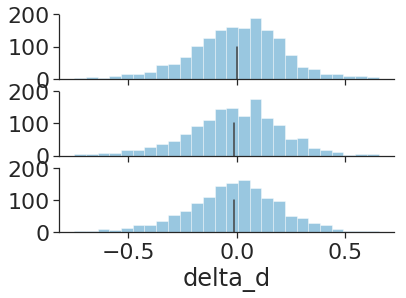

In [16]:
e_functions = [
    'beta_nov16', 'HH_run17_step403', 'HH_run17D_step36'
]
(fig, axs) = plt.subplots(
    nrows=len(e_functions), sharex=True, sharey=True
)
min_val = -0.75 #df['delta_d'].min()
max_val = 0.6 #df['delta_d'].max()
nbins = 25
bin_size = (max_val - min_val) / nbins
bins = np.arange(min_val, max_val + (2* bin_size), bin_size)

for (i, e_function) in enumerate(e_functions):
    df1 = energies_df[energies_df['group'] == 'natives'].copy()
    df2 = energies_df[energies_df['group'] == e_function].copy()
    data = df1.merge(
        df2[['d', 'd-o']], left_index=True, right_index=True,
        how='inner'
    )
    del [df1, df2]
    data['delta_d'] = data['d_y'] - data['d_x']

    # Select data
    if False:
        #print("Showing data for atom pairs with at least one HA")
        data = data[
            ((data['atom_i_name'] == 'HA') |
            (data['atom_j_name'] == 'HA'))
        ]
    else:
        #print("Showing data for atom pairs from side chains")
        data = data[
            (data['n_polar'] == 2) &
            (data['atom_i_name'] != 'HA') &
            (data['atom_j_name'] != 'HA')
        ]
    mean_delta = round(data['delta_d'].mean(), 3)
    print(e_function, mean_delta, len(data))

    # Plot data
    sns.distplot(data['delta_d'], bins=bins, kde=False, ax=axs[i])
    axs[i].plot(
        [mean_delta, mean_delta], [0,100], ls='-', c='0.25'
    )
    if i != len(e_functions)-1:
        axs[i].set(xlabel='')

sns.despine()
plt.show()

In [17]:
cols = [
    #'res_i_n', 'res_i_pdb_n',
    'res_i_name', 'atom_i_name',
    #'res_j_n', 'res_j_pdb_n',
    'res_j_name', 'atom_j_name',
    'delta_d', 'd-o_y', 'd_y', 'n_polar'
]
data.sort_values('d-o_y', ascending=True, inplace=True)
data[data['delta_d'] > 0.1][cols].head(n=10)

,res_i_name,atom_i_name,res_j_name,atom_j_name,delta_d,d-o_y,d_y,n_polar
id,,,,,,,,
2o9u_73-11-87-16,ASP,1HB,ARG,1HG,0.117150,-0.738033,2.104511,2
1lu4_63-14-64-17,THR,3HG2,ARG,2HG,0.191437,-0.724287,2.118257,2
1zma_66-12-69-12,ASN,2HB,GLU,1HB,0.119968,-0.698337,2.144207,2
2ra9_27-15-80-13,LYS,2HG,THR,2HG2,0.136713,-0.682609,2.159935,2
1zlm_42-10-47-13,THR,HB,THR,2HG2,0.110581,-0.673226,2.169318,2
2o9u_76-14-83-16,GLU,1HG,ARG,1HG,0.198296,-0.664625,2.177919,2
2wwe_6-10-33-12,SER,2HB,ASN,2HB,0.105531,-0.660346,2.182198,2
1aho_32-12-50-12,GLU,1HB,LYS,1HB,0.114333,-0.636554,2.205990,2
3nbm_91-10-94-12,SER,2HB,LYS,1HB,0.169557,-0.617747,2.224797,2


See which atom pairs are moving the most

In [18]:
groups = [
    'natives', 'HH_run18B_step220' # 'HH_run17_step403' #'beta_nov16' #
]
df1 = energies_df[energies_df['group'] == groups[0]].copy()
df2 = energies_df[energies_df['group'] == groups[1]].copy()
data = df1.merge(
    df2[['d', 'd-o']], left_index=True, right_index=True, how='inner'
)
del [df1, df2]
data['delta_d'] = data['d_y'] - data['d_x']

# Select data
if True:
    data = data[
        (data['n_aliphatic'] == 2) &
        (data['delta_d'] < -0.3)
    ]
print(len(data), data['delta_d'].mean())

# Display dataframe
cols = [
    'res_i_pdb_n', #'res_i_n', 
    'res_i_name', 'atom_i_name',
    'res_j_pdb_n', #'res_j_n', 
    'res_j_name', 'atom_j_name',
    'delta_d', 'd-o_y', 'd_y'
]
data.sort_values('d-o_y', ascending=True, inplace=True)
data[cols].head(20)

1082 -0.42931457409813367


,res_i_pdb_n,res_i_name,atom_i_name,res_j_pdb_n,res_j_name,atom_j_name,delta_d,d-o_y,d_y
id,,,,,,,,,
2chh_32-15-62-13,32,VAL,2HG2,62,ILE,2HG1,-0.300020,-0.645759,2.196785
2o9u_8-19-38-10,1008,ILE,3HD1,1038,ILE,HA,-0.353284,-0.613800,2.228744
2oss_112-10-115-15,153,LEU,HA,156,LEU,2HD1,-0.629917,-0.609626,2.232918
3cx2_16-10-22-11,166,VAL,HB,172,ILE,HB,-0.323541,-0.601280,2.241264
1euw_14-11-20-19,14,VAL,1HG1,20,LEU,3HD2,-0.397600,-0.592594,2.249950
1ufy_49-12-88-10,49,VAL,2HG1,88,ILE,HA,-0.342419,-0.586835,2.255709
1xt5_24-17-129-11,24,LEU,1HD2,129,LEU,1HB,-0.516397,-0.585774,2.256770
2i4a_38-19-93-7,38,ILE,3HD1,93,ALA,HA,-0.608764,-0.579226,2.263318
1cxq_104-7-107-15,159,ALA,HA,162,LEU,2HD1,-0.479424,-0.577419,2.265125


In [19]:
CH3_atom_types = [
    ('ALA', '1HB'), ('ALA', '2HB'), ('ALA', '3HB'),
    ('LEU', '1HD1'), ('LEU', '2HD1'), ('LEU', '3HD1'),
    ('LEU', '1HD2'), ('LEU', '2HD2'), ('LEU', '3HD2'),
    ('ILE', '1HG2'), ('ILE', '2HG2'), ('ILE', '3HG2'),
    ('ILE', '1HD1'), ('ILE', '2HD1'), ('ILE', '3HD1'),
    ('VAL', '1HG1'), ('VAL', '2HG1'), ('VAL', '3HG1'),
    ('VAL', '1HG2'), ('VAL', '2HG2'), ('VAL', '3HG2'),
    ('MET', '1HE'), ('MET', '2HE'), ('MET', '3HE')
]
energies_df['atom_i_from_CH3'] = energies_df.apply(
    lambda row: \
        (row['res_i_name'], row['atom_i_name']) in CH3_atom_types,
    axis=1
)
energies_df['atom_j_from_CH3'] = energies_df.apply(
    lambda row: \
        (row['res_j_name'], row['atom_j_name']) in CH3_atom_types,
    axis=1
)

energies_df['n_atoms_from_CH3'] = energies_df.apply(
    lambda row: sum([row['atom_i_from_CH3'], row['atom_j_from_CH3']]),
    axis=1
)

Compare d-o distributions between natives and relaxed designs

In [23]:
energies_df['atom_pair_type'] = energies_df.apply(
    lambda row: ':'.join(sorted([
        row['atom_i_type_name'], row['atom_j_type_name']
    ])), axis=1
)

In [24]:
set(energies_df['atom_pair_type'])

{'CAbb:CAbb',
 'CAbb:CH0',
 'CAbb:CH1',
 'CAbb:CH2',
 'CAbb:CH3',
 'CAbb:CNH2',
 'CAbb:COO',
 'CAbb:CObb',
 'CAbb:HNbb',
 'CAbb:HS',
 'CAbb:Hapo',
 'CAbb:Haro',
 'CAbb:Hpol',
 'CAbb:NH2O',
 'CAbb:Narg',
 'CAbb:Nbb',
 'CAbb:Nhis',
 'CAbb:Nlys',
 'CAbb:Npro',
 'CAbb:NtrR',
 'CAbb:Ntrp',
 'CAbb:OCbb',
 'CAbb:OH',
 'CAbb:ONH2',
 'CAbb:OOC',
 'CAbb:S',
 'CAbb:SH1',
 'CAbb:VIRT',
 'CAbb:aroC',
 'CH0:CH0',
 'CH0:CH1',
 'CH0:CH2',
 'CH0:CH3',
 'CH0:CNH2',
 'CH0:COO',
 'CH0:CObb',
 'CH0:HNbb',
 'CH0:HS',
 'CH0:Hapo',
 'CH0:Haro',
 'CH0:Hpol',
 'CH0:NH2O',
 'CH0:Narg',
 'CH0:Nbb',
 'CH0:Nhis',
 'CH0:Nlys',
 'CH0:Npro',
 'CH0:NtrR',
 'CH0:Ntrp',
 'CH0:OCbb',
 'CH0:OH',
 'CH0:ONH2',
 'CH0:OOC',
 'CH0:S',
 'CH0:SH1',
 'CH0:aroC',
 'CH1:CH1',
 'CH1:CH2',
 'CH1:CH3',
 'CH1:CNH2',
 'CH1:COO',
 'CH1:CObb',
 'CH1:HNbb',
 'CH1:HS',
 'CH1:Hapo',
 'CH1:Haro',
 'CH1:Hpol',
 'CH1:NH2O',
 'CH1:Narg',
 'CH1:Nbb',
 'CH1:Nhis',
 'CH1:Nlys',
 'CH1:Npro',
 'CH1:NtrR',
 'CH1:Ntrp',
 'CH1:OCbb',
 'CH1:OH',
 'CH1:ONH

natives 0
beta_nov16 182
natives 0
HH_run18B_step220 182


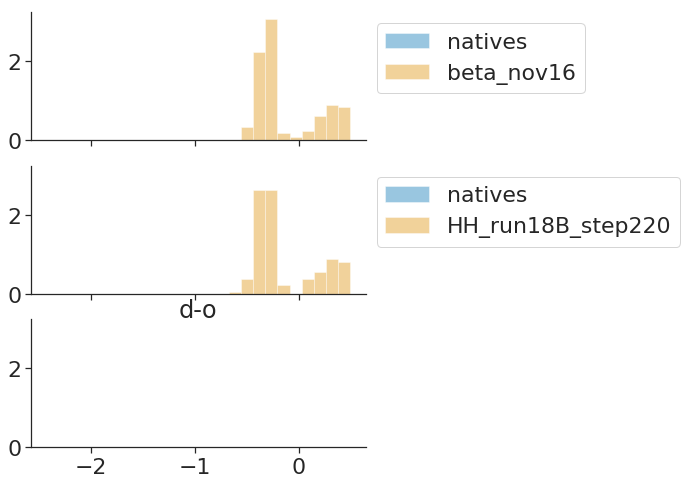

In [25]:
min_val = energies_df['d-o'].min()
max_val = energies_df['d-o'].max()
nbins = 25
bin_size = (max_val - min_val) / nbins
bins = np.arange(min_val, max_val + (bin_size), bin_size)

e_functions = ['beta_nov16', 'HH_run18B_step220']
(fig, axs) = plt.subplots(
    nrows=3, sharex=True, sharey=True, figsize=[6,8]
)
if True:
    data = energies_df[
        #(energies_df['n_polar'] == 2) &
        #(energies_df['n_aliphatic'] == 2) &
        #(energies_df['n_atoms_from_CH3'] == 1) &
        (energies_df['atom_pair_type'] == 'OH:OOC')
    ].copy()

else:
    print("Showing data for paris with an HA")
    data = energies_df[
        ((energies_df['atom_i_name'] == 'HA') |
        (energies_df['atom_j_name'] == 'HA'))
    ].copy()

#data = energies_df.copy()
groups = ['natives'] + e_functions
common_indices = None
for group in groups:
    indices = set(data[
        (data['group'] == group)
    ].index.values)
    if not common_indices:
        common_indices = indices
    else:
        common_indices = set.intersection(common_indices, indices)
        
for (i, e_function) in enumerate(e_functions):
    groups = [
        'natives', e_function
    ]
    for group in groups:
        data_i = data[
            (data['group'] == group) &
            (data.index.isin(common_indices))
        ]
        print(group, len(data_i))
        sns.distplot(
            data_i['d-o'], label=group, bins=bins, kde=False,
            norm_hist=True, ax=axs[i]
        )
    if i != len(e_functions) - 1:
        axs[i].set(xlabel='')

    axs[i].legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

**Observations**:
* Hapos from two aliphatic side chains
    * 17 gets worse: overpacking
    * 17D shifts to the right: less packing -> missing some larger overlaps?
    * this is true for CH3-CH3; nonCH3-nonCH3; CH3-nonCH3
* Hapos from one aliphatic side chain
    * 17D not permissive enough?
* Hapos from two polar side chains
    * both 17 and 17D look slightly better
* Hapos with at least one HA
    * worse for 17, a bit worse for 17D, but not a lot

In [21]:
group = 'natives' # 'beta_nov16' #  
data_i = data[
    (data['group'] == group) &
    (data.index.isin(common_indices))
].copy()
data_i.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'res_i_n', 'res_i_name', 'atom_i_name', 'atom_i_type_name',
    'res_j_n', 'res_j_name', 'atom_j_name', 'atom_j_type_name',
    'd-o', 'n_atoms_from_CH3'
]
data_i[cols].head(n=20)

,res_i_n,res_i_name,atom_i_name,atom_i_type_name,res_j_n,res_j_name,atom_j_name,atom_j_type_name,d-o,n_atoms_from_CH3
id,,,,,,,,,,
1lu4_63-14-64-17,63,THR,3HG2,Hapo,64,ARG,2HG,Hapo,-0.915724,0
2r2z_66-10-79-15,66,THR,HB,Hapo,79,ARG,2HB,Hapo,-0.910774,0
2gzv_51-13-84-12,51,GLU,2HB,Hapo,84,ASN,2HB,Hapo,-0.877777,0
2o9u_76-14-83-16,76,GLU,1HG,Hapo,83,ARG,1HG,Hapo,-0.862921,0
2o9u_73-11-87-16,73,ASP,1HB,Hapo,87,ARG,1HG,Hapo,-0.855183,0
2g6f_33-15-41-13,33,ARG,2HB,Hapo,41,GLU,2HB,Hapo,-0.836774,0
2ra9_27-15-80-13,27,LYS,2HG,Hapo,80,THR,2HG2,Hapo,-0.819321,0
1zma_66-12-69-12,66,ASN,2HB,Hapo,69,GLU,1HB,Hapo,-0.818305,0
1t2i_5-13-93-11,5,THR,2HG2,Hapo,93,ASP,1HB,Hapo,-0.815276,0


H-H distances between atoms from proline and other atoms

1075 0.019575272109549017


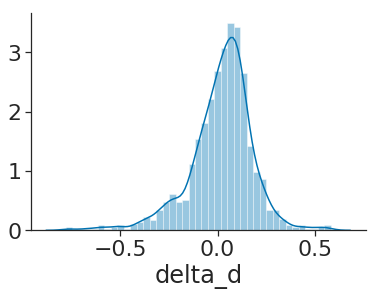

,res_i_n,res_i_name,atom_i_name,atom_i_type_name,res_j_n,res_j_name,atom_j_name,atom_j_type_name,delta_d,d-o
id,,,,,,,,,,
1jf8_66-14-89-14,66,ILE,1HG2,Hapo,89,PRO,1HD,Hapo,-0.781666,0.253851
2qsk_45-14-49-15,45,PRO,1HD,Hapo,49,PRO,2HD,Hapo,-0.748421,0.384998
2fe5_91-19-92-14,91,LYS,2HE,Hapo,92,PRO,1HD,Hapo,-0.689852,0.443407
1z2u_4-17-64-14,4,MET,3HE,Hapo,64,PRO,1HD,Hapo,-0.660642,0.399020
2ra9_85-13-100-14,85,VAL,3HG1,Hapo,100,PRO,1HD,Hapo,-0.630599,0.422699
2fe5_56-10-92-15,56,ASP,HA,Hapo,92,PRO,2HD,Hapo,-0.602957,0.122148
1jf8_66-19-89-14,66,ILE,3HD1,Hapo,89,PRO,1HD,Hapo,-0.592857,0.000018
2nqw_48-19-55-15,48,LEU,3HD2,Hapo,55,PRO,2HD,Hapo,-0.584117,0.157300
1z2u_13-18-28-15,13,LEU,2HD2,Hapo,28,PRO,2HD,Hapo,-0.566732,0.131381


In [31]:
groups = [
    'natives', 'HH_run17D_step36_pro_gly_fix' # 'HH_run17_step403' # 'beta_nov16' # 'HH_run17D_step36' #  
]
df1 = energies_df[energies_df['group'] == groups[0]].copy()
df2 = energies_df[energies_df['group'] == groups[1]].copy()
data = df1.merge(
    df2[['d']], left_index=True, right_index=True, how='inner'
)
del [df1, df2]
data['delta_d'] = data['d_y'] - data['d_x']

# Select data
if True:
    data = data[
        (data['res_j_name'] == 'PRO') &
        (data['atom_j_name'].isin(['1HD', '2HD']))
    ]
print(len(data), data['delta_d'].mean())

# Plot data
sns.distplot(data['delta_d'])
sns.despine()
plt.show()

# Display dataframe
cols = [
    'res_i_n', 'res_i_name', 'atom_i_name', 'atom_i_type_name',
    'res_j_n', 'res_j_name', 'atom_j_name', 'atom_j_type_name',
    'delta_d', 'd-o'
]
data.sort_values('delta_d', ascending=True, inplace=True)
data[cols].head(n=10)

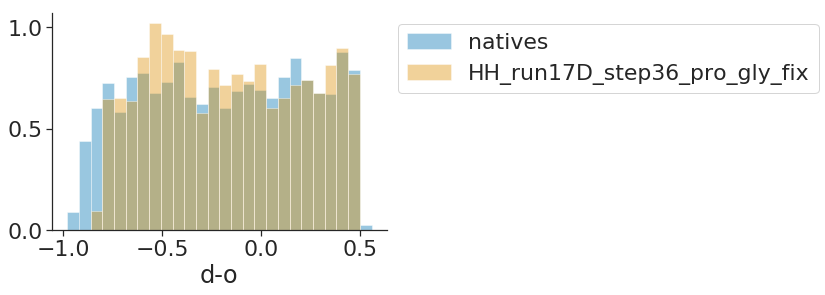

In [32]:
min_val = data['d-o'].min()
max_val = data['d-o'].max()
nbins = 25
bin_size = (max_val - min_val) / nbins
bins = np.arange(min_val, max_val + (2* bin_size), bin_size)

for group in groups:
    data = energies_df[
        (energies_df['group'] == group) &
        (energies_df['res_j_name'] == 'PRO')
    ]
    sns.distplot(
        data['d-o'], label=group, bins=bins, kde=False,
        norm_hist=True
    )

plt.legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

**Observations**
* Decoys don't allow delta hydrogens from proline to get close enough to other atoms
    * change delta carbon and delta hydrogen to (CHR2 and HapR?)


* To do:
    * Check changes in atomic radii for CNH2 and COO

Look at atom pairs involving Cs and Hs.

In [4]:
groups = [
    'natives', 'beta_nov16', 'HH_run17_step403', 'HH_run17D_step36'
]
atom_type_names = [
    'CH1', 'CH2', 'CH3', 'Hapo', 'CHO', 'aroC', 'Haro'
]
dfs = []
for group in groups:
    csvs = glob.glob(os.path.join(
        'results/atom_pair_energies',
        group,
        '*.csv'
    ))
    print(group, len(csvs))
    for csv in csvs:
        df = pandas.read_csv(csv)
        df = df[
            (df['d'] < 5) &
            (df['atom_i_type_name'].isin(atom_type_names)) &
            (df['atom_j_type_name'].isin(atom_type_names))
        ]
        df['group'] = group
        dfs.append(df)
energies_df = pandas.concat(dfs, sort=False)
del dfs

energies_df['d-o'] = energies_df['d'] - energies_df['o']
energies_df = energies_df[energies_df['d-o'] < 0.5]

energies_df['id'] = energies_df.apply(
    lambda row: '{0}_{1}-{2}-{3}-{4}'.format(
        row['pdb'][:4],
        row['res_i_n'], row['atom_i_n'],
        row['res_j_n'], row['atom_j_n']
    ), axis=1
)

energies_df.set_index('id', inplace=True)

natives 75
beta_nov16 81
HH_run17_step403 71
HH_run17D_step36 71


natives 2300
beta_nov16 2300
natives 2300
HH_run17_step403 2300
natives 2300
HH_run17D_step36 2300


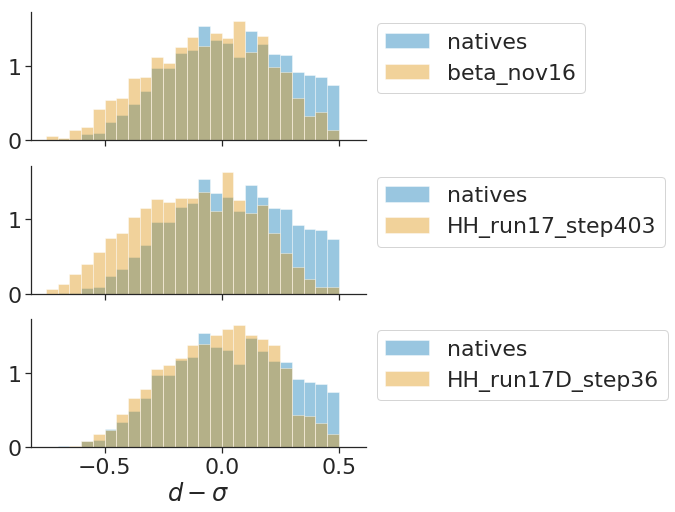

In [17]:
min_val = -0.75 #energies_df['d-o'].min()
max_val = energies_df['d-o'].max()
nbins = 25
bin_size = (max_val - min_val) / nbins
bins = np.arange(min_val, max_val + (bin_size), bin_size)

e_functions = ['beta_nov16', 'HH_run17_step403', 'HH_run17D_step36']
(fig, axs) = plt.subplots(
    nrows=3, sharex=True, sharey=True, figsize=[6,8]
)

atom_type_names = ['CH1', 'CH2', 'CH3']
atom_type_names = ['CH3']
aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET']
data = energies_df[
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    (energies_df['atom_i_type_name'].isin(atom_type_names)) &
    (energies_df['atom_j_type_name'].isin(atom_type_names))
].copy()
groups = ['natives'] + e_functions
common_indices = None
for group in groups:
    indices = set(data[
        (data['group'] == group)
    ].index.values)
    if not common_indices:
        common_indices = indices
    else:
        common_indices = set.intersection(common_indices, indices)
        
for (i, e_function) in enumerate(e_functions):
    groups = [
        'natives', e_function
    ]
    for group in groups:
        data_i = data[
            (data['group'] == group) &
            (data.index.isin(common_indices))
        ]
        print(group, len(data_i))
        sns.distplot(
            data_i['d-o'], label=group, bins=bins, kde=False,
            norm_hist=True, ax=axs[i]
        )
    if i != len(e_functions) - 1:
        axs[i].set(xlabel='')
    else:
        axs[i].set(xlabel='$d-\sigma$')

    axs[i].legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

In [18]:
group = 'natives' # 'beta_nov16' #  
data_i = data[
    (data['group'] == group) &
    (data.index.isin(common_indices))
].copy()
data_i.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'res_i_n', 'res_i_name', 'atom_i_name', 'atom_i_type_name',
    'res_j_n', 'res_j_name', 'atom_j_name', 'atom_j_type_name',
    'd-o'
]
data_i[cols].head(n=20)

,res_i_n,res_i_name,atom_i_name,atom_i_type_name,res_j_n,res_j_name,atom_j_name,atom_j_type_name,d-o
id,,,,,,,,,
3fk8_19-5-65-7,19,ALA,CB,CH3,65,VAL,CG2,CH3,-0.759882
2pvb_13-5-32-6,13,ALA,CB,CH3,32,VAL,CG1,CH3,-0.755817
1euw_14-6-20-8,14,VAL,CG1,CH3,20,LEU,CD2,CH3,-0.688786
1w0n_62-7-111-5,62,VAL,CG2,CH3,111,ALA,CB,CH3,-0.661742
2gzv_21-7-52-8,21,ILE,CG2,CH3,52,ILE,CD1,CH3,-0.610045
1b9o_15-8-26-8,15,ILE,CD1,CH3,26,LEU,CD2,CH3,-0.585654
3co1_58-7-79-6,58,VAL,CG2,CH3,79,VAL,CG1,CH3,-0.583527
3co1_60-7-131-5,60,LEU,CD1,CH3,131,ALA,CB,CH3,-0.567213
1r2m_12-7-62-7,12,LEU,CD1,CH3,62,LEU,CD1,CH3,-0.564241


Look at CH3_Hapo

natives 9442
beta_nov16 9442
natives 9442
HH_run17_step403 9442
natives 9442
HH_run17D_step36 9442


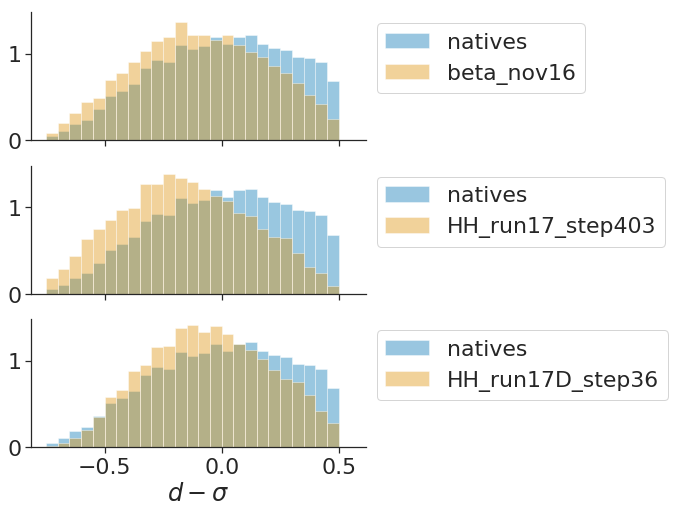

In [22]:
min_val = -0.75 #energies_df['d-o'].min()
max_val = energies_df['d-o'].max()
nbins = 25
bin_size = (max_val - min_val) / nbins
bins = np.arange(min_val, max_val + (bin_size), bin_size)

e_functions = ['beta_nov16', 'HH_run17_step403', 'HH_run17D_step36']
(fig, axs) = plt.subplots(
    nrows=3, sharex=True, sharey=True, figsize=[6,8]
)

aas = ['VAL', 'LEU', 'ILE', 'ALA', 'MET']
c_atom_type_names = ['CH1', 'CH2', 'CH3']
c_atom_type_names = ['CH3']
data = energies_df[
    (energies_df['res_i_name'].isin(aas)) &
    (energies_df['res_j_name'].isin(aas)) &
    (((energies_df['atom_i_type_name'].isin(c_atom_type_names)) &
    (energies_df['atom_j_type_name'] == 'Hapo')) |
    ((energies_df['atom_i_type_name'] == 'Hapo') &
    (energies_df['atom_j_type_name'].isin(c_atom_type_names))))
].copy()
groups = ['natives'] + e_functions
common_indices = None
for group in groups:
    indices = set(data[
        (data['group'] == group)
    ].index.values)
    if not common_indices:
        common_indices = indices
    else:
        common_indices = set.intersection(common_indices, indices)
        
for (i, e_function) in enumerate(e_functions):
    groups = [
        'natives', e_function
    ]
    for group in groups:
        data_i = data[
            (data['group'] == group) &
            (data.index.isin(common_indices))
        ]
        print(group, len(data_i))
        sns.distplot(
            data_i['d-o'], label=group, bins=bins, kde=False,
            norm_hist=True, ax=axs[i]
        )
    if i != len(e_functions) - 1:
        axs[i].set(xlabel='')
    else:
        axs[i].set(xlabel='$d-\sigma$')

    axs[i].legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

In [23]:
group = 'natives' # 'beta_nov16' #  
data_i = data[
    (data['group'] == group) &
    (data.index.isin(common_indices))
].copy()
data_i.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'res_i_n', 'res_i_name', 'atom_i_name', 'atom_i_type_name',
    'res_j_n', 'res_j_name', 'atom_j_name', 'atom_j_type_name',
    'd-o'
]
data_i[cols].head(n=20)

,res_i_n,res_i_name,atom_i_name,atom_i_type_name,res_j_n,res_j_name,atom_j_name,atom_j_type_name,d-o
id,,,,,,,,,
3b79_67-11-121-7,67,ILE,HB,Hapo,121,LEU,CD1,CH3,-0.831483
3nbm_54-12-78-6,54,ILE,1HG1,Hapo,78,VAL,CG1,CH3,-0.829961
2ra9_42-13-51-7,42,LEU,HG,Hapo,51,VAL,CG2,CH3,-0.827996
1t2i_57-7-70-13,57,VAL,CG2,CH3,70,ILE,2HG1,Hapo,-0.827376
1ok0_35-7-56-16,35,VAL,CG2,CH3,56,VAL,3HG2,Hapo,-0.826984
2fwh_29-7-80-14,29,LEU,CD1,CH3,80,VAL,1HG2,Hapo,-0.824078
1jf8_38-19-66-8,38,ILE,3HD1,Hapo,66,ILE,CD1,CH3,-0.819309
1w0n_26-11-35-6,26,VAL,1HG1,Hapo,35,VAL,CG1,CH3,-0.811218
3co1_60-16-131-5,60,LEU,3HD1,Hapo,131,ALA,CB,CH3,-0.796716


Look at the atoms that shift the most

In [19]:
groups = [
    'natives', 'HH_run17D_step36' # 'HH_run17_step403' #'beta_nov16' #
]
df1 = energies_df[energies_df['group'] == groups[0]].copy()
df2 = energies_df[energies_df['group'] == groups[1]].copy()
data = df1.merge(
    df2[['d', 'd-o']], left_index=True, right_index=True, how='inner'
)
del [df1, df2]
data['delta_d'] = data['d_y'] - data['d_x']

# Select data
if True:
    data = data[
        (data['delta_d'] < -0.2)
    ]
print(len(data), data['delta_d'].mean())

# Display dataframe
cols = [
    'res_i_pdb_n', #'res_i_n', 
    'res_i_name', 'atom_i_name',
    'res_j_pdb_n', #'res_j_n', 
    'res_j_name', 'atom_j_name',
    'delta_d', 'd-o_y', 'd_y'
]
data.sort_values('d-o_y', ascending=True, inplace=True)
data[
    (data['atom_i_name'] != 'test')
    #(data['res_i_name'] == 'CYS') |
    #(data['res_j_name'] == 'CYS')
][cols].head(30)

70 -0.3291725202316647


,res_i_pdb_n,res_i_name,atom_i_name,res_j_pdb_n,res_j_name,atom_j_name,delta_d,d-o_y,d_y
id,,,,,,,,,
2iay_72-7-102-8,71,MET,SD,101,LEU,CD2,-0.473642,-0.434704,3.553023
3b79_85-7-87-7,84,ILE,CG2,86,MET,SD,-0.264420,-0.433458,3.554269
1euw_33-7-68-7,33,LEU,CD1,68,MET,SD,-0.282166,-0.386324,3.601403
1jbe_42-8-75-7,43,LEU,CD2,78,MET,SD,-0.836051,-0.377158,3.610569
1kf5_26-6-82-7,26,CYS,SG,82,THR,CG2,-0.274007,-0.355812,3.631915
2wwe_49-7-103-6,1244,LEU,CD1,1298,CYS,SG,-0.302850,-0.348424,3.639303
1ucs_22-7-40-7,22,MET,SD,40,LEU,CD1,-0.270397,-0.343897,3.643830
1b9o_55-7-91-6,55,ILE,CG2,91,CYS,SG,-0.223422,-0.333741,3.653986
2nsz_18-8-61-7,339,LEU,CD2,382,MET,SD,-0.505436,-0.325961,3.661766


Look at CH3_S pairs

In [14]:
groups = [
    'natives', 'beta_nov16', 'HH_run17_step403', 'HH_run17D_step36'
]
dfs = []
for group in groups:
    csvs = glob.glob(os.path.join(
        'results/atom_pair_energies',
        group,
        '*.csv'
    ))
    print(group, len(csvs))
    for csv in csvs:
        df = pandas.read_csv(csv)
        df = df[
            (df['d'] < 5) &
            ((df['atom_i_type_name'].str.contains('S')) &
            (df['atom_j_type_name'] == 'CH3')) |
            ((df['atom_i_type_name'] == 'CH3') &
            (df['atom_j_type_name'].str.contains('S')))
        ]
        df['group'] = group
        dfs.append(df)
energies_df = pandas.concat(dfs, sort=False)
del dfs

energies_df['d-o'] = energies_df['d'] - energies_df['o']
energies_df = energies_df[energies_df['d-o'] < 0.5]

energies_df['id'] = energies_df.apply(
    lambda row: '{0}_{1}-{2}-{3}-{4}'.format(
        row['pdb'][:4],
        row['res_i_n'], row['atom_i_n'],
        row['res_j_n'], row['atom_j_n']
    ), axis=1
)

energies_df.set_index('id', inplace=True)

natives 81
beta_nov16 76
HH_run17_step403 66
HH_run17D_step36 67


natives 267
beta_nov16 267
natives 267
HH_run17_step403 267
natives 267
HH_run17D_step36 267


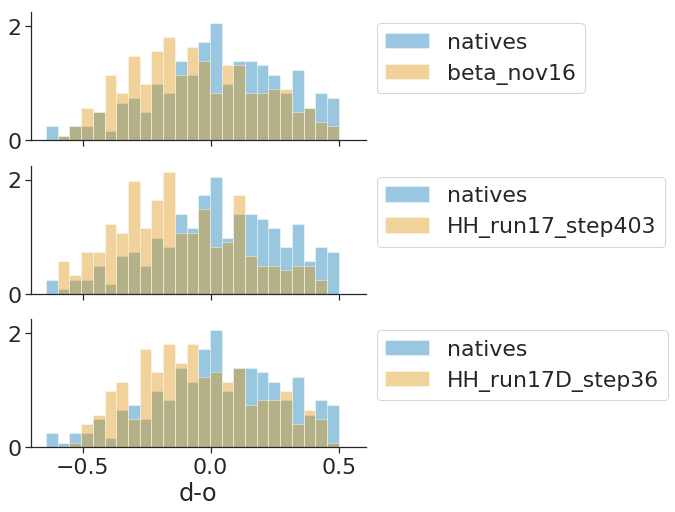

In [15]:
min_val = energies_df['d-o'].min()
max_val = energies_df['d-o'].max()
nbins = 25
bin_size = (max_val - min_val) / nbins
bins = np.arange(min_val, max_val + (bin_size), bin_size)

e_functions = ['beta_nov16', 'HH_run17_step403', 'HH_run17D_step36']
(fig, axs) = plt.subplots(
    nrows=3, sharex=True, sharey=True, figsize=[6,8]
)

data = energies_df.copy()
groups = ['natives'] + e_functions
common_indices = None
for group in groups:
    indices = set(data[
        (data['group'] == group)
    ].index.values)
    if not common_indices:
        common_indices = indices
    else:
        common_indices = set.intersection(common_indices, indices)
        
for (i, e_function) in enumerate(e_functions):
    groups = [
        'natives', e_function
    ]
    for group in groups:
        data_i = data[
            (data['group'] == group) &
            (data.index.isin(common_indices))
        ]
        print(group, len(data_i))
        sns.distplot(
            data_i['d-o'], label=group, bins=bins, kde=False,
            norm_hist=True, ax=axs[i]
        )
    if i != len(e_functions) - 1:
        axs[i].set(xlabel='')

    axs[i].legend(bbox_to_anchor=(1,1))
sns.despine()
plt.show()

In [16]:
group = 'natives' # 'beta_nov16' #  
data_i = data[
    (data['group'] == group) &
    (data.index.isin(common_indices))
].copy()
data_i.sort_values('d-o', ascending=True, inplace=True)
cols = [
    'res_i_n', 'res_i_name', 'atom_i_name', 'atom_i_type_name',
    'res_j_n', 'res_j_name', 'atom_j_name', 'atom_j_type_name',
    'd-o'
]
data_i[cols].head(n=20)

,res_i_n,res_i_name,atom_i_name,atom_i_type_name,res_j_n,res_j_name,atom_j_name,atom_j_type_name,d-o
id,,,,,,,,,
2wwe_53-8-103-6,53,LEU,CD2,CH3,103,CYS,SG,SH1,-0.638288
1u2h_35-6-77-6,35,VAL,CG1,CH3,77,CYS,SG,SH1,-0.619649
1jbe_10-6-59-7,10,VAL,CG1,CH3,59,MET,SD,S,-0.603885
1zlb_54-6-57-6,54,VAL,CG1,CH3,57,CYS,SG,SH1,-0.575082
1zlb_57-6-85-8,57,CYS,SG,SH1,85,ILE,CD1,CH3,-0.545410
1euw_89-8-120-7,89,ILE,CD1,CH3,120,MET,SD,S,-0.530198
1aho_6-7-48-6,6,ILE,CG2,CH3,48,CYS,SG,SH1,-0.522542
1npi_5-7-44-6,5,LEU,CD1,CH3,44,CYS,SG,SH1,-0.502293
3q6l_1-6-49-8,1,CYS,SG,SH1,49,ILE,CD1,CH3,-0.467959


Look at the atoms that shift the most

In [19]:
groups = [
    'natives', 'HH_run17D_step36' # 'HH_run17_step403' #'beta_nov16' #
]
df1 = energies_df[energies_df['group'] == groups[0]].copy()
df2 = energies_df[energies_df['group'] == groups[1]].copy()
data = df1.merge(
    df2[['d', 'd-o']], left_index=True, right_index=True, how='inner'
)
del [df1, df2]
data['delta_d'] = data['d_y'] - data['d_x']

# Select data
if True:
    data = data[
        (data['delta_d'] < -0.2)
    ]
print(len(data), data['delta_d'].mean())

# Display dataframe
cols = [
    'res_i_pdb_n', #'res_i_n', 
    'res_i_name', 'atom_i_name',
    'res_j_pdb_n', #'res_j_n', 
    'res_j_name', 'atom_j_name',
    'delta_d', 'd-o_y', 'd_y'
]
data.sort_values('d-o_y', ascending=True, inplace=True)
data[
    (data['atom_i_name'] != 'test')
    #(data['res_i_name'] == 'CYS') |
    #(data['res_j_name'] == 'CYS')
][cols].head(30)

70 -0.3291725202316647


,res_i_pdb_n,res_i_name,atom_i_name,res_j_pdb_n,res_j_name,atom_j_name,delta_d,d-o_y,d_y
id,,,,,,,,,
2iay_72-7-102-8,71,MET,SD,101,LEU,CD2,-0.473642,-0.434704,3.553023
3b79_85-7-87-7,84,ILE,CG2,86,MET,SD,-0.264420,-0.433458,3.554269
1euw_33-7-68-7,33,LEU,CD1,68,MET,SD,-0.282166,-0.386324,3.601403
1jbe_42-8-75-7,43,LEU,CD2,78,MET,SD,-0.836051,-0.377158,3.610569
1kf5_26-6-82-7,26,CYS,SG,82,THR,CG2,-0.274007,-0.355812,3.631915
2wwe_49-7-103-6,1244,LEU,CD1,1298,CYS,SG,-0.302850,-0.348424,3.639303
1ucs_22-7-40-7,22,MET,SD,40,LEU,CD1,-0.270397,-0.343897,3.643830
1b9o_55-7-91-6,55,ILE,CG2,91,CYS,SG,-0.223422,-0.333741,3.653986
2nsz_18-8-61-7,339,LEU,CD2,382,MET,SD,-0.505436,-0.325961,3.661766


In [68]:
sigma_dict = {
    'Narg:OCbb' : 1.802452 + 1.540580,
    'Nlys:OCbb' : 1.802452 + 1.540580,
    'NH2O:OCbb' : 1.802452 + 1.540580,
    'Nbb:OCbb' : 1.802452 + 1.540580,
    'OCbb:OCbb' : 1.540580 + 1.540580,
    'CObb:OCbb' : 1.916661 + 1.540580,
    'CObb:OH' : 1.916661 + 1.542743,
    'CAbb:CObb' : 2.011760 + 1.916661,
    'CAbb:OCbb' : 2.011760 + 1.540580,
    'Hapo:Hapo' : 1.4 + 1.4,
    'HapR:HapR' : 1.4 + 1.4,
    'Hapo:OCbb' : 1.4 + 1.540580,
    'HapR:OCbb' : 1.4 + 1.540580,
    'HAbb:OCbb' : 1.4 + 1.540580,
    'CAbb:Hapo' : 2.011760 + 1.4,
    'CH1:Hapo' : 2.011760 + 1.4,
    'CH2:Hapo' : 2.011760 + 1.4,
    'CH3:Hapo' : 2.011760 + 1.4,
    'CAbb:Haro' : 2.011760 + 1.4,
    'CH1:Haro' : 2.011760 + 1.4,
    'CH2:Haro' : 2.011760 + 1.4,
    'CH3:Haro' : 2.011760 + 1.4,
    'CH1:HAbb' : 2.011760 + 1.4,
    'CH2:HAbb' : 2.011760 + 1.4,
    'CH3:HAbb' : 2.011760 + 1.4,
    'CAbb:HapR' : 2.011760 + 1.4,
    'CAbb:CAbb' : 2.011760 + 2.011760,
    'CHR1:CHR1' : 1.82 + 1.82,
    'CH1:CHR1' : 2.011760 + 1.82,
    'CH1:CH1' : 2.011760 + 2.011760,
    'CH2:CH2' : 2.011760 + 2.011760,
    'CH1:CH3' : 2.011760 + 2.011760,
    'CH2:CH3' : 2.011760 + 2.011760,
    'CH3:CH3' : 2.011760 + 2.011760,
    'CH3:OCbb' : 2.011760 + 1.540580,
    'CH2:OCbb' : 2.011760 + 1.540580,
    'CH1:OCbb' : 2.011760 + 1.540580,
    'CH2:OH' : 2.011760 + 1.542743,
    'CH3:OH' : 2.011760 + 1.542743,
    'CH3:S' : 2.011760 + 1.975967,
    'CH2:SH1' : 2.011760 + 1.975967,
    'CH3:SH1' : 2.011760 + 1.975967,
    'CH3:SH1' : 2.011760 + 1.975967,
    'CH3:Narg' : 1.802452 + 1.975967,
    'aroC:aroC' : 2.016441 + 2.016441,
    'CH3:aroC' : 2.011760 + 2.016441,
    'OH:aroC' : 1.542743 + 2.016441,
    'OOC:aroC' : 1.492871 + 2.016441,
    'OCbb:aroC' : 1.540580 + 2.016441,
    'OCbb:OH' : 1.542743 + 1.540580,
    'Nbb:OH' : 1.802452 + 1.540580,
}

distance_range = {
    'Hapo:Hapo' : (1.9, 3.3),
    'HapR:HapR' : (1.9, 3.3),
    'Hapo:OCbb' : (2.0, 3.6),
    'HapR:OCbb' : (2.0, 3.6),
    'HAbb:OCbb' : (2.0, 3.6),
    'CAbb:Hapo' : (2.5, 3.9),
    'CH1:Hapo' : (2.5, 3.9),
    'CH2:Hapo' : (2.5, 3.9),
    'CH3:Hapo' : (2.5, 3.9),
    'CAbb:Haro' : (2.5, 3.9),
    'CH1:Haro' : (2.5, 3.9),
    'CH2:Haro' : (2.5, 3.9),
    'CH3:Haro' : (2.5, 3.9),
    'CH1:HAbb' : (2.5, 3.9),
    'CH2:HAbb' : (2.5, 3.9),
    'CH3:HAbb' : (2.5, 3.9),
    'CAbb:HapR' : (2.5, 3.9),
    'Narg:OCbb' : (2.2, 4.2),
    'Nlys:OCbb' : (2.2, 4.2),
    'Nbb:OCbb' : (2.6, 4.0),
    'NH2O:OCbb' : (2.2, 4.2),
    'OCbb:OCbb' : (2.8, 3.7),
    'CObb:OCbb' : (3.2, 4.1),
    'CAbb:OCbb' : (2.9, 4.2),
    'CAbb:CAbb' : (3.2, 4.7),
    'CAbb:CObb' : (3.1, 4.6),
    'CObb:OH' : (2.8, 4.2),
    'CHR1:CHR1' : (3.2, 4.7),
    'CH1:CHR1' : (3.2, 4.7),
    'CH1:CH1' : (3.2, 4.7),
    'CH2:CH2' : (3.2, 4.7),
    'CH1:CH3' : (3.2, 4.7),
    'CH2:CH3' : (3.2, 4.7),
    'CH3:CH3' : (3.2, 4.7),
    'CH3:OCbb' : (2.9, 4.2),
    'CH2:OCbb' : (2.9, 4.2),
    'CH1:OCbb' : (2.9, 4.2),
    'CH2:OH' : (2.8, 4.2),
    'CH3:OH' : (2.8, 4.2),
    'CH3:S' : (3.1, 4.7),
    'CH2:SH1' : (2.6, 4.7),
    'CH3:SH1' : (3.1, 4.7),
    'CH3:Narg' : (3.2, 4.6),
    'aroC:aroC' : (3.2, 4.8),
    'CH3:aroC' :(3.2, 4.6),
    'OH:aroC' :(2.8, 4.3),
    'OOC:aroC' :(2.8, 4.3),
    'OCbb:aroC' :(2.9, 4.2),
    'OCbb:OH' : (2.2, 3.9),
    'Nbb:OH' : (2.3, 4.2),
}